# Hierarchical Regression

This notebook prepares an annotated dataset and builds a flexible hierarchical ordinal regression. It constructs nested region-country-provider effects with optional first-party contributions, allows shared or outcome-specific slopes, and supports multiple year trends (none, linear, spline, or GP). Along the way we set up coordinates, design matrices, and priors to enable scalable inference and clear posterior summaries.

In [1]:
import os

os.environ["JAX_PLATFORMS"] = "cpu"

In [2]:
from os import path as osp
from typing import Dict, Optional, Tuple

import arviz as az
import jax
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import numpyro
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import xarray as xr
from matplotlib.ticker import MultipleLocator
from patsy import build_design_matrices, dmatrix

In [3]:
numpyro.set_host_device_count(256)

In [4]:
%matplotlib inline

In [5]:
plt.rcParams["font.family"] = "Times New Roman"

## Data

In [9]:
df = pd.read_csv(osp.join("data", "MAIN_ANNOTATIONS_MERGED.tsv"), sep="\t")

In [10]:
def prepare_data(df: pd.DataFrame):
    # 1. Basic cleaning
    for col in ["openness", "sector", "region", "country", "provider"]:
        df[col] = df[col].astype(str).str.strip()
    df["openness"] = df["openness"].str.lower()

    # 2. Ordinal score mapping (robust)
    score_levels = np.sort(df["score"].dropna().unique())
    score_map = {v: i for i, v in enumerate(score_levels)}
    df["score0"] = df["score"].map(score_map).astype("int64")
    K = len(score_levels)

    # 3. Outcome/category mapping (explicit)
    category_levels = np.sort(df["category"].dropna().unique())
    category_map = {v: i for i, v in enumerate(category_levels)}
    df["outcome"] = df["category"].map(category_map).astype("int64")
    J = len(category_levels)

    # 4. Binary first-party indicator (ensure 0/1)
    df["fp_id"] = df["is_first_party"].astype(bool).astype("int64")

    # 5. Group indices (stable ordering via sorted unique)
    def index_col(col):
        levels = pd.Index(np.sort(df[col].unique()), name=col)
        mapping = {v: i for i, v in enumerate(levels)}
        return df[col].map(mapping).astype("int64"), levels

    df["region_id"], region_levels = index_col("region")
    df["country_id"], country_levels = index_col("country")
    df["provider_id"], provider_levels = index_col("provider")

    # 6. Predictor: openness (centered)
    df["open_bin"] = (df["openness"] == "open").astype("int64")
    open_mean = df["open_bin"].mean()
    df["open_c"] = df["open_bin"] - open_mean

    # 7. Sector dummies with explicit most frequent reference
    sector_ref = df["sector"].value_counts().idxmax()
    df["_sector_ref"] = (df["sector"] == sector_ref).astype(int)
    sector_levels = [s for s in sorted(df["sector"].unique()) if s != sector_ref]
    sector_dum = pd.get_dummies(df["sector"])[sector_levels].astype("int64")

    # 8. Design matrix
    W = np.column_stack([df["open_c"].to_numpy(), sector_dum.to_numpy()]).astype(
        "float32"
    )
    pred_names = ["open_c"] + sector_levels

    # 9. Observed vectors
    y_obs = df["score0"].to_numpy().astype("int64")
    out_idx = df["outcome"].to_numpy().astype("int64")
    reg_idx = df["region_id"].to_numpy().astype("int64")
    cty_idx = df["country_id"].to_numpy().astype("int64")
    prov_idx = df["provider_id"].to_numpy().astype("int64")
    fp_idx = df["fp_id"].to_numpy().astype("int64")

    # --- NEW: predictors needed for random slope & smooth year ---
    # Standardized year (for stability) + compact index for unique years (for GP)
    year_raw = df["year"].to_numpy()
    year_mean = float(year_raw.mean())
    year_sd = float(year_raw.std() if year_raw.std() > 0 else 1.0)
    year_std = (year_raw - year_mean) / year_sd
    year_u, year_idx = np.unique(
        year_std, return_inverse=True
    )  # unique values & row-wise index
    Y = int(year_u.size)

    # 10. Cardinalities
    R = len(region_levels)
    C = len(country_levels)
    G = len(provider_levels)
    F = len(df["fp_id"].unique())
    P = W.shape[1]

    # --- NEW: parent maps + counts for within-parent sum-to-zero constraints ---
    # country -> region (C x R) one-hot
    C2R = np.zeros((C, R), dtype="float32")
    _tmp = df[["country_id", "region_id"]].drop_duplicates()
    C2R[_tmp["country_id"].to_numpy(), _tmp["region_id"].to_numpy()] = 1.0

    # provider -> country (G x C) one-hot
    P2C = np.zeros((G, C), dtype="float32")
    _tmp = df[["provider_id", "country_id"]].drop_duplicates()
    P2C[_tmp["provider_id"].to_numpy(), _tmp["country_id"].to_numpy()] = 1.0

    # how many children under each parent (avoid divide-by-zero; all parents in data have >=1)
    reg_country_counts = C2R.sum(axis=0)  # (R,)
    cty_prov_counts = P2C.sum(axis=0)  # (C,)

    # 11. Coords
    coords = dict(
        obs=np.arange(len(df)),
        outcome=np.arange(J),
        region=np.arange(R),
        country=np.arange(C),
        provider=np.arange(G),
        firstparty=np.arange(F),
        pred=np.array(pred_names, dtype=object),
        threshold=np.arange(K - 1),
        year=np.arange(Y),  # GP over unique standardized years
    )

    meta = dict(
        score_map=score_map,
        category_map=category_map,
        sector_reference=sector_ref,
        open_mean=open_mean,
        region_levels=region_levels.tolist(),
        country_levels=country_levels.tolist(),
        provider_levels=provider_levels.tolist(),
    )

    return dict(
        df=df,
        W=W,
        y_obs=y_obs,
        out_idx=out_idx,
        reg_idx=reg_idx,
        cty_idx=cty_idx,
        prov_idx=prov_idx,
        fp_idx=fp_idx,
        K=K,
        J=J,
        C2R=C2R,
        P2C=P2C,
        reg_country_counts=reg_country_counts,
        cty_prov_counts=cty_prov_counts,
        year_std=year_std,
        year_u=year_u,
        year_idx=year_idx,
        Y=Y,
        year_mean=year_mean,
        year_sd=year_sd,
        coords=coords,
        meta=meta,
        pred_names=pred_names,
    )

In [11]:
prep = prepare_data(df)

In [12]:
W = prep["W"]
y_obs = prep["y_obs"]
out_idx = prep["out_idx"]
reg_idx = prep["reg_idx"]
cty_idx = prep["cty_idx"]
prov_idx = prep["prov_idx"]
fp_idx = prep["fp_idx"]
K = prep["K"]
J = prep["J"]
C2R = prep["C2R"]
P2C = prep["P2C"]
reg_country_counts = prep["reg_country_counts"]
cty_prov_counts = prep["cty_prov_counts"]
year_std = prep["year_std"]  # standardized year per observation
year_u = prep["year_u"]  # unique standardized years
year_idx = prep["year_idx"]
coords = prep["coords"]

In [13]:
region_levels = prep["meta"]["region_levels"]
country_levels = prep["meta"]["country_levels"]
provider_levels = prep["meta"]["provider_levels"]

In [14]:
assert C2R.shape[0] == len(np.unique(cty_idx))
assert C2R.shape[1] == len(np.unique(reg_idx))
assert P2C.shape[0] == len(np.unique(prov_idx))
assert P2C.shape[1] == len(np.unique(cty_idx))

## Helper functions

### ICC

In [15]:
def attach_y_model_from_probs(idata, y_var="y", probs_var="y_probs"):
    """
    Create posterior['y_model'] as E[y | params] using the per-category probabilities
    in posterior[probs_var] (shape: chain, draw, obs, K). Works for ordered logit/probit.
    """
    if "posterior" not in idata.groups() or probs_var not in idata.posterior:
        raise KeyError(f"Could not find posterior['{probs_var}'] in the InferenceData.")

    p = idata.posterior[probs_var]  # xarray.DataArray, e.g. (chain, draw, obs, K)
    # Heuristics for dims (robust to arbitrary names):
    chain_dim, draw_dim = p.dims[0], p.dims[1]
    obs_dim, cat_dim = p.dims[-2], p.dims[-1]

    # Determine coding offset from observed y (0-based vs 1-based)
    if "observed_data" not in idata.groups() or y_var not in idata.observed_data:
        raise KeyError(
            f"observed_data['{y_var}'] not found; needed to infer category coding."
        )
    y_obs = idata.observed_data[y_var]
    # drop coords to ensure numeric min
    y_min = int(np.nanmin(y_obs.values))
    # categories assumed contiguous: [y_min, y_min+1, ..., y_min+K-1]
    cats = xr.DataArray(np.arange(p.sizes[cat_dim]) + y_min, dims=[cat_dim])

    # Expected category per draw/obs
    y_model = (p * cats).sum(cat_dim)  # dims: (chain, draw, obs)
    y_model = y_model.transpose(chain_dim, draw_dim, obs_dim)

    # Attach to posterior
    idata.posterior["y_model"] = y_model
    return idata

In [19]:
def _stack_samples(da: xr.DataArray) -> xr.DataArray:
    # (chain, draw, ...)  ->  (s, ...)
    return da.stack(s=("chain", "draw")).transpose(
        "s", *[d for d in da.dims if d not in ("chain", "draw")]
    )


def _gather_component(posterior, var_name, idx_vec, level_dim, out_idx):
    """
    Collect contribution for each observation from a random-effect array with dims (level, outcome).
    Returns array of shape (S, N).
    """
    da = _stack_samples(posterior[var_name]).transpose("s", level_dim, "outcome")
    arr = da.values  # (S, L, J)
    S = arr.shape[0]
    idx = np.asarray(idx_vec, dtype=int)
    out = np.asarray(out_idx, dtype=int)
    return arr[np.arange(S)[:, None], idx[None, :], out[None, :]]  # (S, N)


def compute_icc_vpc(
    idata,
    *,
    out_idx,
    reg_idx,
    cty_idx,
    prov_idx,
    fp_idx=None,
    link: str = "logit",
    include_year: bool = True,
    include_firstparty_group: bool = False,
):
    """
    Returns a DataFrame with per-outcome ICCs for each component and the overall random share.
    Decomposition uses Var(sum) = 1' Σ 1, and splits covariance by row-sums so shares sum to 1.
    """
    posterior = idata.posterior
    J = posterior.sizes["outcome"]
    out = np.asarray(out_idx, dtype=int)
    outcomes = np.arange(J)

    # Build component contributions per observation
    comps = {}
    comps["region"] = _gather_component(
        posterior, "region_int", reg_idx, "region", out_idx
    )
    comps["country"] = _gather_component(
        posterior, "country_dev", cty_idx, "country", out_idx
    )
    comps["provider"] = _gather_component(
        posterior, "provider_dev", prov_idx, "provider", out_idx
    )

    if include_firstparty_group and "firstparty_int" in posterior:
        comps["firstparty(group)"] = _gather_component(
            posterior, "firstparty_int", fp_idx, "firstparty", out_idx
        )

    if include_year and "year_effect" in posterior:
        comps["year"] = (
            _stack_samples(posterior["year_effect"]).transpose("s", "obs").values
        )  # (S, N)

    # Level-1 residual variance on the latent scale
    resid_var = (np.pi**2) / 3.0 if link == "logit" else 1.0

    rows = []
    for j in outcomes:
        mask = out == j
        if mask.sum() == 0:
            continue

        # For each posterior draw, build the G x n_j component matrix and its covariance
        comp_names = list(comps.keys())
        G = len(comp_names)
        # prealloc
        row_sums_all = []
        var_sum_all = []

        for s in range(next(iter(comps.values())).shape[0]):  # S
            C = np.vstack([comps[name][s, mask] for name in comp_names])  # (G, n_j)
            Σ = np.cov(C, bias=False)  # (G, G)
            tot = Σ.sum()  # Var(sum of components) = 1' Σ 1
            var_sum_all.append(tot)
            row_sums_all.append(Σ.sum(axis=1))  # Var(g) + Σ_{h≠g} Cov(g,h)

        row_sums_all = np.asarray(row_sums_all)  # (S, G)
        var_sum_all = np.asarray(var_sum_all)  # (S,)

        denom = var_sum_all + resid_var
        icc_total = var_sum_all / denom  # overall random share (latent-scale ICC)

        # Component-specific ICCs: attribute half of each covariance to each component (row-sum approach)
        icc_comp = row_sums_all / denom[:, None]  # (S, G)

        # Summaries
        for g_idx, g in enumerate(comp_names):
            vals = icc_comp[:, g_idx]
            rows.append(
                {
                    "outcome": j,
                    "component": g,
                    "ICC_mean": float(vals.mean()),
                    "ICC_05": float(np.quantile(vals, 0.05)),
                    "ICC_95": float(np.quantile(vals, 0.95)),
                }
            )

        rows.append(
            {
                "outcome": j,
                "component": "total_random",
                "ICC_mean": float(icc_total.mean()),
                "ICC_05": float(np.quantile(icc_total, 0.05)),
                "ICC_95": float(np.quantile(icc_total, 0.95)),
            }
        )

    df = pd.DataFrame(rows).sort_values(["outcome", "component"]).reset_index(drop=True)

    # Weighted overall (by outcome frequency in the data)
    counts = np.bincount(out, minlength=J).astype(float)
    w = counts / counts.sum()
    pivot = df.pivot_table(
        index="component", columns="outcome", values="ICC_mean", aggfunc="mean"
    ).fillna(0.0)
    overall_weighted = (pivot @ w).sort_values(ascending=False)

    return df, overall_weighted

### Year smooth plot


In [20]:
def plot_year_conditional_smooth(
    idata,
    outcome=None,  # int or label; ignored if pool is not None
    pool=None,  # None | "mean" | "weighted" | 1D array-like (len=J, sums to 1)
    hdi_probs=(0.95, 0.50),
    center=True,
    degree=3,  # spline degree used at fit time
    grid="unique",  # "unique" or int (e.g., 200) or array of years
    ax=None,
    title_prefix="Conditional smooth for year",
    prep={"year_mean": prep["year_mean"], "year_sd": prep["year_sd"]},
):
    """
    brms::conditional_smooths()-style plot: link-scale partial effect of the year term.

    outcome: which response (J-dim) to plot (ignored if pool is not None)
    pool:    None (single response) or aggregate across responses:
             - "mean":   uniform average over responses
             - "weighted": weighted by response frequency in out_idx
             - array-like length J: custom weights (sum to 1)
    """
    # --- data exported via pm.Data ---
    year_std_obs = np.asarray(idata.constant_data["year_std"]).reshape(-1)
    year_u = np.asarray(idata.constant_data["year_u"]).reshape(-1)
    year_idx = np.asarray(idata.constant_data["year_idx"]).astype(int)
    years_obs = year_u[year_idx]
    # out_idx_arr = np.asarray(idata.constant_data["out_idx"]).astype(int)

    # outcome coordinate if available
    def _get_outcome_coord(varname):
        if varname in idata.posterior and "outcome" in idata.posterior[varname].coords:
            return np.asarray(idata.posterior[varname].coords["outcome"].values)
        return None

    oc = _get_outcome_coord("weights_year")  # or _get_outcome_coord("f_year")
    J = int(idata.posterior.sizes["outcome"])

    # --- pooling weights over responses (if requested) ---
    w = None
    if pool is None:
        # choose a single response
        if outcome is None:
            counts = np.bincount(out_idx, minlength=J)
            j_star = int(np.argmax(counts))  # most frequent response
            out_label = oc[j_star] if oc is not None else j_star
        else:
            if (oc is not None) and (outcome in list(oc)):
                j_star = int(np.where(oc == outcome)[0][0])
                out_label = outcome
            else:
                j_star = int(outcome)
                out_label = outcome
    else:
        if pool == "mean":
            w = np.ones(J) / J
        elif pool == "weighted":
            counts = np.bincount(out_idx, minlength=J).astype(float)
            w = counts / counts.sum() if counts.sum() > 0 else np.ones(J) / J
        else:
            w = np.asarray(pool, dtype=float)
            assert w.shape == (J,), f"custom weights must have length {J}"
            w = w / w.sum()
        out_label = f"pooled ({'weighted' if isinstance(pool,str) else 'custom'})"

    # --- grid on calendar year ---
    if grid == "unique":
        years_grid = np.unique(years_obs)
    elif isinstance(grid, int):
        years_grid = np.linspace(years_obs.min(), years_obs.max(), grid).astype(float)
    else:
        years_grid = np.array(grid, dtype=float)

    # map year -> z (standardized) using observed mapping; fallback to linear map
    df_map = (
        pd.DataFrame({"year": years_obs, "z": year_std_obs}).groupby("year")["z"].mean()
    )
    if np.all(np.isin(years_grid, df_map.index.values)):
        z_grid = df_map.loc[years_grid].values
    else:
        coeffs = np.polyfit(df_map.index.values.astype(float), df_map.values, 1)
        z_grid = np.polyval(coeffs, years_grid)
    if prep is None or "year_mean" not in prep or "year_sd" not in prep:
        raise KeyError(
            "Pass prep={'year_mean': ..., 'year_sd': ...} to unstandardize the x-axis."
        )
    year_mean = float(prep["year_mean"])
    year_sd = float(prep["year_sd"])
    x_plot = z_grid * year_sd + year_mean

    has_spline = "weights_year" in idata.posterior
    has_gp = "f_year" in idata.posterior
    if not (has_spline or has_gp):
        raise KeyError(
            "Neither 'weights_year' (spline) nor 'f_year' (GP) found in idata.posterior."
        )

    # --- SPLINE path: rebuild same Patsy basis; f = Xg @ weights_year
    if has_spline:
        n_basis = int(idata.posterior.sizes["year_basis"])
        formula = (
            f"bs(year_std, df={n_basis} - 1, degree={degree}, include_intercept=False)"
        )
        B_train = dmatrix(
            formula, data={"year_std": year_std_obs}, return_type="dataframe"
        )
        info = B_train.design_info
        Xg = np.asarray(
            build_design_matrices([info], {"year_std": z_grid})[0]
        )  # (G, n_basis)

        W = idata.posterior["weights_year"]  # (chain, draw, year_basis, outcome)
        W_sd = W.stack(sample=("chain", "draw")).transpose(
            "year_basis", "outcome", "sample"
        )  # (K,J,S)

        if w is None:
            Wj = W_sd.isel(outcome=j_star)  # (K,S)
            f = Xg @ np.asarray(Wj)  # (G,S)
            method = "spline"
        else:
            w_da = xr.DataArray(w, dims=["outcome"])
            Wpool = (W_sd * w_da).sum("outcome")  # (K,S)
            f = Xg @ np.asarray(Wpool)  # (G,S)
            method = "spline (pooled)"

    # --- GP path: use latent f at observed unique years (no extrapolation here)
    if (not has_spline) and has_gp:
        f_year = idata.posterior["f_year"]  # (chain, draw, year_unique, outcome)
        if not np.all(np.isin(years_grid, year_u)):
            missing = np.setdiff1d(years_grid, year_u)
            raise ValueError(
                "GP mode: years_grid includes unobserved years. "
                "You’ll need a GP conditional to predict at new years. "
                f"Missing examples: {missing[:5]} ..."
            )
        pos = pd.Index(year_u).get_indexer(years_grid)
        F_sd = f_year.stack(sample=("chain", "draw")).transpose(
            "year_unique", "outcome", "sample"
        )  # (U,J,S)
        if w is None:
            Fj = F_sd.isel(
                outcome=j_star, year_unique=xr.DataArray(pos, dims="g")
            )  # (G,S)
            f = np.asarray(Fj)
            method = "GP"
        else:
            w_da = xr.DataArray(w, dims=["outcome"])
            Fpool = (
                (F_sd * w_da)
                .sum("outcome")
                .isel(year_unique=xr.DataArray(pos, dims="g"))
            )  # (G,S)
            f = np.asarray(Fpool)
            method = "GP (pooled)"

    # --- center per draw (GAM/brms plotting convention: mean-zero smooth on link scale)
    if center:
        f = f - f.mean(axis=0, keepdims=True)

    # --- summarize & plot ---
    probs = sorted(hdi_probs, reverse=True)  # e.g., [0.95, 0.50]
    qs = [(1 - p) / 2 * 100 for p in probs], [(1 + p) / 2 * 100 for p in probs]
    f_med = np.median(f, axis=1)
    bands = [np.percentile(f, [lo, hi], axis=1) for lo, hi in zip(*qs)]

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    for (lo, hi), p in zip(bands, probs):
        ax.fill_between(
            x_plot,
            lo,
            hi,
            alpha=0.12 if p >= 0.90 else 0.20,
            label=f"{int(p*100)}% HDI",
        )
    ax.plot(x_plot, f_med, lw=2.5, label="Year smooth (link scale)")
    ax.axhline(0, color="k", lw=0.8, alpha=0.5)
    ax.set_xlabel("Year")
    ax.set_ylabel(
        "Partial effect (link scale, centered)"
        if center
        else "Partial effect (link scale)"
    )

    title_suffix = f"{method} — " + (
        f"outcome {out_label + 1}" if pool is None else out_label
    )
    ax.set_title(f"{title_prefix} — {title_suffix}")
    ax.legend(frameon=False)

    summary = pd.DataFrame({"year": years_grid, "median": f_med})
    for b, p in zip(bands, probs):
        summary[f"lo{int(p*100)}"] = b[0]
        summary[f"hi{int(p*100)}"] = b[1]
    return ax, summary

### Ridgeplot with highlighted + annotated subset

In [21]:
def ridgeplot_highlight_annotate_subset(
    idata,
    *,
    # subset selection (mirrors ArviZ)
    var_names=None,  # list or pattern(s); combine with filter_vars
    filter_vars=None,  # None | "like" | "regex" (applies to var_names)
    coords=None,  # dict of coord slices (e.g., {"beta_dim": [0,2,4]})
    group="posterior",
    # interval & labeling
    hdi_prob=0.95,  # used for ETI + plot markers
    labeller=None,  # pass an ArviZ labeller to keep labels consistent
    # ridge styling
    base_alpha=0.25,
    highlight_alpha=0.9,
    ridgeplot_overlap=1.5,
    # annotations
    marker_size=3,
    text_fmt="{x:.3g}",
    text_pad_frac=0.01,  # nudge label to the right of the point (fraction of x-range)
    bbox=True,
    # plotting
    ax=None,
    show=True,
    # outputs
    return_summary=False,
):
    """
    Draw one ArviZ ridgeplot; keep original order; bump alpha + annotate median
    for variables whose ETI excludes 0. Optionally return the computed summary.

    Subsetting mirrors ArviZ: pass var_names + filter_vars ("like"/"regex") and/or coords.
    """
    # ----------------------------
    # 1) Compute ETI + median inside the function
    # ----------------------------
    # summary_df = None
    low_name, high_name = "eti_2.5%", "eti_97.5%"

    # stats_median => median & mad; ci_kind='eti' => equal-tailed interval
    s = az.summary(
        idata,
        var_names=var_names,
        filter_vars=filter_vars,
        group=group,
        coords=coords,
        kind="stats",
        stat_focus="median",
        round_to=4,
        hdi_prob=hdi_prob,
    )
    # columns look like e.g. "eti95_lb"/"eti95_ub" for hdi_prob=0.95
    ci_tag = f"eti{int(round(hdi_prob*100))}"
    s = s.rename(columns={f"{ci_tag}_lb": low_name, f"{ci_tag}_ub": high_name})
    s.insert(0, "parameter", s.index.astype(str))
    summary_df = s[["parameter", "median", "mad", low_name, high_name]].copy()

    # ----------------------------
    # 2) Decide which parameters exclude 0 (ETI strictly above or below 0)
    # ----------------------------
    mask = (summary_df[low_name] > 0) | (summary_df[high_name] < 0)
    highlighted = set(summary_df.loc[mask, "parameter"].astype(str))
    median_by_param = dict(
        zip(summary_df["parameter"].astype(str), summary_df["median"].astype(float))
    )

    # ----------------------------
    # 3) Draw the ridgeplot ONCE to preserve ordering
    # ----------------------------
    axes = az.plot_forest(
        idata,
        kind="ridgeplot",
        var_names=var_names,
        filter_vars=filter_vars,
        coords=coords,
        combined=True,
        hdi_prob=hdi_prob,  # for reference markers/truncation in ridgeplot
        labeller=labeller,  # keep labels consistent with summary index
        ridgeplot_overlap=ridgeplot_overlap,
        ridgeplot_alpha=base_alpha,
        ax=ax,
    )
    ax = axes[0] if isinstance(axes, (list, tuple, np.ndarray)) else axes

    plt.draw()  # ensure ticks and artists exist

    # Map y-locations to tick labels (the original order)
    yticks = ax.get_yticks()
    ticklabels = [t.get_text() for t in ax.get_yticklabels()]
    label_by_y = {y: lab for y, lab in zip(yticks, ticklabels)}
    xmin, xmax = ax.get_xlim()
    xpad = (xmax - xmin) * float(text_pad_frac)

    def nearest_tick_label(y):
        y0 = yticks[int(np.argmin(np.abs(np.asarray(yticks) - y)))]
        return label_by_y.get(y0, None)

    # ----------------------------
    # 4) Bump alpha + annotate medians for highlighted ridges
    # ----------------------------
    seen = set()
    for coll in [c for c in ax.collections if isinstance(c, PolyCollection)]:
        paths = coll.get_paths()
        if not paths:
            continue
        verts = paths[0].vertices
        ymid = float(np.mean(verts[:, 1]))
        lab = nearest_tick_label(ymid)
        if not lab or lab in seen:
            continue
        if lab in highlighted:
            # increase opacity of this ridge
            coll.set_alpha(highlight_alpha)
            # add median marker + label
            x = float(median_by_param.get(lab, np.nan))
            if np.isfinite(x):
                ax.plot([x], [ymid], marker="o", ms=marker_size)
                txt_kwargs = dict(va="center", ha="left", fontsize=9)
                if bbox:
                    txt_kwargs["bbox"] = dict(
                        boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.85
                    )
                ax.text(x + xpad, ymid, text_fmt.format(x=x), **txt_kwargs)
        seen.add(lab)

    # reference line at 0
    ax.axvline(0, ls="--", lw=1, color="k")
    plt.tight_layout()
    if show:
        plt.show()

    info = {
        "highlighted": highlighted,
        "non_highlighted": set(ticklabels) - highlighted,
    }

    if return_summary:
        return ax, info, summary_df
    return ax, info

## Model building

In [22]:
def build_model(
    *,
    coords,
    out_idx,
    reg_idx,
    cty_idx,
    prov_idx,
    fp_idx,
    W,
    y_obs,
    K,
    # Unified optional predictors
    include_firstparty: bool = True,
    firstparty_role: str = "predictor",  # predictor | group
    shared_slopes: bool = False,
    link: str = "logit",
    year_std=None,
    year_u=None,
    year_idx=None,
    year_mode: str | None = "linear",  # None|none|linear|spline|gp
    pop_slope_corr: bool = False,
    intercept_corr: dict | None = None,
    slopes: dict | None = None,
    slope_corr: dict | None = None,
    lkj_eta: float = 3.0,
    sd_reg_int: float = 0.5,
    sd_cty_dev: float = 0.2,
    sd_prov_dev: float = 0.2,
    sd_fp_int: float = 0.5,
    sd_sigma: float = 0.2,
    sd_slope: float = 0.25,
    sd_year: float = 0.3,
    separate_slope_sd: bool = False,
    cutpoint_prior: str = "dirichlet",
    dirichlet_center: bool = True,
    # Year spline / gp
    spline_df: int = 8,
    spline_degree: int = 3,
    gp_jitter: float = 1e-6,
    gp_shared_hypers: bool = True,
    # Hierarchy structure matrices
    C2R=None,
    P2C=None,
    reg_country_counts=None,
    cty_prov_counts=None,
    # Data mutability
    mutable: tuple = ("W_total", "y_obs", "year_std", "year_u", "year_idx"),
    return_components: bool = False,
):
    if slopes is None:
        slopes = {
            "region": True,
            "country": False,
            "provider": False,
            "firstparty": False,
        }
    if intercept_corr is None:
        intercept_corr = {
            "region": True,
            "country": True,
            "provider": True,
            "firstparty": True,
        }
    if slope_corr is None:
        slope_corr = {
            "region": False,
            "country": False,
            "provider": False,
            "firstparty": False,
        }
    if link not in {"logit", "probit"}:
        raise ValueError("link must be 'logit' or 'probit'")
    if firstparty_role not in {"predictor", "group"}:
        raise ValueError("firstparty_role must be 'predictor' or 'group'")
    if cutpoint_prior not in {"dirichlet", "normal"}:
        raise ValueError("cutpoint_prior must be 'dirichlet' or 'normal'")
    if include_firstparty and firstparty_role == "group":
        raise ValueError("include_firstparty=True but role='group' (would duplicate).")

    with pm.Model(coords=coords) as m:
        J = len(m.coords["outcome"])
        N = W.shape[0]

        # Helper for mutable wrapping
        def maybe_data(name, value):
            if name in mutable and value is not None:
                return pm.Data(name, value)
            return value

        # ----- Build unified predictor matrix -----
        pred_names = list(m.coords["pred"])
        W_parts = [W]

        if firstparty_role == "predictor":
            fp_centered = (fp_idx - np.mean(fp_idx)).reshape(N, 1)
            W_parts.append(fp_centered)
            pred_names.append("firstparty")

        W_total = np.concatenate(W_parts, axis=1)
        if "pred_all" not in m.coords:
            m.add_coord("pred_all", pred_names)
        # print(pred_names)
        W_total_tt = maybe_data("W_total", W_total)

        # Wrap other observed indices
        y_tt = maybe_data("y_obs", y_obs)
        out_tt = maybe_data("out_idx", out_idx)
        reg_tt = maybe_data("reg_idx", reg_idx)
        cty_tt = maybe_data("cty_idx", cty_idx)
        prov_tt = maybe_data("prov_idx", prov_idx)
        fp_tt = maybe_data("fp_idx", fp_idx)
        year_std_tt = maybe_data("year_std", year_std)
        year_u_tt = maybe_data("year_u", year_u)
        year_idx_tt = maybe_data("year_idx", year_idx)

        # Structural matrices
        C2R_tt = pt.as_tensor_variable(C2R) if C2R is not None else None
        P2C_tt = pt.as_tensor_variable(P2C) if P2C is not None else None
        reg_cnts_tt = (
            pt.as_tensor_variable(reg_country_counts).reshape((-1, 1))
            if reg_country_counts is not None
            else None
        )
        cty_cnts_tt = (
            pt.as_tensor_variable(cty_prov_counts).reshape((-1, 1))
            if cty_prov_counts is not None
            else None
        )

        # ----- Intercepts -----
        def make_intercepts(label, sd_base, correlated):
            if not correlated:
                sd = pm.HalfNormal(f"{label}_sd", sd_base, dims=("outcome",))
                z = pm.Normal(f"z_{label}_int", 0.0, 1.0, dims=(label, "outcome"))
                return pm.Deterministic(f"{label}_int", z * sd, dims=(label, "outcome"))
            sd_dist = pm.HalfNormal.dist(sd_base, shape=J)
            L, _, _ = pm.LKJCholeskyCov(
                f"{label}_chol", n=J, eta=3.0, sd_dist=sd_dist, compute_corr=True
            )
            z = pm.Normal(f"z_{label}_int", 0.0, 1.0, dims=(label, "outcome"))
            return pm.Deterministic(f"{label}_int", z @ L.T, dims=(label, "outcome"))

        B_reg_int = make_intercepts(
            "region", sd_reg_int, intercept_corr.get("region", True)
        )
        B_cty_raw = make_intercepts(
            "country", sd_cty_dev, intercept_corr.get("country", True)
        )
        cty_means_by_reg = (C2R_tt.T @ B_cty_raw) / reg_cnts_tt
        B_cty_dev = pm.Deterministic(
            "country_dev",
            B_cty_raw - (C2R_tt @ cty_means_by_reg),
            dims=("country", "outcome"),
        )

        B_prov_raw = make_intercepts(
            "provider", sd_prov_dev, intercept_corr.get("provider", True)
        )
        prov_means_by_cty = (P2C_tt.T @ B_prov_raw) / cty_cnts_tt
        B_prov_dev = pm.Deterministic(
            "provider_dev",
            B_prov_raw - (P2C_tt @ prov_means_by_cty),
            dims=("provider", "outcome"),
        )

        if firstparty_role == "group":
            B_fp_int = make_intercepts(
                "firstparty", sd_fp_int, intercept_corr.get("firstparty", True)
            )
        else:
            B_fp_int = None

        # ----- Base linear predictor (intercepts) -----
        eta = (
            B_reg_int[reg_tt, out_tt]
            + B_cty_dev[cty_tt, out_tt]
            + B_prov_dev[prov_tt, out_tt]
        )
        if firstparty_role == "group":
            eta += B_fp_int[fp_tt, out_tt]

        # ----- Population slopes (shared vs outcome-specific) -----
        P_total = len(pred_names)
        if shared_slopes:
            sd_beta = pm.HalfNormal("sd_beta", sd_sigma)
            beta_raw = pm.Normal("beta_raw", 0.0, 1.0, dims=("pred_all",))
            beta_pop = pm.Deterministic(
                "beta_pop", beta_raw * sd_beta, dims=("pred_all",)
            )
            beta = pm.Deterministic(
                "beta",
                pt.repeat(beta_pop[:, None], J, axis=1),
                dims=("pred_all", "outcome"),
            )
        else:
            if pop_slope_corr:
                sd_dist = pm.HalfNormal.dist(sd_sigma, shape=J)
                L_beta, _, _ = pm.LKJCholeskyCov(
                    "beta_chol", n=J, eta=lkj_eta, sd_dist=sd_dist, compute_corr=True
                )
                z_beta = pm.Normal("z_beta", 0.0, 1.0, dims=("pred_all", "outcome"))
                beta = pm.Deterministic(
                    "beta", z_beta @ L_beta.T, dims=("pred_all", "outcome")
                )
            else:
                sd_out = pm.HalfNormal("sd_beta_out", sd_sigma, dims=("outcome",))
                z_beta = pm.Normal("z_beta", 0.0, 1.0, dims=("pred_all", "outcome"))
                beta = pm.Deterministic(
                    "beta", z_beta * sd_out, dims=("pred_all", "outcome")
                )
            # Weighted average for 1-D summary
            outcome_counts = np.bincount(out_idx, minlength=J).astype("float64")
            weights = outcome_counts / outcome_counts.sum()
            beta_pop = pm.Deterministic(
                "beta_pop", (beta * weights).sum(axis=1), dims=("pred_all",)
            )

        # ----- Group-level slopes -----
        def make_slopes(label):
            if not slopes.get(label, False):
                return None
            if shared_slopes:
                # group-level deviations common across outcomes
                if slope_corr.get(label, False):
                    # correlation across predictors not modeled here (keep simple)
                    sd = pm.HalfNormal(f"{label}_slope_sd", sd_slope)
                    z = pm.Normal(
                        f"z_{label}_slope", 0.0, 1.0, dims=(label, "pred_all")
                    )
                    return pm.Deterministic(
                        f"{label}_slope", z * sd, dims=(label, "pred_all")
                    )
                else:
                    z = pm.Normal(
                        f"{label}_slope", 0.0, sd_slope, dims=(label, "pred_all")
                    )
                    return z
            # outcome-specific slopes
            if slope_corr.get(label, False):
                sd_dist = pm.HalfNormal.dist(sd_slope, shape=J)
                L, _, _ = pm.LKJCholeskyCov(
                    f"{label}_slope_chol",
                    n=J,
                    eta=lkj_eta,
                    sd_dist=sd_dist,
                    compute_corr=True,
                )
                z = pm.Normal(
                    f"z_{label}_slope", 0.0, 1.0, dims=(label, "pred_all", "outcome")
                )
                if separate_slope_sd:
                    slope_sd = pm.HalfNormal(
                        f"{label}_slope_sd_raw", sd_slope, dims=("pred_all", "outcome")
                    )
                    z = z * slope_sd
                return pm.Deterministic(
                    f"{label}_slope",
                    pt.matmul(z, L.T),
                    dims=(label, "pred_all", "outcome"),
                )
            else:
                s = pm.HalfNormal(
                    f"{label}_slope_sd", sd_slope, dims=("pred_all", "outcome")
                )
                z = pm.Normal(
                    f"z_{label}_slope", 0.0, 1.0, dims=(label, "pred_all", "outcome")
                )
                return pm.Deterministic(
                    f"{label}_slope", z * s, dims=(label, "pred_all", "outcome")
                )

        S_reg = make_slopes("region")
        S_cty = make_slopes("country")
        S_pro = make_slopes("provider")
        S_fp = make_slopes("firstparty") if firstparty_role == "group" else None

        # ----- Fixed + random slope contributions -----
        if shared_slopes:
            fe = (W_total_tt * beta_pop[None, :]).sum(axis=1)
            if S_reg is not None:
                fe += (W_total_tt * S_reg[reg_tt, :]).sum(axis=1)
            if S_cty is not None:
                fe += (W_total_tt * S_cty[cty_tt, :]).sum(axis=1)
            if S_pro is not None:
                fe += (W_total_tt * S_pro[prov_tt, :]).sum(axis=1)
            if S_fp is not None:
                fe += (W_total_tt * S_fp[fp_tt, :]).sum(axis=1)
        else:
            fe_mat = W_total_tt @ beta  # (N,outcome)
            fe = fe_mat[pt.arange(N), out_tt]
            if S_reg is not None:
                fe += pt.sum(W_total_tt * S_reg[reg_tt, :, out_tt], axis=1)
            if S_cty is not None:
                fe += pt.sum(W_total_tt * S_cty[cty_tt, :, out_tt], axis=1)
            if S_pro is not None:
                fe += pt.sum(W_total_tt * S_pro[prov_tt, :, out_tt], axis=1)
            if S_fp is not None:
                fe += pt.sum(W_total_tt * S_fp[fp_tt, :, out_tt], axis=1)
        eta += fe

        # ----- Year effect (if modeled separately) -----
        if year_mode in {None, "none"} or year_std_tt is None:
            year_contrib = pt.zeros((N,))
            year_components = {}
        else:
            if year_mode == "linear":
                beta_year = pm.Normal("beta_year", 0.0, sd_year, dims=("outcome",))
                year_mat = pt.outer(year_std_tt, beta_year)
                year_contrib = year_mat[pt.arange(N), out_tt]
                year_components = {"beta_year": beta_year}
            elif year_mode == "spline":
                # df_year = pd.DataFrame({"year_std": np.asarray(year_std_tt)})
                spline_formula = (
                    "bs(year_std, "
                    f"df={spline_df}, "
                    f"degree={spline_degree}, "
                    "include_intercept=False)"
                )
                # design = dmatrix(spline_formula, data=df_year, return_type="dataframe")
                # B_np = np.asarray(design)
                B_np = dmatrix(spline_formula, data={"year_std": year_std})
                if "year_basis" not in m.coords:
                    m.add_coord("year_basis", np.arange(B_np.shape[1]))
                B_basis = pm.Data("B_year_basis", B_np)
                weights_year = pm.Normal(
                    "weights_year", 0.0, sd_year, dims=("year_basis", "outcome")
                )
                year_mat = B_basis @ weights_year
                year_contrib = year_mat[pt.arange(N), out_tt]
                year_components = {"weights_year": weights_year}
            elif year_mode == "gp":
                if year_u_tt is None or year_idx_tt is None:
                    raise ValueError("year_u and year_idx required for GP mode.")
                yu = year_u_tt[:, None]
                if gp_shared_hypers:
                    ell_year = pm.HalfNormal("ell_year", 1.0)
                    sigma_year = pm.HalfNormal("sigma_year", sd_year)
                    cov = sigma_year**2 * pm.gp.cov.ExpQuad(1, ell_year)
                    gp = pm.gp.Latent(cov_func=cov)
                    f_cols = [gp.prior(f"f_year_{j}", X=yu) for j in range(J)]
                    hyper_dict = {"ell_year": ell_year, "sigma_year": sigma_year}
                else:
                    ell_year = pm.HalfNormal("ell_year", 1.0, dims=("outcome",))
                    sigma_year = pm.HalfNormal("sigma_year", sd_year, dims=("outcome",))
                    f_cols = []
                    for j in range(J):
                        cov_j = (sigma_year[j] ** 2) * pm.gp.cov.ExpQuad(1, ell_year[j])
                        gp_j = pm.gp.Latent(cov_func=cov_j)
                        f_cols.append(gp_j.prior(f"f_year_{j}", X=yu))
                    hyper_dict = {"ell_year": ell_year, "sigma_year": sigma_year}
                f_year = pt.stack(f_cols, axis=1)
                f_year = pm.Deterministic(
                    "f_year", f_year, dims=("year_unique", "outcome")
                )
                year_mat = f_year[year_idx_tt, :]
                year_contrib = year_mat[pt.arange(N), out_tt]
                year_components = {**hyper_dict, "f_year": f_year}
            else:
                raise ValueError("Unhandled year_mode")
        eta = eta + year_contrib
        pm.Deterministic("year_effect", year_contrib, dims=("obs",))
        pm.Deterministic("eta_obs", eta, dims=("obs",))

        # ----- Cutpoints -----
        if cutpoint_prior == "dirichlet":
            cut_spacings = pm.Dirichlet(
                "cut_spacings", a=pt.ones((J, K - 1)), dims=("outcome", "threshold")
            )
            raw_cp = pt.cumsum(cut_spacings, axis=-1) * float(K)
            if dirichlet_center:
                cp_loc = pm.Normal("cp_loc", 0.0, 5.0, dims=("outcome",))
                centered = raw_cp - pt.mean(raw_cp, axis=-1, keepdims=True)
                cutpoints = pm.Deterministic(
                    "cutpoints",
                    centered + cp_loc[..., None],
                    dims=("outcome", "threshold"),
                )
            else:
                cutpoints = pm.Deterministic(
                    "cutpoints", raw_cp, dims=("outcome", "threshold")
                )
        else:
            raw_cuts = pm.Normal("raw_cuts", 0.0, 1.0, dims=("outcome", "threshold"))
            cutpoints = pm.Deterministic(
                "cutpoints", pt.sort(raw_cuts, axis=-1), dims=("outcome", "threshold")
            )

        c_obs = cutpoints[out_tt]

        # ----- Likelihood -----
        if link == "logit":
            pm.OrderedLogistic(
                "y", eta=eta, cutpoints=c_obs, observed=y_tt, dims=("obs",)
            )
        else:
            pm.OrderedProbit(
                "y", eta=eta, cutpoints=c_obs, observed=y_tt, dims=("obs",)
            )

        if return_components:
            comp = {
                "model": m,
                "beta": beta,
                "beta_pop": beta_pop,
                "B_reg_int": B_reg_int,
                "B_cty_dev": B_cty_dev,
                "B_prov_dev": B_prov_dev,
                "B_fp_int": B_fp_int,
                "S_reg": S_reg,
                "S_cty": S_cty,
                "S_pro": S_pro,
                "S_fp": S_fp,
                "eta": eta,
                "cutpoints": cutpoints,
                "year_effect": year_contrib,
                "shared_slopes": shared_slopes,
            }
            comp.update(year_components)
            return comp
    return m

##  Model fitting

### Model 1: No group-level slopes, linear year, all intercept independent

In [15]:
model_1 = build_model(
    coords=coords,
    out_idx=out_idx,
    reg_idx=reg_idx,
    cty_idx=cty_idx,
    prov_idx=prov_idx,
    fp_idx=fp_idx,
    W=W,
    y_obs=y_obs,
    K=K,
    link="logit",
    firstparty_role="predictor",
    C2R=C2R,
    P2C=P2C,
    reg_country_counts=reg_country_counts,
    cty_prov_counts=cty_prov_counts,
    intercept_corr={
        "region": False,
        "country": False,
        "provider": False,
        "firstparty": False,
    },
    slopes={"region": False, "country": False, "provider": False, "firstparty": False},
    slope_corr={
        "region": False,
        "country": False,
        "provider": False,
        "firstparty": False,
    },
    sd_reg_int=0.5,
    sd_cty_dev=0.2,
    sd_prov_dev=0.1,
    sd_fp_int=0.2,
    sd_sigma=0.2,
    # sd_slope=0.5,
    cutpoint_prior="dirichlet",
    dirichlet_center=True,
    separate_slope_sd=False,
    pop_slope_corr=False,
    # Year inputs
    year_std=year_std,
    year_u=year_u,
    year_idx=year_idx,
    year_mode="linear",  # options: "linear" | "spline" | "gp" | None
    sd_year=0.25,
    # keep defaults for spline_df / spline_degree / gp params
    return_components=True,
)

['open_c', 'Academia', 'Government', 'Nonprofit', 'firstparty']


In [16]:
model_1

{'model':      region_sd ~ HalfNormal(0, 0.5)
   z_region_int ~ Normal(0, 1)
     country_sd ~ HalfNormal(0, 0.2)
  z_country_int ~ Normal(0, 1)
    provider_sd ~ HalfNormal(0, 0.1)
 z_provider_int ~ Normal(0, 1)
    sd_beta_out ~ HalfNormal(0, 0.2)
         z_beta ~ Normal(0, 1)
      beta_year ~ Normal(0, 0.25)
   cut_spacings ~ Dirichlet(f())
         cp_loc ~ Normal(0, 5)
     region_int ~ Deterministic(f(z_region_int, region_sd))
    country_int ~ Deterministic(f(z_country_int, country_sd))
    country_dev ~ Deterministic(f(z_country_int, country_sd))
   provider_int ~ Deterministic(f(z_provider_int, provider_sd))
   provider_dev ~ Deterministic(f(z_provider_int, provider_sd))
           beta ~ Deterministic(f(z_beta, sd_beta_out))
       beta_pop ~ Deterministic(f(z_beta, sd_beta_out))
    year_effect ~ Deterministic(f(beta_year))
        eta_obs ~ Deterministic(f(beta_year, z_beta, sd_beta_out, z_region_int, z_provider_int, region_sd, provider_sd, z_country_int, country_sd))
   

In [17]:
model_1["model"].coords.keys()

dict_keys(['obs', 'outcome', 'region', 'country', 'provider', 'firstparty', 'pred', 'threshold', 'year', 'pred_all'])

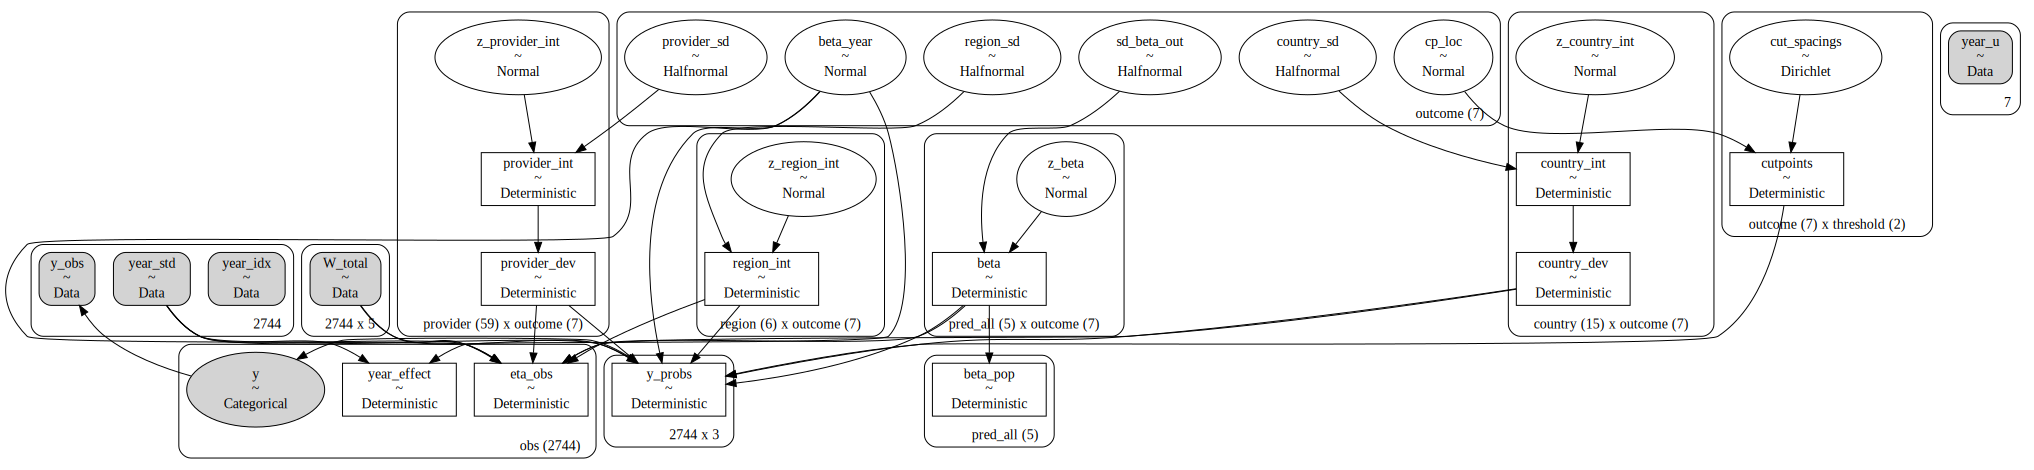

In [18]:
pm.model_to_graphviz(model_1["model"])

In [19]:
with model_1["model"]:
    idata_1 = pm.sample(
        nuts_sampler="nutpie",
        draws=2000,
        tune=1000,
        chains=8,
        cores=8,
        random_seed=2025,
        target_accept=0.99,
        max_treedepth=12,
        mp_ctx="spawn",
    )
    idata_1.extend(pm.sample_posterior_predictive(idata_1, var_names=["y"]))
    idata_1.extend(pm.compute_log_likelihood(idata_1))

/opt/venvs/ml/lib/python3.12/site-packages/pytensor/link/c/cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(


Sampling: [y]


/opt/venvs/ml/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

#### Posterior analysis

In [20]:
summary_1 = az.summary(
    idata_1,
    var_names=None,
    kind="all",
    stat_focus="median",
    hdi_prob=0.95,
    round_to=4,
    skipna=True,
).reset_index(names=["parameter"])

/opt/venvs/ml/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/venvs/ml/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/venvs/ml/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/venvs/ml/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/venvs/ml/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scal

In [21]:
with pd.option_context("display.min_rows", 100, "display.max_rows", 1000):
    display(summary_1.sort_values(["ess_tail", "ess_median"]))

parameter  median     mad  eti_2.5%  eti_97.5%  mcse_median  \
3940         region_sd[1]  0.7030  0.1836    0.2468     1.3286       0.0063   
3947   region_sd_log__[1] -0.3524  0.2608   -1.3992     0.2841       0.0090   
272             cp_loc[1] -1.4432  0.2633   -2.1954    -0.5467       0.0110   
302       cutpoints[1, 1] -0.5474  0.2636   -1.2916     0.3511       0.0105   
301       cutpoints[1, 0] -2.3385  0.2683   -3.1078    -1.4271       0.0107   
550          eta_obs[237]  0.4951  0.2770   -0.2982     1.4169       0.0110   
553          eta_obs[240]  0.4951  0.2770   -0.2982     1.4169       0.0110   
632          eta_obs[319]  0.4951  0.2770   -0.2982     1.4169       0.0110   
634          eta_obs[321]  0.4951  0.2770   -0.2982     1.4169       0.0110   
652          eta_obs[339]  0.4951  0.2770   -0.2982     1.4169       0.0110   
656          eta_obs[343]  0.4951  0.2770   -0.2982     1.4169       0.0110   
812          eta_obs[499]  0.4951  0.2770   -0.2982     1.4169       0.0110   
870          eta_obs[557]  0.4951  0.2770   -0.2982     1.4169       0.0110   
872          eta_obs[559]  0.4951  0.2770   -0.2982     1.4169       0.0110   
883          eta_obs[570]  0.4951  0.2770   -0.2982     1.4169       0.0110   
935          eta_obs[622]  0.4951  0.2770   -0.2982     1.4169       0.0110   
944          eta_obs[631]  0.4951  0.2770   -0.2982     1.4169       0.0110   
946          eta_obs[633]  0.4951  0.2770   -0.2982     1.4169       0.0110   
947          eta_obs[634]  0.4951  0.2770   -0.2982     1.4169       0.0110   
955          eta_obs[642]  0.4951  0.2770   -0.2982     1.4169       0.0110   
957          eta_obs[644]  0.4951  0.2770   -0.2982     1.4169       0.0110   
1138         eta_obs[825]  0.4951  0.2770   -0.2982     1.4169       0.0110   
1184         eta_obs[871]  0.4951  0.2770   -0.2982     1.4169       0.0110   
1193         eta_obs[880]  0.4951  0.2770   -0.2982     1.4169       0.0110   
1305         eta_obs[992]  0.4951  0.2770   -0.2982     1.4169       0.0110   
1306         eta_obs[993]  0.4951  0.2770   -0.2982     1.4169       0.0110   
1312         eta_obs[999]  0.4951  0.2770   -0.2982     1.4169       0.0110   
1359        eta_obs[1046]  0.4951  0.2770   -0.2982     1.4169       0.0110   
1360        eta_obs[1047]  0.4951  0.2770   -0.2982     1.4169       0.0110   
1366        eta_obs[1053]  0.4951  0.2770   -0.2982     1.4169       0.0110   
1378        eta_obs[1065]  0.4951  0.2770   -0.2982     1.4169       0.0110   
1596        eta_obs[1283]  0.4951  0.2770   -0.2982     1.4169       0.0110   
1619        eta_obs[1306]  0.4951  0.2770   -0.2982     1.4169       0.0110   
1620        eta_obs[1307]  0.4951  0.2770   -0.2982     1.4169       0.0110   
1624        eta_obs[1311]  0.4951  0.2770   -0.2982     1.4169       0.0110   
1626        eta_obs[1313]  0.4951  0.2770   -0.2982     1.4169       0.0110   
1628        eta_obs[1315]  0.4951  0.2770   -0.2982     1.4169       0.0110   
1629        eta_obs[1316]  0.4951  0.2770   -0.2982     1.4169       0.0110   
1640        eta_obs[1327]  0.4951  0.2770   -0.2982     1.4169       0.0110   
1641        eta_obs[1328]  0.4951  0.2770   -0.2982     1.4169       0.0110   
1643        eta_obs[1330]  0.4951  0.2770   -0.2982     1.4169       0.0110   
1658        eta_obs[1345]  0.4951  0.2770   -0.2982     1.4169       0.0110   
1662        eta_obs[1349]  0.4951  0.2770   -0.2982     1.4169       0.0110   
1705        eta_obs[1392]  0.4951  0.2770   -0.2982     1.4169       0.0110   
1720        eta_obs[1407]  0.4951  0.2770   -0.2982     1.4169       0.0110   
1722        eta_obs[1409]  0.4951  0.2770   -0.2982     1.4169       0.0110   
1724        eta_obs[1411]  0.4951  0.2770   -0.2982     1.4169       0.0110   
1725        eta_obs[1412]  0.4951  0.2770   -0.2982     1.4169       0.0110   
1727        eta_obs[1414]  0.4951  0.2770   -0.2982     1.4169       0.0110   
1734        eta_obs[1421]  0.4951  0.2770   -0.2982     1.4169    

In [22]:
summary_1.query('parameter.str.match("^beta")')

parameter  median     mad  eti_2.5%  eti_97.5%  mcse_median  \
0        beta[open_c, 0]  0.1737  0.1568   -0.2831     0.6377       0.0020   
1        beta[open_c, 1] -0.3394  0.1389   -0.7469     0.0601       0.0022   
2        beta[open_c, 2]  0.3791  0.2512   -0.3299     1.1240       0.0034   
3        beta[open_c, 3] -0.3669  0.2675   -1.2591     0.3126       0.0047   
4        beta[open_c, 4]  0.7027  0.2104    0.1024     1.3388       0.0029   
5        beta[open_c, 5]  0.0158  0.0922   -0.3816     0.6787       0.0009   
6        beta[open_c, 6] -0.0088  0.0736   -0.5228     0.3557       0.0006   
7      beta[Academia, 0] -0.2177  0.3455   -1.2620     0.7963       0.0039   
8      beta[Academia, 1]  0.0360  0.3916   -1.0815     1.1866       0.0048   
9      beta[Academia, 2]  0.0684  0.4933   -1.3898     1.5690       0.0056   
10     beta[Academia, 3]  1.2253  0.4218    0.1223     2.5221       0.0077   
11     beta[Academia, 4]  0.0914  0.3512   -0.9445     1.1764       0.0043   
12     beta[Academia, 5] -0.0005  0.0906   -0.5478     0.5260       0.0005   
13     beta[Academia, 6] -0.0000  0.0720   -0.4431     0.4531       0.0002   
14   beta[Government, 0]  0.1655  0.3609   -0.8911     1.3329       0.0039   
15   beta[Government, 1] -0.1110  0.4508   -1.3340     1.2274       0.0099   
16   beta[Government, 2]  0.4656  0.4687   -0.8541     1.9060       0.0061   
17   beta[Government, 3] -0.0272  0.3060   -1.0750     0.9956       0.0036   
18   beta[Government, 4]  0.1673  0.3635   -0.8916     1.2972       0.0044   
19   beta[Government, 5]  0.0148  0.0931   -0.4024     0.6944       0.0010   
20   beta[Government, 6] -0.0001  0.0713   -0.4217     0.4499       0.0003   
21    beta[Nonprofit, 0]  0.5176  0.3197   -0.3395     1.5609       0.0036   
22    beta[Nonprofit, 1]  0.3804  0.2666   -0.3656     1.1859       0.0033   
23    beta[Nonprofit, 2]  0.4736  0.3922   -0.6463     1.6708       0.0049   
24    beta[Nonprofit, 3] -0.6027  0.2837   -1.4692     0.0944       0.0043   
25    beta[Nonprofit, 4]  0.0378  0.3426   -1.0116     1.1079       0.0043   
26    beta[Nonprofit, 5] -0.0018  0.0915   -0.5530     0.5216       0.0004   
27    beta[Nonprofit, 6] -0.0025  0.0734   -0.4758     0.4005       0.0004   
28   beta[firstparty, 0] -1.6527  0.1997   -2.2326    -1.0736       0.0025   
29   beta[firstparty, 1] -3.8093  0.1540   -4.2695    -3.3799       0.0020   
30   beta[firstparty, 2] -2.8961  0.2867   -3.7596    -2.1075       0.0040   
31   beta[firstparty, 3] -0.2188  0.2448   -1.0247     0.4201       0.0043   
32   beta[firstparty, 4] -1.5911  0.2434   -2.3222    -0.8866       0.0036   
33   beta[firstparty, 5]  0.0680  0.1064   -0.2076     1.0412       0.0026   
34   beta[firstparty, 6]  0.0023  0.0732   -0.4074     0.4703       0.0004   
35      beta_pop[open_c] -0.0639  0.0847   -0.3130     0.1792       0.0014   
36    beta_pop[Academia]  0.0873  0.2160   -0.5322     0.7123       0.0026   
37  beta_pop[Government]  0.0540  0.2438   -0.6101     0.7828       0.0051   
38   beta_pop[Nonprofit]  0.2994  0.1548   -0.1376     0.7642       0.0019   
39  beta_pop[firstparty] -2.6510  0.0958   -2.9320    -2.3809       0.0013   
40          beta_year[0]  0.1588  0.0748   -0.0626     0.3855       0.0009   
41          beta_year[1] -0.6868  0.0592   -0.8577    -0.5228       0.0008   
42          beta_year[2]  0.3816  0.0852    0.1428     0.6404       0.0011   
43          beta_year[3]  0.0628  0.0889   -0.2018     0.3123       0.0013   
44          beta_year[4] -0.1685  0.0882   -0.4342     0.0922       0.0012   
45          beta_year[5] -0.0686  0.1408   -0.4490     0.3524       0.0018   
46          beta_year[6]  0.0284  0.1378   -0.3710     0.4460       0.0017   

    ess_median    ess_tail   r_hat  
0   20830.4514  12297.0598  1.0003  
1   11135.7692  11551.9500  1.0012  
2   17745.0287  12027.2337  0.9999  
3   11388.4683  13204.7051  1.0002  
4   18692.2584  12536.4351  1.0001  
5   18051.7262  13019.7160  1.0010  
6   20754.3

In [23]:
summary_1_rhat = summary_1.query("r_hat > 1.01").sort_values(["r_hat"], ascending=False)

In [24]:
with pd.option_context("display.min_rows", 200):
    display(summary_1_rhat)

Empty DataFrame
Columns: [parameter, median, mad, eti_2.5%, eti_97.5%, mcse_median, ess_median, ess_tail, r_hat]
Index: []

#### Plots

<Axes: >

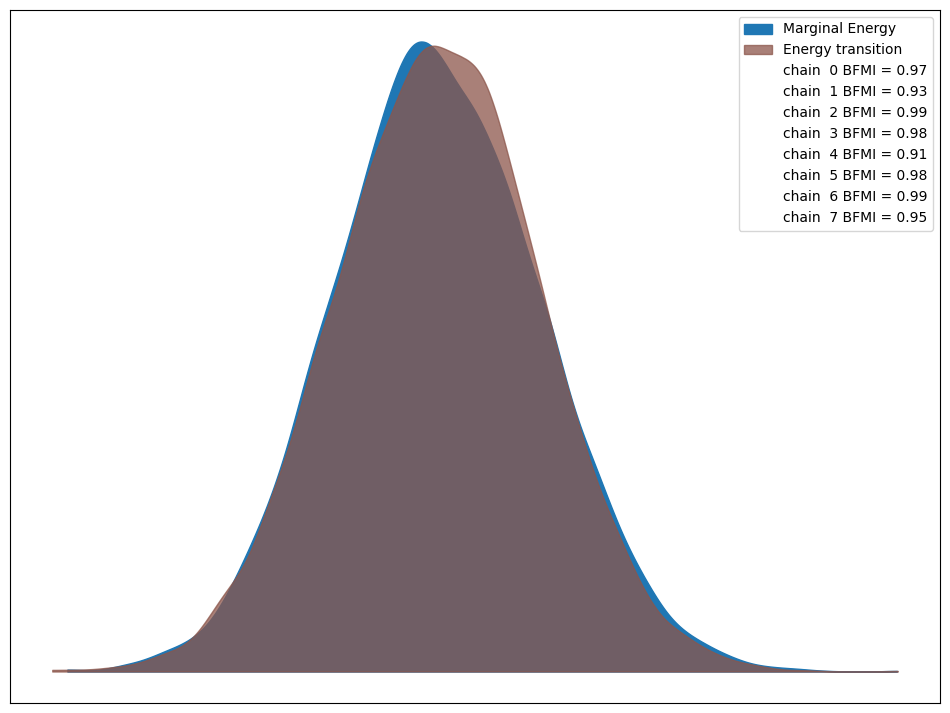

In [25]:
az.plot_energy(idata_1, bfmi=True, figsize=(12, 9))

array([[<Axes: title={'center': 'beta\nopen_c, 0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta\nopen_c, 1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta\nopen_c, 2'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'beta\nopen_c, 3'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta\nopen_c, 4'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta\nopen_c, 5'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'beta\nAcademia, 0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta\nAcademia, 1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta\nAcademia, 2'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'beta\nAcademia, 3'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: titl

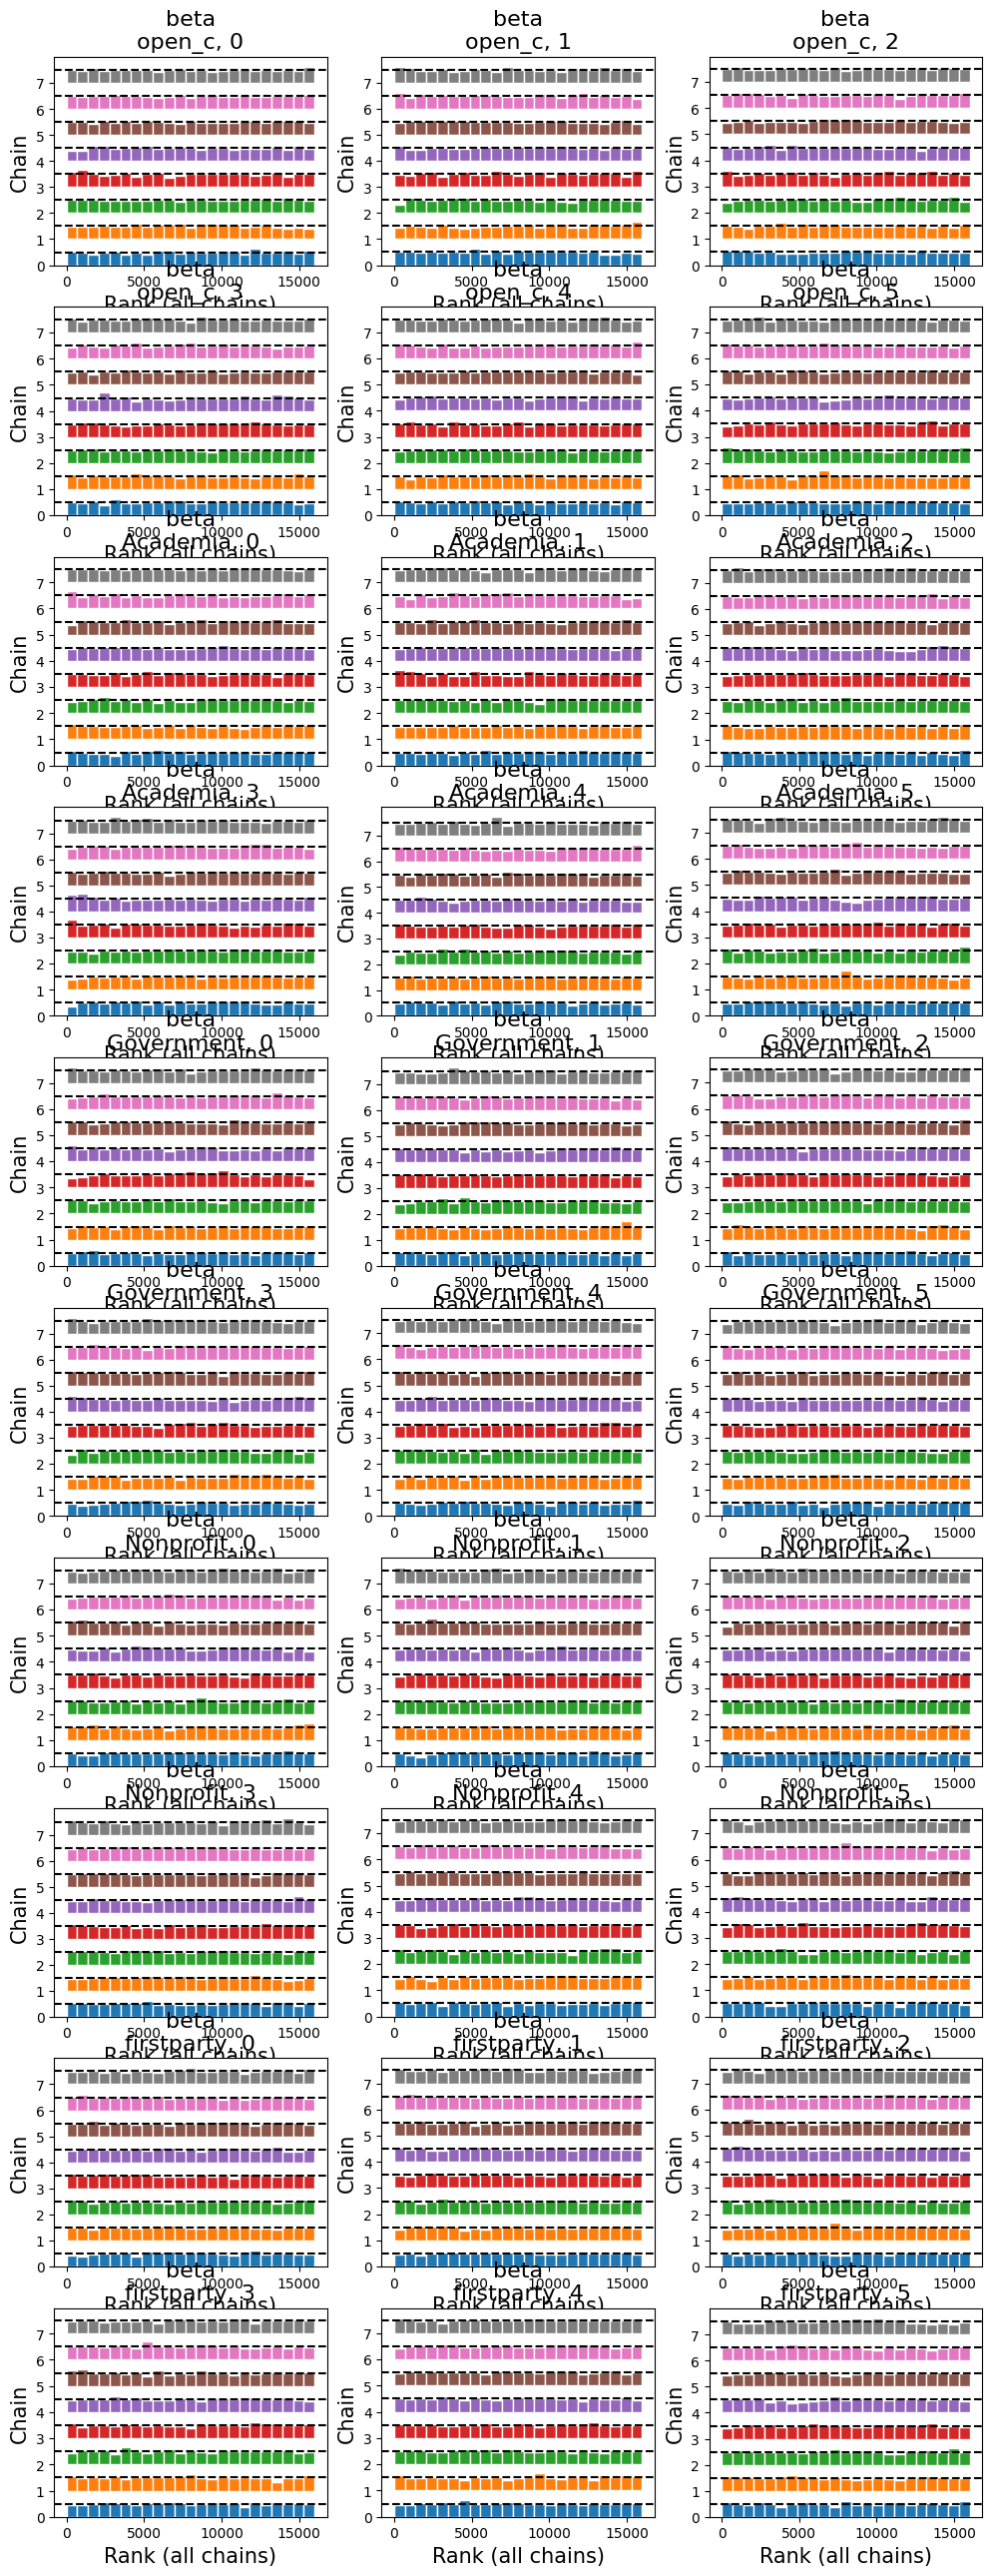

In [27]:
az.plot_rank(
    idata_1, var_names=["beta"], coords={"outcome": np.arange(6)}, figsize=(12, 32)
)

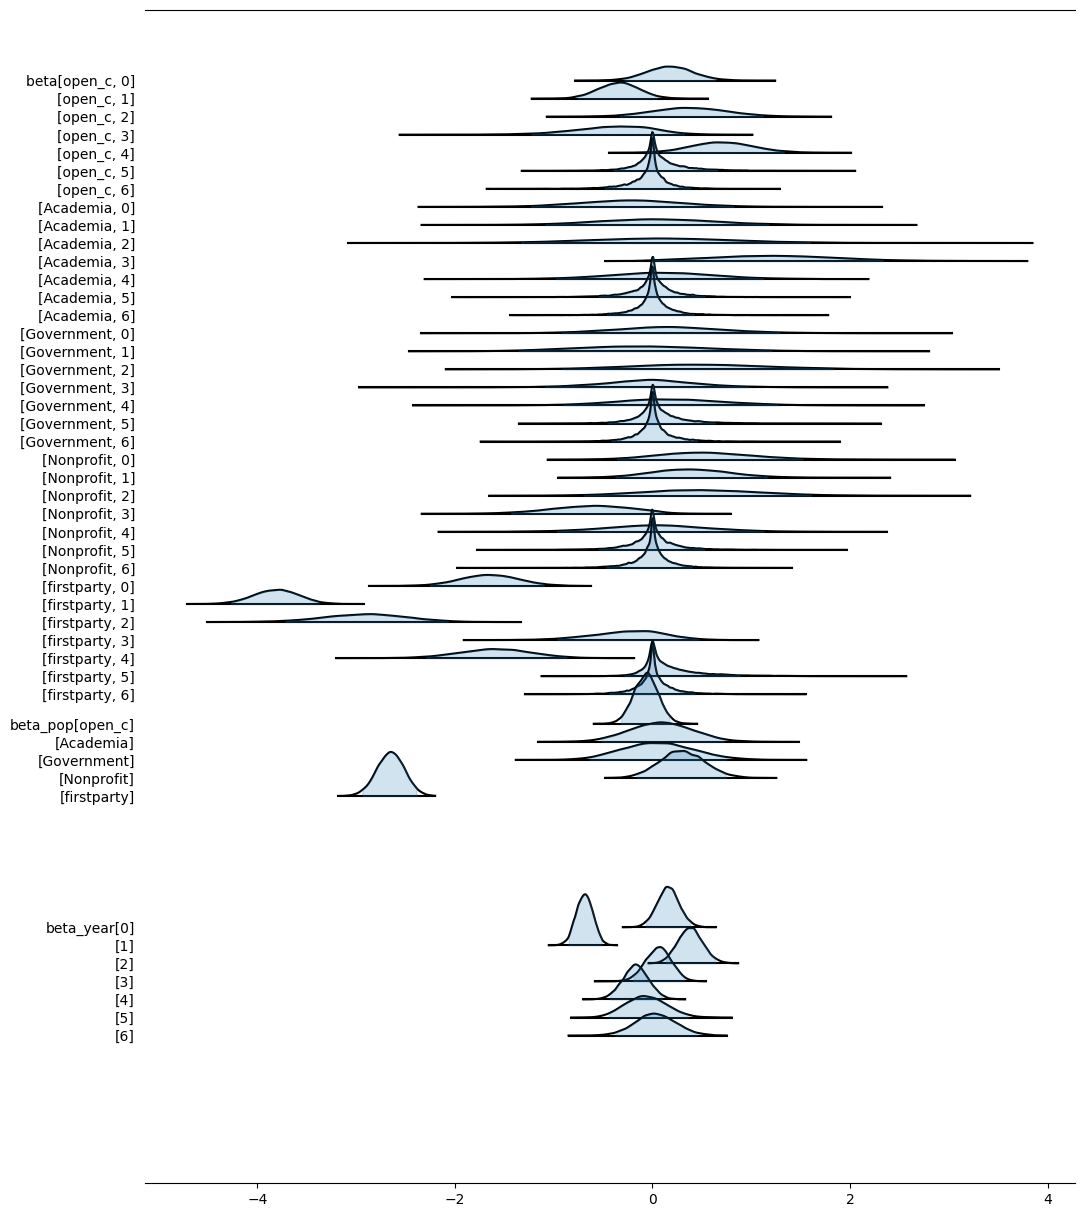

In [28]:
ridge_1_regression = az.plot_forest(
    idata_1,
    # backend="bokeh",
    kind="ridgeplot",
    var_names=["^beta", "^beta_.+"],
    filter_vars="regex",
    combined=True,
    # r_hat=True,
    # ess=True,
    hdi_prob=0.95,
    quartiles=False,
    ridgeplot_alpha=0.2,
    ridgeplot_overlap=1,
    ridgeplot_truncate=False,
)

### Model 2: Model1 + provider-level intercept correlated

In [29]:
model_2 = build_model(
    coords=coords,
    out_idx=out_idx,
    reg_idx=reg_idx,
    cty_idx=cty_idx,
    prov_idx=prov_idx,
    fp_idx=fp_idx,
    W=W,
    y_obs=y_obs,
    K=K,
    link="logit",
    firstparty_role="predictor",
    C2R=C2R,
    P2C=P2C,
    reg_country_counts=reg_country_counts,
    cty_prov_counts=cty_prov_counts,
    intercept_corr={
        "region": False,
        "country": False,
        "provider": True,  # <----- provider intercept correlated
        "firstparty": False,
    },
    slopes={"region": False, "country": False, "provider": False, "firstparty": False},
    slope_corr={
        "region": False,
        "country": False,
        "provider": False,
        "firstparty": False,
    },
    sd_reg_int=0.5,
    sd_cty_dev=0.2,
    sd_prov_dev=0.1,
    sd_fp_int=0.2,
    sd_sigma=0.2,
    # sd_slope=0.5,
    cutpoint_prior="dirichlet",
    dirichlet_center=True,
    separate_slope_sd=False,
    pop_slope_corr=False,
    # Year inputs
    year_std=year_std,
    year_u=year_u,
    year_idx=year_idx,
    year_mode="linear",  # options: "linear" | "spline" | "gp" | None
    sd_year=0.25,
    # keep defaults for spline_df / spline_degree / gp params
    return_components=True,
)

['open_c', 'Academia', 'Government', 'Nonprofit', 'firstparty']


In [30]:
model_2

{'model':          region_sd ~ HalfNormal(0, 0.5)
       z_region_int ~ Normal(0, 1)
         country_sd ~ HalfNormal(0, 0.2)
      z_country_int ~ Normal(0, 1)
      provider_chol ~ _lkjcholeskycov(7, 3, HalfNormal(0, 0.1))
     z_provider_int ~ Normal(0, 1)
        sd_beta_out ~ HalfNormal(0, 0.2)
             z_beta ~ Normal(0, 1)
          beta_year ~ Normal(0, 0.25)
       cut_spacings ~ Dirichlet(f())
             cp_loc ~ Normal(0, 5)
         region_int ~ Deterministic(f(z_region_int, region_sd))
        country_int ~ Deterministic(f(z_country_int, country_sd))
        country_dev ~ Deterministic(f(z_country_int, country_sd))
 provider_chol_corr ~ Deterministic(f(provider_chol))
 provider_chol_stds ~ Deterministic(f(provider_chol))
       provider_int ~ Deterministic(f(z_provider_int, provider_chol))
       provider_dev ~ Deterministic(f(z_provider_int, provider_chol))
               beta ~ Deterministic(f(z_beta, sd_beta_out))
           beta_pop ~ Deterministic(f(z_beta, sd_b

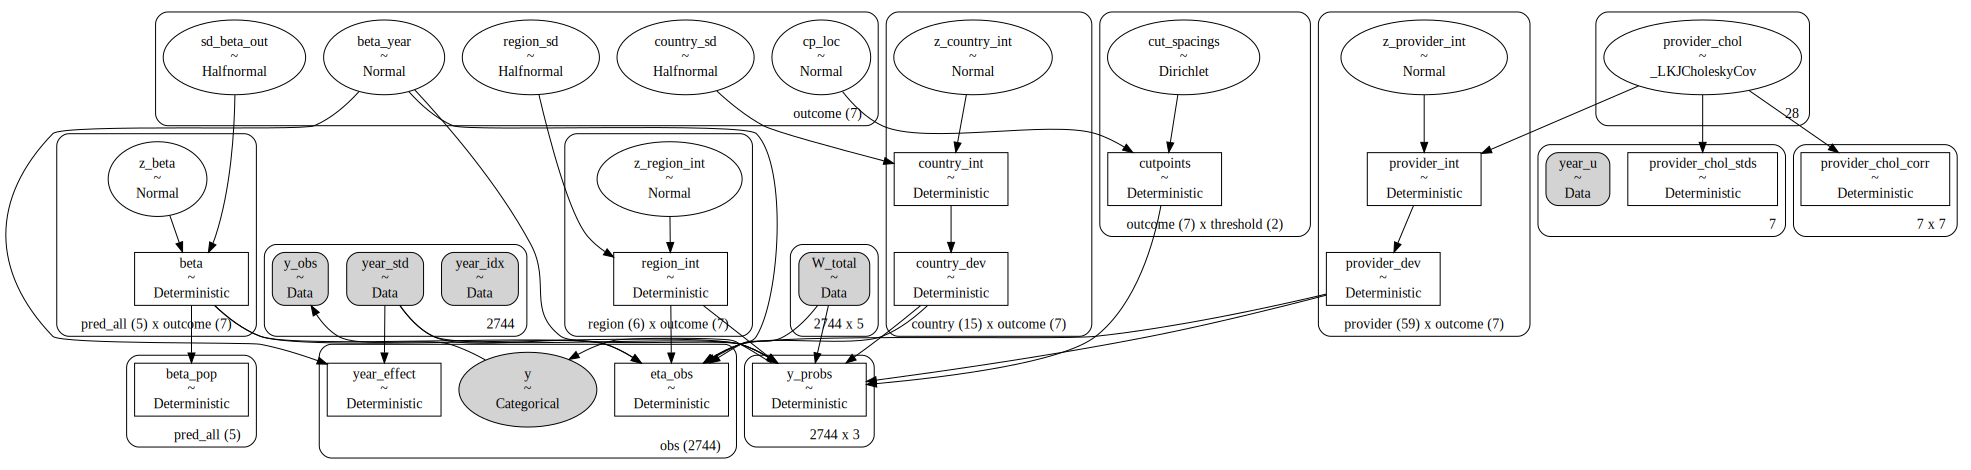

In [31]:
pm.model_to_graphviz(model_2["model"])

In [32]:
with model_2["model"]:
    idata_2 = pm.sample(
        nuts_sampler="nutpie",
        draws=2000,
        tune=1000,
        chains=8,
        cores=8,
        random_seed=2025,
        target_accept=0.99,
        max_treedepth=12,
        mp_ctx="spawn",
    )
    idata_2.extend(pm.sample_posterior_predictive(idata_2, var_names=["y"]))
    idata_2.extend(pm.compute_log_likelihood(idata_2))

Sampling: [y]


/opt/venvs/ml/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

#### Posterior analysis

In [33]:
summary_2 = az.summary(
    idata_2,
    var_names=None,
    kind="all",
    stat_focus="median",
    hdi_prob=0.95,
    round_to=4,
    skipna=True,
).reset_index(names=["parameter"])

/opt/venvs/ml/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/venvs/ml/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/venvs/ml/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/venvs/ml/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/venvs/ml/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scal

In [34]:
with pd.option_context("display.min_rows", 100):
    display(summary_2)

parameter  median     mad  eti_2.5%  eti_97.5%  mcse_median  \
0          beta[open_c, 0]  0.1773  0.1555   -0.2826     0.6299       0.0023   
1          beta[open_c, 1] -0.3404  0.1390   -0.7429     0.0528       0.0026   
2          beta[open_c, 2]  0.3765  0.2506   -0.3358     1.1046       0.0045   
3          beta[open_c, 3] -0.3613  0.2689   -1.2259     0.3010       0.0066   
4          beta[open_c, 4]  0.7043  0.2144    0.1104     1.3363       0.0036   
5          beta[open_c, 5]  0.0166  0.0919   -0.3900     0.6735       0.0013   
6          beta[open_c, 6] -0.0101  0.0748   -0.5367     0.3377       0.0009   
7        beta[Academia, 0] -0.2216  0.3433   -1.2749     0.7833       0.0045   
8        beta[Academia, 1]  0.0402  0.3923   -1.0666     1.2076       0.0063   
9        beta[Academia, 2]  0.0567  0.4973   -1.4103     1.5301       0.0073   
10       beta[Academia, 3]  1.2201  0.4221    0.0697     2.5352       0.0091   
11       beta[Academia, 4]  0.1016  0.3475   -0.9562     1.2001       0.0061   
12       beta[Academia, 5] -0.0006  0.0913   -0.5509     0.5270       0.0005   
13       beta[Academia, 6] -0.0003  0.0729   -0.4212     0.4355       0.0003   
14     beta[Government, 0]  0.1531  0.3571   -0.8818     1.2862       0.0051   
15     beta[Government, 1] -0.1340  0.4354   -1.3512     1.2539       0.0111   
16     beta[Government, 2]  0.4749  0.4712   -0.8587     1.8976       0.0066   
17     beta[Government, 3] -0.0226  0.3057   -1.0582     0.9968       0.0042   
18     beta[Government, 4]  0.1684  0.3595   -0.8801     1.3201       0.0053   
19     beta[Government, 5]  0.0139  0.0942   -0.3945     0.6989       0.0013   
20     beta[Government, 6]  0.0006  0.0743   -0.4246     0.4243       0.0003   
21      beta[Nonprofit, 0]  0.5151  0.3112   -0.3227     1.5404       0.0051   
22      beta[Nonprofit, 1]  0.3833  0.2609   -0.3652     1.1832       0.0046   
23      beta[Nonprofit, 2]  0.4782  0.3952   -0.6508     1.7114       0.0055   
24      beta[Nonprofit, 3] -0.6021  0.2880   -1.4614     0.1058       0.0059   
25      beta[Nonprofit, 4]  0.0467  0.3508   -1.0077     1.1193       0.0046   
26      beta[Nonprofit, 5] -0.0013  0.0902   -0.5449     0.5156       0.0005   
27      beta[Nonprofit, 6] -0.0019  0.0754   -0.4583     0.4021       0.0005   
28     beta[firstparty, 0] -1.6570  0.2009   -2.2318    -1.0703       0.0031   
29     beta[firstparty, 1] -3.8126  0.1543   -4.2718    -3.3648       0.0024   
...                    ...     ...     ...       ...        ...          ...   
15606   z_region_int[1, 5]  0.0085  0.6743   -1.9677     2.0162       0.0099   
15607   z_region_int[1, 6]  0.0108  0.6648   -1.9693     1.9364       0.0088   
15608   z_region_int[2, 0] -0.1209  0.6741   -2.0618     1.8234       0.0086   
15609   z_region_int[2, 1] -1.1946  0.5504   -2.7843     0.4318       0.0110   
15610   z_region_int[2, 2]  0.2012  0.6705   -1.7223     2.1356       0.0111   
15611   z_region_int[2, 3] -0.3378  0.5552   -1.9928     1.2875       0.0094   
15612   z_region_int[2, 4] -0.0775  0.6471   -1.9157     1.8162       0.0096   
15613   z_region_int[2, 5]  0.4938  0.6623   -1.5021     2.3957       0.0090   
15614   z_region_int[2, 6] -0.0143  0.6825   -1.9728     1.9310       0.0087   
15615   z_region_int[3, 0]  0.0767  0.5663   -1.7041     1.7488       0.0122   
15616   z_region_int[3, 1]  0.9501  0.4019   -0.1771     2.1780       0.0159   
15617   z_region_int[3, 2]  0.5725  0.5672   -1.1245     2.2367       0.0132   
15618   z_region_int[3, 3]  0.8356  0.4414   -0.4124     2.1752       0.0131   
15619   z_region_int[3, 4]  0.4100  0.5779   -1.3534     2.0827       0.0131   
15620   z_region_int[3, 5] -0.8962  0.6294   -2.6569     1.0773       0.0126   
15621   z_region_int[3, 6]  0.0980  0.6639   -1.8879     2.0244       0.0097   
15622   z_region_int[4, 0] -0.0031  0.6649   -1.9699     1.9284       0.0088   
15623   z_region_int[4, 1]  0.4353  0.6223   -1.3896     2.2343       0.0101   
15624   z_region_

In [35]:
summary_2_rhat = summary_2.query("r_hat > 1.01").sort_values(["r_hat"], ascending=False)

In [36]:
with pd.option_context("display.min_rows", 100, "display.max_rows", 100):
    display(summary_2_rhat)

parameter  median     mad  eti_2.5%  \
3070                        provider_chol[13] -0.0002  0.0104   -0.0641   
3098  provider_chol_cholesky-cov-packed__[13] -0.0002  0.0104   -0.0641   
3166                    provider_chol_stds[4]  0.0637  0.0365    0.0041   
3071                        provider_chol[14]  0.0503  0.0297    0.0032   
3099  provider_chol_cholesky-cov-packed__[14] -2.9905  0.6241   -5.7502   
3167                    provider_chol_stds[5]  0.0689  0.0394    0.0041   
3074                        provider_chol[17]  0.0001  0.0115   -0.0670   
3102  provider_chol_cholesky-cov-packed__[17]  0.0001  0.0115   -0.0670   
3067                        provider_chol[10]  0.0001  0.0103   -0.0560   
3095  provider_chol_cholesky-cov-packed__[10]  0.0001  0.0103   -0.0560   
3077                        provider_chol[20]  0.0505  0.0298    0.0029   
3105  provider_chol_cholesky-cov-packed__[20] -2.9866  0.6144   -5.8381   
3080                        provider_chol[23] -0.0000  0.0109   -0.0649   
3108  provider_chol_cholesky-cov-packed__[23] -0.0000  0.0109   -0.0649   
3713                      provider_int[18, 5]  0.0001  0.0383   -0.2264   

      eti_97.5%  mcse_median  ess_median   ess_tail   r_hat  
3070     0.0548       0.0002   2493.3516  1079.7834  1.0158  
3098     0.0548       0.0002   2493.3516  1079.7834  1.0158  
3166     0.2101       0.0024    923.4525  1369.0391  1.0157  
3071     0.1763       0.0020   1068.3901  1555.6000  1.0128  
3099    -1.7354       0.0390   1068.3901  1555.6000  1.0128  
3167     0.2230       0.0025   1013.8871   889.1783  1.0126  
3074     0.0630       0.0002   4787.6576  1558.5772  1.0122  
3102     0.0630       0.0002   4787.6576  1558.5772  1.0122  
3067     0.0593       0.0002   2514.3700  1311.3949  1.0115  
3095     0.0593       0.0002   2514.3700  1311.3949  1.0115  
3077     0.1771       0.0017   1205.5304   998.5654  1.0111  
3105    -1.7308       0.0330   1205.5304   998.5654  1.0111  
3080     0.0578       0.0001   3253.0151   858.3250  1.0108  
3108     0.0578       0.0001   3253.0151   858.3250  1.0108  
3713     0.2165       0.0002  14945.0290  5465.3993  1.0103

In [349]:
with model_2["model"]:
    idata_2.extend(pm.compute_log_likelihood(idata_2))
loo_2 = az.loo(idata_2, pointwise=True)
loo_2

/opt/venvs/ml/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Computed from 16000 posterior samples and 2744 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1551.51    37.92
p_loo       48.65        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     2744  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

#### Plots

<Axes: >

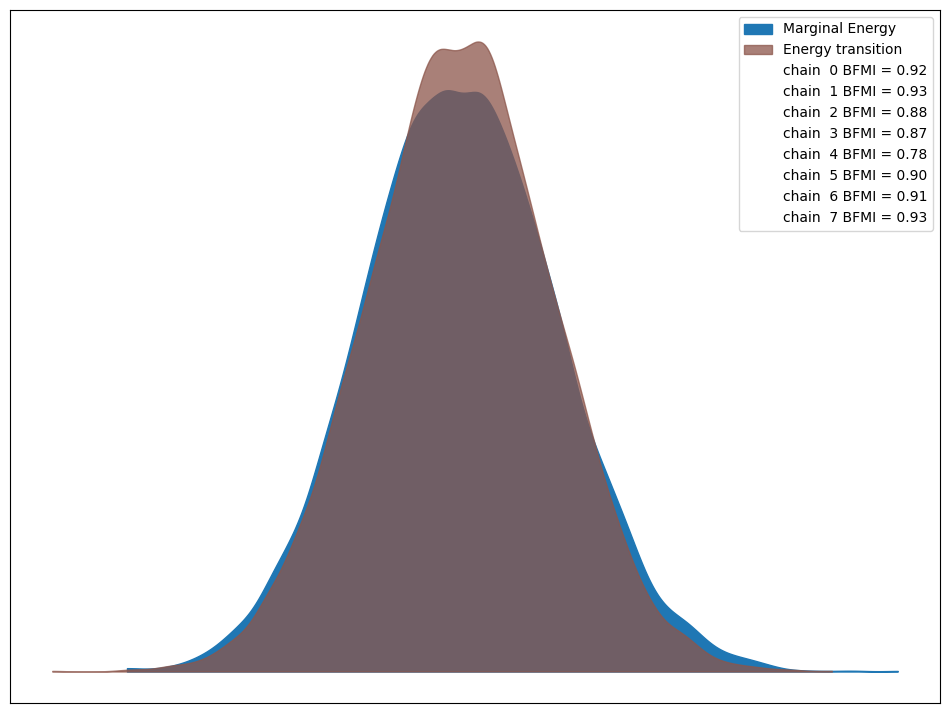

In [37]:
az.plot_energy(idata_2, bfmi=True, figsize=(12, 9))

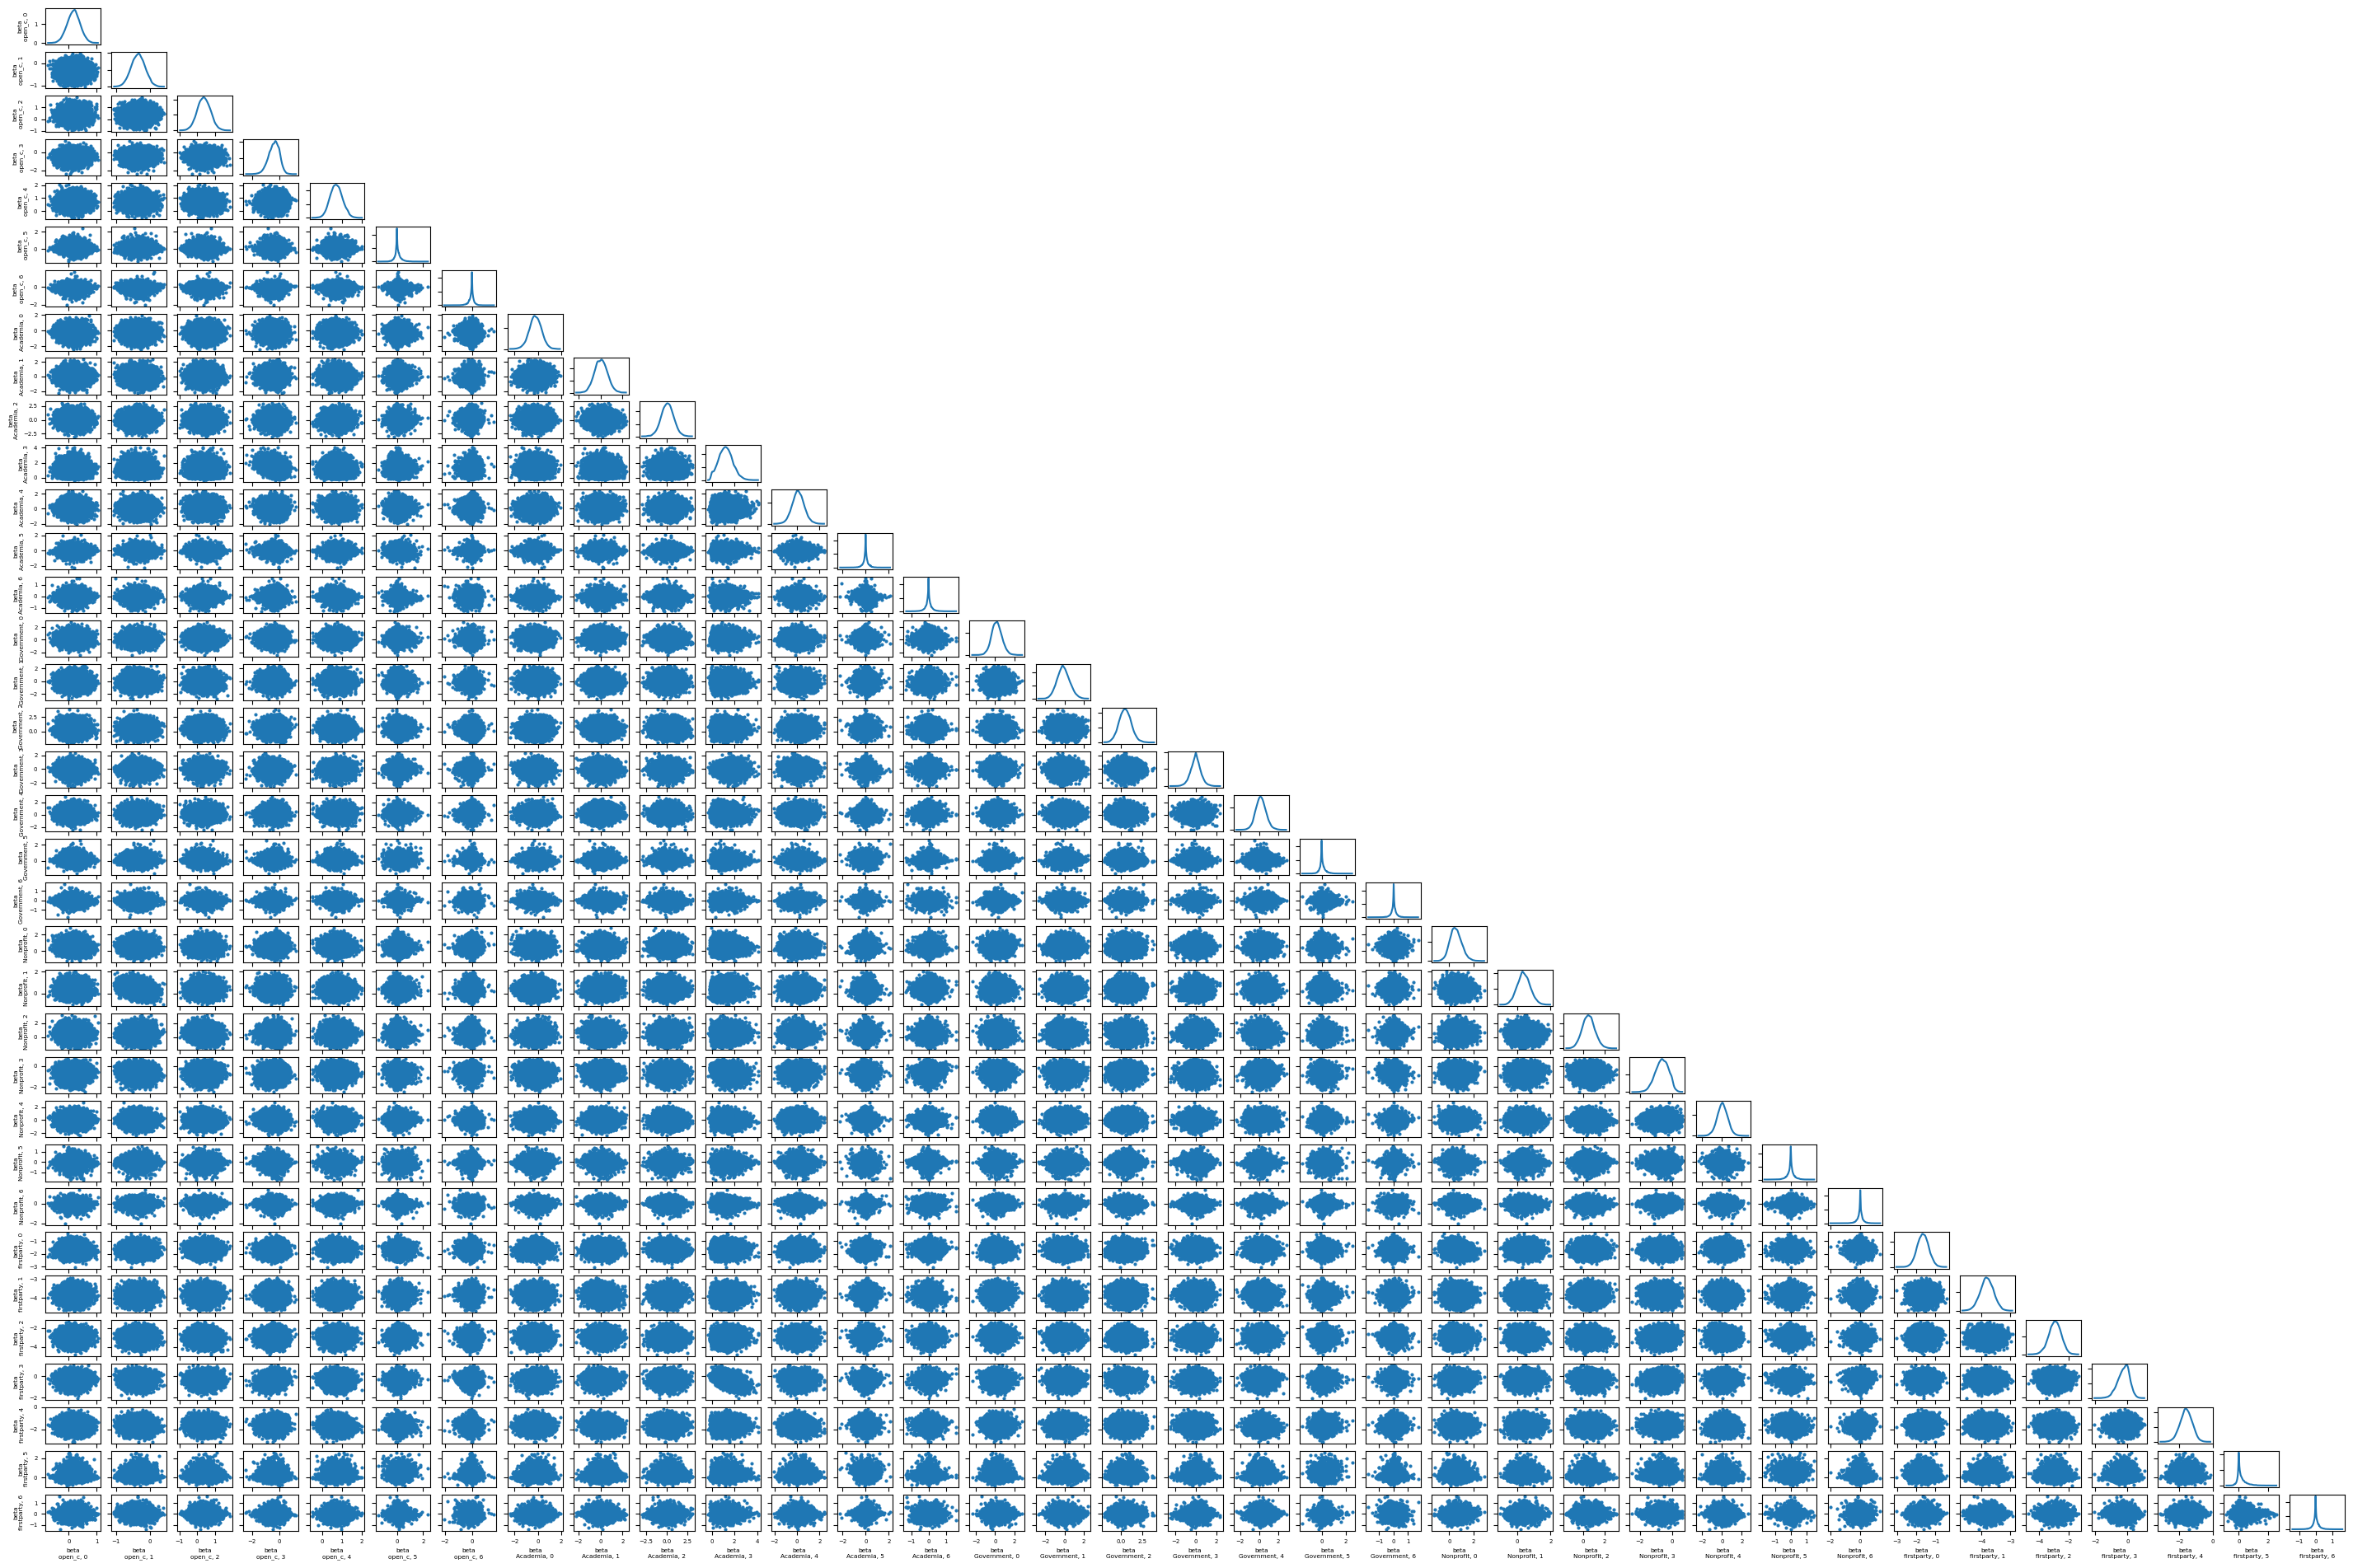

In [38]:
with az.rc_context(rc={"plot.max_subplots": None}):
    az.plot_pair(
        idata_2,
        var_names=["beta"],
        divergences=True,
        # kind="kde",
        marginals=True,
        figsize=(36, 24),
        textsize=5,
        # scatter_kwargs={"alpha": 0.3, "s": 6},
        # divergences_kwargs={"s": 4},
    )

ERROR! Session/line number was not unique in database. History logging moved to new session 66


array([[<Axes: title={'center': 'beta\nopen_c, 0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta\nopen_c, 1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta\nopen_c, 2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta\nopen_c, 3'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'beta\nopen_c, 4'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta\nopen_c, 5'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta\nopen_c, 6'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta\nAcademia, 0'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'beta\nAcademia, 1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta\nAcademia, 2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={

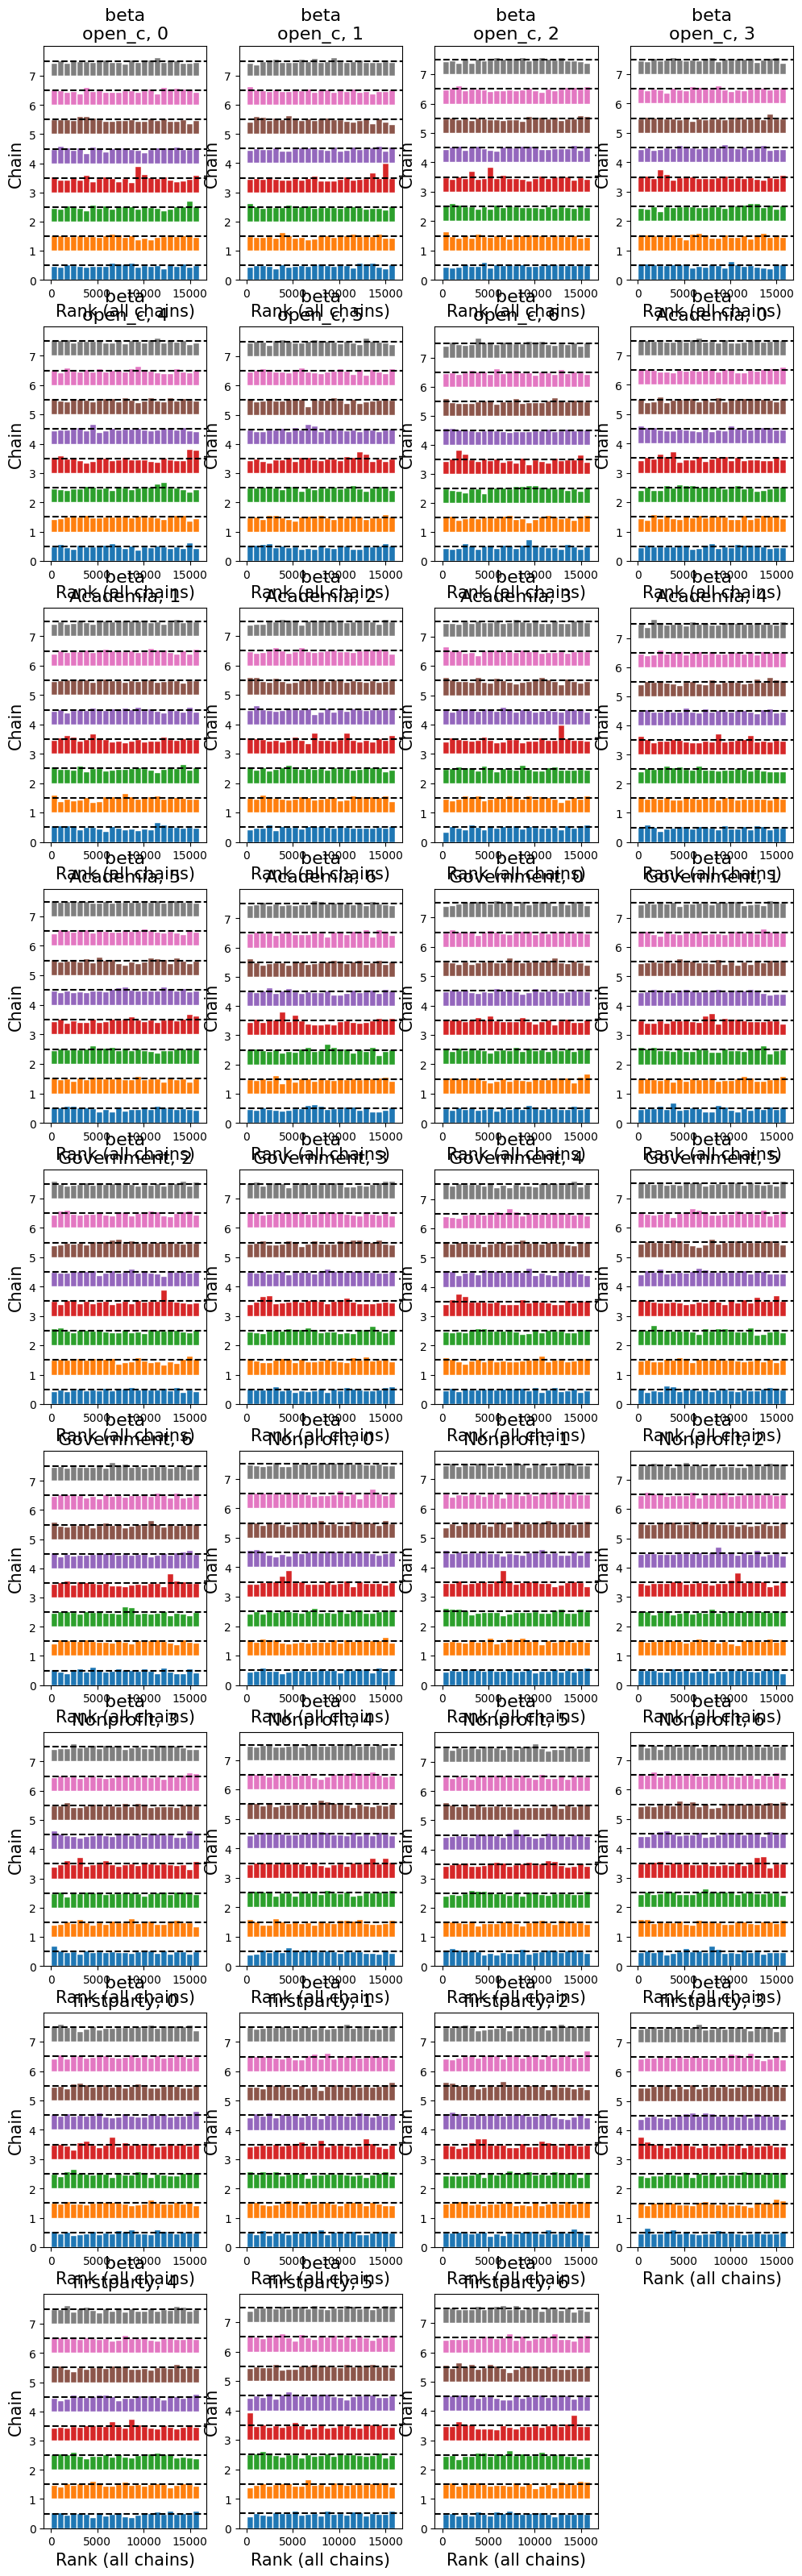

In [90]:
az.plot_rank(idata_2, var_names=["beta"], figsize=(12, 40))

array([<Axes: >], dtype=object)

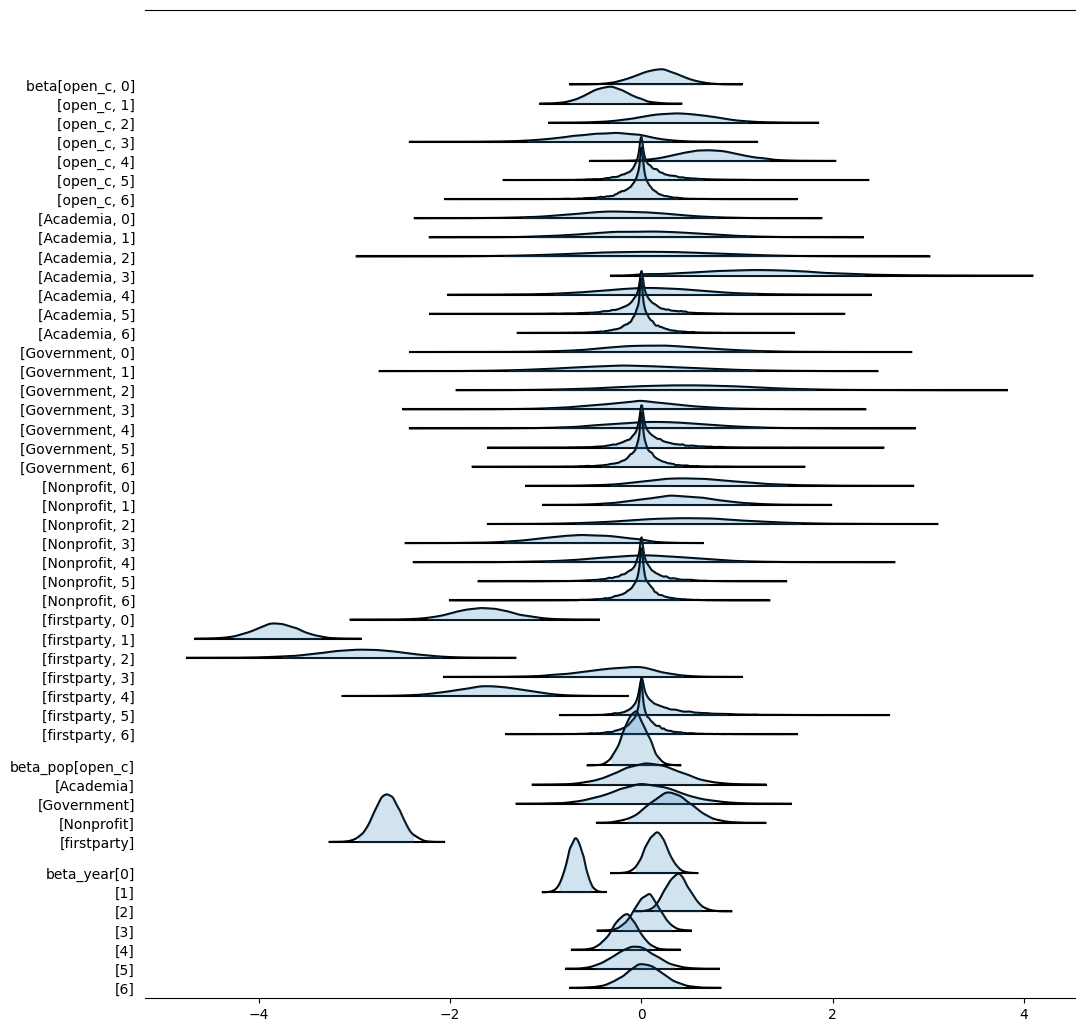

In [92]:
az.plot_forest(
    idata_2,
    kind="ridgeplot",
    var_names="^beta",
    filter_vars="regex",
    combined=True,  # combine chains
    # r_hat=True,
    # ess=True,
    hdi_prob=0.95,
    quartiles=False,
    ridgeplot_alpha=0.2,
    ridgeplot_overlap=1,
    ridgeplot_truncate=False,
)

<Axes: xlabel='y'>

/opt/venvs/ml/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/venvs/ml/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


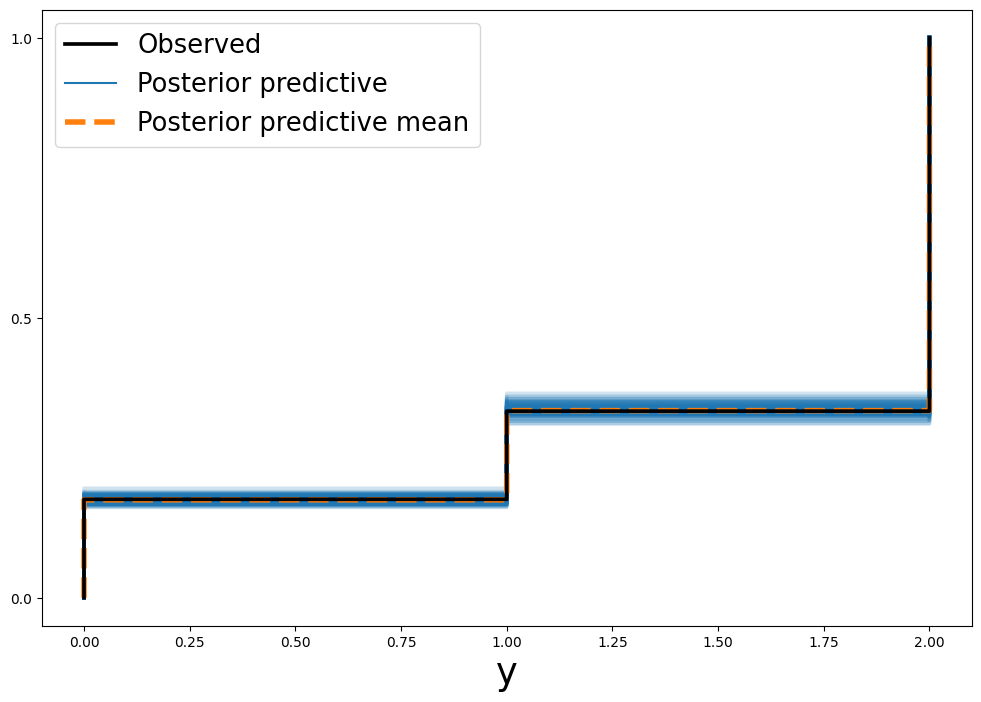

In [82]:
az.plot_ppc(idata_2, kind="cumulative", num_pp_samples=100, figsize=(12, 8))

### Model 3: Model 1 + splines year

In [108]:
model_3 = build_model(
    coords=coords,
    out_idx=out_idx,
    reg_idx=reg_idx,
    cty_idx=cty_idx,
    prov_idx=prov_idx,
    fp_idx=fp_idx,
    W=W,
    y_obs=y_obs,
    K=K,
    link="logit",
    firstparty_role="predictor",
    C2R=C2R,
    P2C=P2C,
    reg_country_counts=reg_country_counts,
    cty_prov_counts=cty_prov_counts,
    intercept_corr={
        "region": False,
        "country": False,
        "provider": False,
        "firstparty": False,
    },
    slopes={"region": False, "country": False, "provider": False, "firstparty": False},
    slope_corr={
        "region": False,
        "country": False,
        "provider": False,
        "firstparty": False,
    },
    lkj_eta=5.0,
    sd_reg_int=0.5,
    sd_cty_dev=0.2,
    sd_prov_dev=0.1,
    sd_fp_int=0.2,
    sd_sigma=0.2,
    # sd_slope=0.5,
    cutpoint_prior="dirichlet",
    dirichlet_center=True,
    separate_slope_sd=False,
    pop_slope_corr=False,
    # Year inputs
    year_std=year_std,
    year_u=year_u,
    year_idx=year_idx,
    year_mode="spline",  # options: "linear" | "spline" | "gp" | None
    sd_year=0.25,
    spline_df=12,
    spline_degree=3,
    # keep defaults for gp params
    return_components=True,
)

In [109]:
model_3

{'model':      region_sd ~ HalfNormal(0, 0.5)
   z_region_int ~ Normal(0, 1)
     country_sd ~ HalfNormal(0, 0.2)
  z_country_int ~ Normal(0, 1)
    provider_sd ~ HalfNormal(0, 0.1)
 z_provider_int ~ Normal(0, 1)
    sd_beta_out ~ HalfNormal(0, 0.2)
         z_beta ~ Normal(0, 1)
   weights_year ~ Normal(0, 0.25)
   cut_spacings ~ Dirichlet(f())
         cp_loc ~ Normal(0, 5)
     region_int ~ Deterministic(f(z_region_int, region_sd))
    country_int ~ Deterministic(f(z_country_int, country_sd))
    country_dev ~ Deterministic(f(z_country_int, country_sd))
   provider_int ~ Deterministic(f(z_provider_int, provider_sd))
   provider_dev ~ Deterministic(f(z_provider_int, provider_sd))
           beta ~ Deterministic(f(z_beta, sd_beta_out))
       beta_pop ~ Deterministic(f(z_beta, sd_beta_out))
    year_effect ~ Deterministic(f(weights_year))
        eta_obs ~ Deterministic(f(weights_year, z_beta, sd_beta_out, z_region_int, z_provider_int, region_sd, provider_sd, z_country_int, country_sd

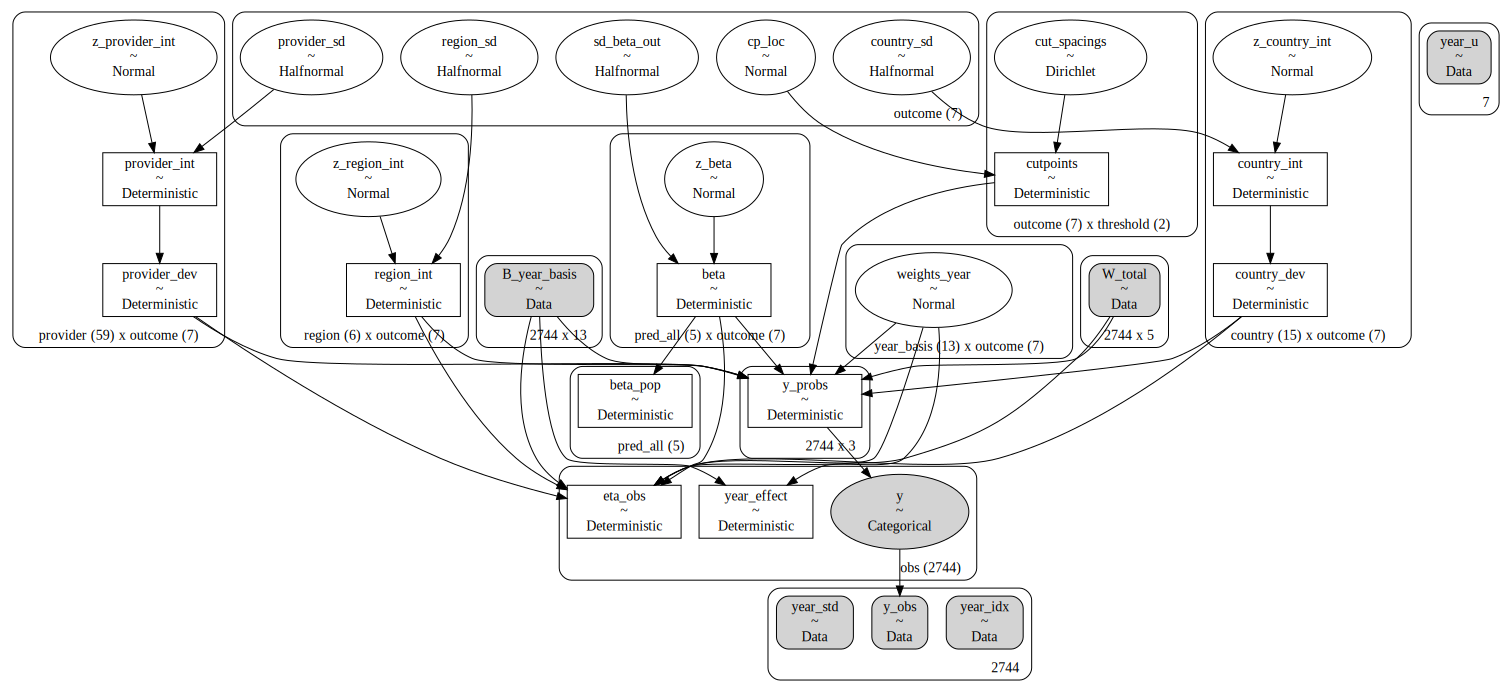

In [110]:
pm.model_to_graphviz(model_3["model"])

In [111]:
with model_3["model"]:
    idata_3 = pm.sample(
        nuts_sampler="nutpie",
        draws=2000,
        tune=1000,
        chains=8,
        cores=8,
        random_seed=2025,
        target_accept=0.99,
        max_treedepth=12,
        mp_ctx="spawn",
    )
    idata_3.extend(pm.sample_posterior_predictive(idata_3, var_names=["y"]))
    idata_3.extend(pm.compute_log_likelihood(idata_3))

Sampling: [y]


/opt/venvs/ml/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

#### Posterior analysis

In [112]:
summary_3 = az.summary(
    idata_3,
    var_names=None,
    kind="all",
    stat_focus="median",
    hdi_prob=0.95,
    round_to=4,
    skipna=True,
).reset_index(names=["parameter"])

/opt/venvs/ml/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/venvs/ml/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/venvs/ml/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/venvs/ml/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/venvs/ml/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scal

In [113]:
with pd.option_context("display.min_rows", 100):
    display(summary_3)

parameter  median     mad  eti_2.5%  eti_97.5%  mcse_median  \
0          beta[open_c, 0]  0.1854  0.1573   -0.2726     0.6390       0.0023   
1          beta[open_c, 1] -0.3548  0.1387   -0.7450     0.0402       0.0029   
2          beta[open_c, 2]  0.4027  0.2403   -0.2999     1.1427       0.0032   
3          beta[open_c, 3] -0.3565  0.2676   -1.2231     0.3206       0.0050   
4          beta[open_c, 4]  0.6712  0.2080    0.0734     1.2967       0.0034   
5          beta[open_c, 5]  0.0172  0.0936   -0.3864     0.6764       0.0012   
6          beta[open_c, 6] -0.0094  0.0738   -0.5498     0.3477       0.0008   
7        beta[Academia, 0] -0.1993  0.3455   -1.2547     0.8372       0.0041   
8        beta[Academia, 1] -0.0229  0.3783   -1.1200     1.1334       0.0048   
9        beta[Academia, 2]  0.0524  0.5164   -1.4689     1.6198       0.0059   
10       beta[Academia, 3]  1.2836  0.4145    0.1511     2.5415       0.0071   
11       beta[Academia, 4]  0.0854  0.3410   -0.9284     1.1694       0.0043   
12       beta[Academia, 5] -0.0007  0.0961   -0.5504     0.5377       0.0004   
13       beta[Academia, 6] -0.0003  0.0741   -0.4690     0.4381       0.0003   
14     beta[Government, 0]  0.1767  0.3636   -0.8877     1.3231       0.0043   
15     beta[Government, 1] -0.0970  0.4293   -1.2809     1.1791       0.0088   
16     beta[Government, 2]  0.4890  0.4823   -0.8910     1.9506       0.0065   
17     beta[Government, 3] -0.0238  0.3137   -1.1140     1.0125       0.0037   
18     beta[Government, 4]  0.1665  0.3522   -0.8618     1.3022       0.0041   
19     beta[Government, 5]  0.0177  0.0958   -0.4188     0.6932       0.0011   
20     beta[Government, 6] -0.0001  0.0750   -0.4370     0.4504       0.0003   
21      beta[Nonprofit, 0]  0.4927  0.3222   -0.3785     1.5496       0.0045   
22      beta[Nonprofit, 1]  0.4713  0.2634   -0.2548     1.2545       0.0034   
23      beta[Nonprofit, 2]  0.2175  0.4025   -0.8959     1.4548       0.0045   
24      beta[Nonprofit, 3] -0.6103  0.2746   -1.4701     0.0863       0.0049   
25      beta[Nonprofit, 4]  0.0974  0.3396   -0.9020     1.1982       0.0042   
26      beta[Nonprofit, 5] -0.0006  0.0939   -0.5628     0.5232       0.0004   
27      beta[Nonprofit, 6] -0.0028  0.0737   -0.4766     0.4061       0.0005   
28     beta[firstparty, 0] -1.7393  0.1882   -2.2882    -1.1931       0.0022   
29     beta[firstparty, 1] -3.5276  0.1425   -3.9568    -3.1186       0.0020   
...                    ...     ...     ...       ...        ...          ...   
15592   z_region_int[1, 5] -0.0112  0.6809   -1.9799     1.9457       0.0070   
15593   z_region_int[1, 6] -0.0034  0.6730   -1.9836     1.9980       0.0097   
15594   z_region_int[2, 0] -0.1217  0.6759   -2.0881     1.8544       0.0096   
15595   z_region_int[2, 1] -1.1260  0.5506   -2.7224     0.5888       0.0091   
15596   z_region_int[2, 2]  0.1478  0.6557   -1.7927     2.1181       0.0076   
15597   z_region_int[2, 3] -0.3563  0.5615   -1.9969     1.3078       0.0078   
15598   z_region_int[2, 4] -0.0744  0.6561   -1.9860     1.8219       0.0074   
15599   z_region_int[2, 5]  0.4902  0.6799   -1.5225     2.3961       0.0084   
15600   z_region_int[2, 6] -0.0028  0.6632   -1.9091     1.9199       0.0088   
15601   z_region_int[3, 0]  0.0772  0.5893   -1.7187     1.7668       0.0120   
15602   z_region_int[3, 1]  0.9392  0.3982   -0.2114     2.1656       0.0154   
15603   z_region_int[3, 2]  0.6276  0.5594   -1.0950     2.2576       0.0121   
15604   z_region_int[3, 3]  0.8615  0.4365   -0.3968     2.1936       0.0116   
15605   z_region_int[3, 4]  0.3827  0.5742   -1.3784     2.0428       0.0119   
15606   z_region_int[3, 5] -0.8605  0.6316   -2.6610     1.1368       0.0110   
15607   z_region_int[3, 6]  0.1004  0.6719   -1.8274     2.0120       0.0107   
15608   z_region_int[4, 0]  0.0109  0.6851   -1.9454     1.9674       0.0077   
15609   z_region_int[4, 1]  0.4150  0.6390   -1.4510     2.2246       0.0096   
15610   z_region_

In [114]:
summary_3_rhat = summary_3.query("r_hat > 1.01").sort_values(["r_hat"], ascending=False)

In [115]:
with pd.option_context("display.min_rows", 100, "display.max_rows", 100):
    display(summary_3_rhat)

parameter  median     mad  eti_2.5%  eti_97.5%  mcse_median  \
265        cp_loc[1] -1.0419  0.2988   -1.8757    -0.0659       0.0111   
295  cutpoints[1, 1] -0.1610  0.2995   -0.9985     0.8195       0.0128   
294  cutpoints[1, 0] -1.9235  0.3030   -2.7680    -0.9364       0.0121   

     ess_median   ess_tail   r_hat  
265   2098.2977  2758.7876  1.0109  
295   2113.8556  2780.4758  1.0108  
294   2110.7304  2927.9390  1.0107

In [350]:
with model_3["model"]:
    idata_3.extend(pm.compute_log_likelihood(idata_3))
loo_3 = az.loo(idata_3, pointwise=True)
loo_3

/opt/venvs/ml/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Computed from 16000 posterior samples and 2744 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1551.92    37.65
p_loo       44.95        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     2744  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

#### Plots

In [127]:
ridge_params = {
    "kind": "ridgeplot",
    "combined": True,
    "hdi_prob": 0.95,
    "ridgeplot_quantiles": [0.5],
    "quartiles": False,
    "ridgeplot_alpha": 0.2,
    "ridgeplot_overlap": 1,
    "ridgeplot_truncate": False,
}
# Example usage (optional):
# az.plot_forest(idata_3, var_names="^beta", filter_vars="regex", **ridge_params)}

Saved forest plot figure to model3_forest_slopes.pdf


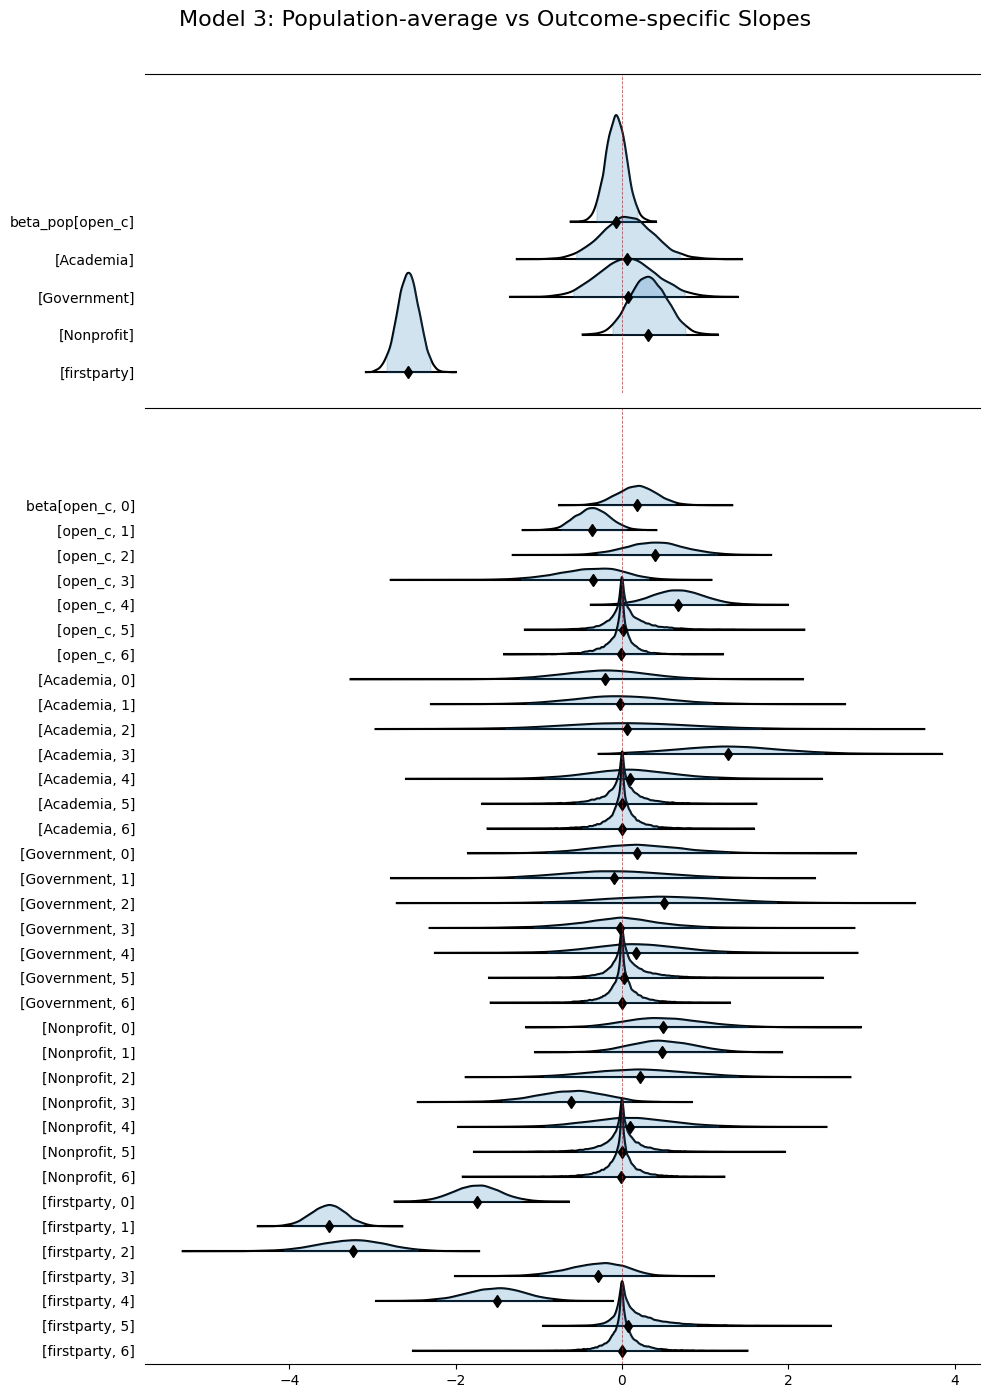

In [158]:
# Create two separate forest plots with shared horizontal axis (x) and no individual axis titles, then save to PDF
fig, axes = plt.subplots(
    2,
    1,
    sharex=True,
    figsize=(10, 14),
    gridspec_kw={"height_ratios": [1, 3]},
)

fig.suptitle(
    "Model 3: Population-average vs Outcome-specific Slopes", fontsize=16, y=0.995
)

# Top: population-average slopes (beta_pop) if present
if any(k.startswith("beta_pop") for k in idata_3.posterior.data_vars):
    az.plot_forest(idata_3, var_names=["beta_pop"], ax=axes[0], **ridge_params)
    axes[0].tick_params(axis="x", which="both", bottom=False, labelbottom=False)
    if "bottom" in axes[0].spines:
        axes[0].spines["bottom"].set_visible(False)
else:
    axes[0].text(0.5, 0.5, "beta_pop not found", ha="center", va="center", fontsize=12)
    axes[0].axis("off")

# Bottom: outcome-specific slopes (beta)
az.plot_forest(idata_3, var_names=["beta"], ax=axes[1], **ridge_params)

for ax in axes:
    ax.axvline(0, color="red", alpha=0.75, linestyle="--", linewidth=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.985])

# Save to PDF
pdf_path = "model3_forest_slopes.pdf"
fig.savefig(pdf_path, dpi=300, bbox_inches="tight")
print(f"Saved forest plot figure to {pdf_path}")

In [154]:
# 1) sanity checks
assert "posterior_predictive" in idata_3.groups()
assert "y" in idata_3.observed_data and "y" in idata_3.posterior_predictive

# 2) figure out the observation dimension name (often 'obs')
obs_dim = idata_3.observed_data["y"].dims[0]
n_obs = idata_3.observed_data["y"].sizes[obs_dim]

# 3) ensure out_idx aligns with y
out_idx = np.asarray(out_idx)
assert out_idx.shape[0] == n_obs

for j in range(7):
    print(f"outcome {j} count:", np.sum(out_idx == j))

outcome 0 count: 431
outcome 1 count: 1359
outcome 2 count: 371
outcome 3 count: 189
outcome 4 count: 184
outcome 5 count: 201
outcome 6 count: 9


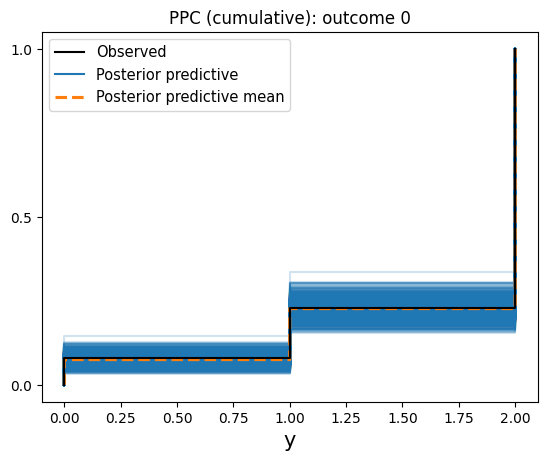

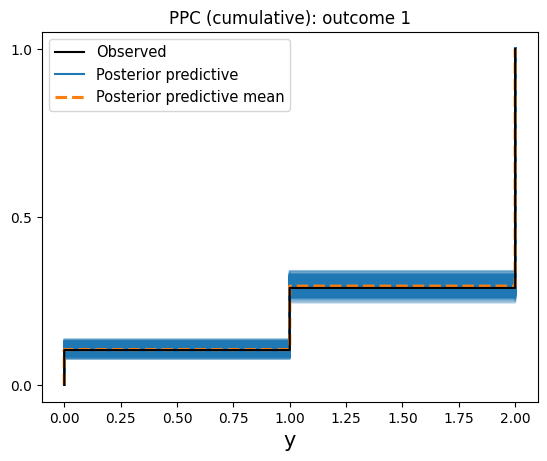

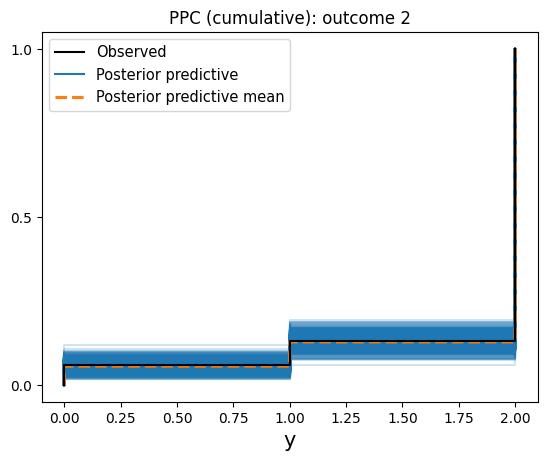

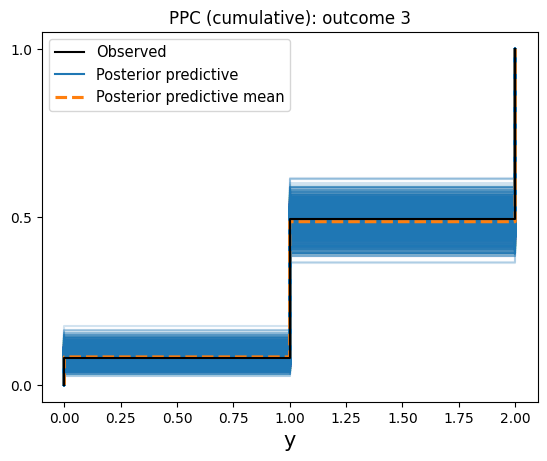

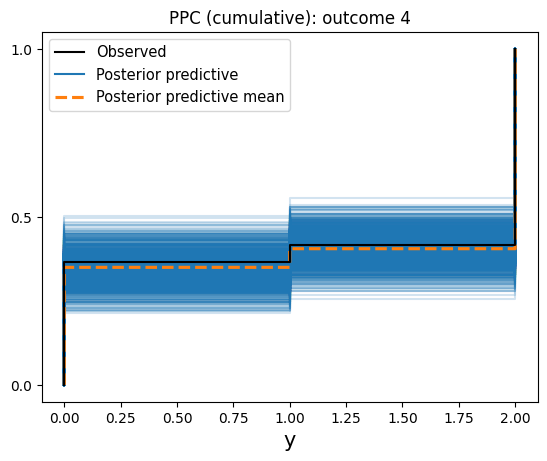

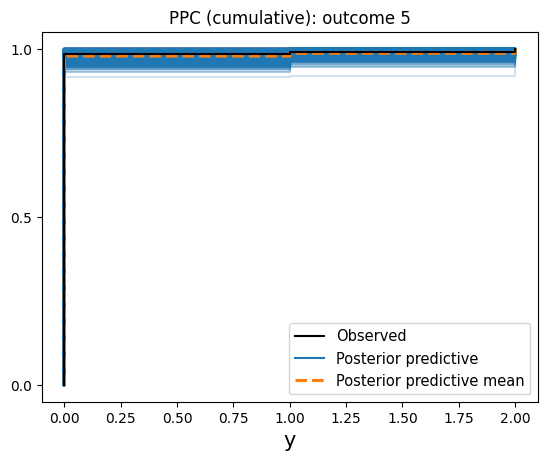

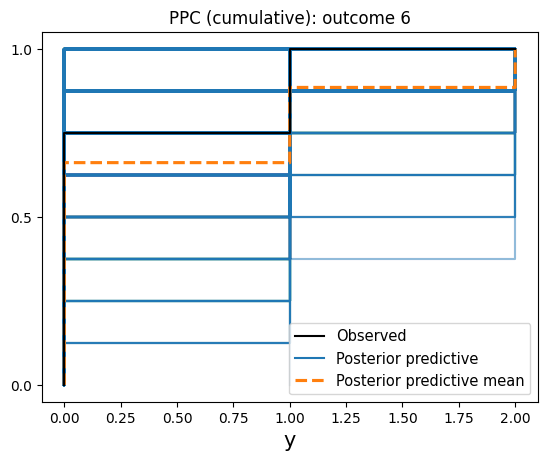

In [157]:
# loop and slice BOTH groups by the obs dimension
for j in range(7):
    idx = np.flatnonzero(out_idx == j)
    if idx.size == 0:
        continue

    # IMPORTANT: indexer goes as a top-level kwarg, and we tell ArviZ which groups
    idata_j = idata_3.isel(
        groups=["observed_data", "posterior_predictive"], **{obs_dim: idx}
    )

    az.plot_ppc(
        idata_j,
        group="posterior",
        var_names=["y"],
        kind="cumulative",
        num_pp_samples=1000,
    )
    plt.title(f"PPC (cumulative): outcome {j}")
    plt.show()  # Global + per-outcome PPC grid (cumulative) and save to PDF
from matplotlib.backends.backend_pdf import PdfPages

pdf_path_grid = "model3_ppc_grid.pdf"

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

# 0: Global cumulative PPC
az.plot_ppc(
    idata_3,
    group="posterior",
    var_names=["y"],
    kind="cumulative",
    num_pp_samples=500,
    ax=axes[0],
)
axes[0].set_title("All outcomes (cumulative)", fontsize=11)

# Outcome-specific PPCs
plot_idx = 1
for j in range(7):
    if plot_idx >= len(axes):
        break
    idx = np.flatnonzero(out_idx == j)
    if idx.size == 0:
        continue
    idata_j = idata_3.isel(
        groups=["observed_data", "posterior_predictive"], **{obs_dim: idx}
    )
    az.plot_ppc(
        idata_j,
        group="posterior",
        var_names=["y"],
        kind="cumulative",
        num_pp_samples=500,
        ax=axes[plot_idx],
    )
    axes[plot_idx].set_title(f"Outcome {j}", fontsize=11)
    plot_idx += 1

# Turn off any unused axes
for k in range(plot_idx, len(axes)):
    axes[k].axis("off")

plt.tight_layout()
fig.savefig(pdf_path_grid, dpi=300, bbox_inches="tight")
print(f"Saved PPC grid to {pdf_path_grid}")

### Model 4: Model 3 + population slopes correlated

In [270]:
model_4 = build_model(
    coords=coords,
    out_idx=out_idx,
    reg_idx=reg_idx,
    cty_idx=cty_idx,
    prov_idx=prov_idx,
    fp_idx=fp_idx,
    W=W,
    y_obs=y_obs,
    K=K,
    link="logit",
    firstparty_role="predictor",
    C2R=C2R,
    P2C=P2C,
    reg_country_counts=reg_country_counts,
    cty_prov_counts=cty_prov_counts,
    intercept_corr={
        "region": False,
        "country": False,
        "provider": False,
        "firstparty": False,
    },
    slopes={"region": False, "country": False, "provider": False, "firstparty": False},
    slope_corr={
        "region": False,
        "country": False,
        "provider": False,
        "firstparty": False,
    },
    lkj_eta=5.0,
    sd_reg_int=0.5,
    sd_cty_dev=0.2,
    sd_prov_dev=0.1,
    sd_fp_int=0.2,
    sd_sigma=0.2,
    # sd_slope=0.5,
    cutpoint_prior="dirichlet",
    dirichlet_center=True,
    separate_slope_sd=False,
    pop_slope_corr=True,  # <----- population slopes correlated across outcomes
    # Year inputs
    year_std=year_std,
    year_u=year_u,
    year_idx=year_idx,
    year_mode="spline",  # options: "linear" | "spline" | "gp" | None
    sd_year=0.25,
    spline_df=12,
    spline_degree=3,
    # keep defaults for gp params
    return_components=True,
)

In [271]:
model_4

{'model':      region_sd ~ HalfNormal(0, 0.5)
   z_region_int ~ Normal(0, 1)
     country_sd ~ HalfNormal(0, 0.2)
  z_country_int ~ Normal(0, 1)
    provider_sd ~ HalfNormal(0, 0.1)
 z_provider_int ~ Normal(0, 1)
      beta_chol ~ _lkjcholeskycov(7, 5, HalfNormal(0, 0.2))
         z_beta ~ Normal(0, 1)
   weights_year ~ Normal(0, 0.25)
   cut_spacings ~ Dirichlet(f())
         cp_loc ~ Normal(0, 5)
     region_int ~ Deterministic(f(z_region_int, region_sd))
    country_int ~ Deterministic(f(z_country_int, country_sd))
    country_dev ~ Deterministic(f(z_country_int, country_sd))
   provider_int ~ Deterministic(f(z_provider_int, provider_sd))
   provider_dev ~ Deterministic(f(z_provider_int, provider_sd))
 beta_chol_corr ~ Deterministic(f(beta_chol))
 beta_chol_stds ~ Deterministic(f(beta_chol))
           beta ~ Deterministic(f(z_beta, beta_chol))
       beta_pop ~ Deterministic(f(z_beta, beta_chol))
    year_effect ~ Deterministic(f(weights_year))
        eta_obs ~ Deterministic(f(wei

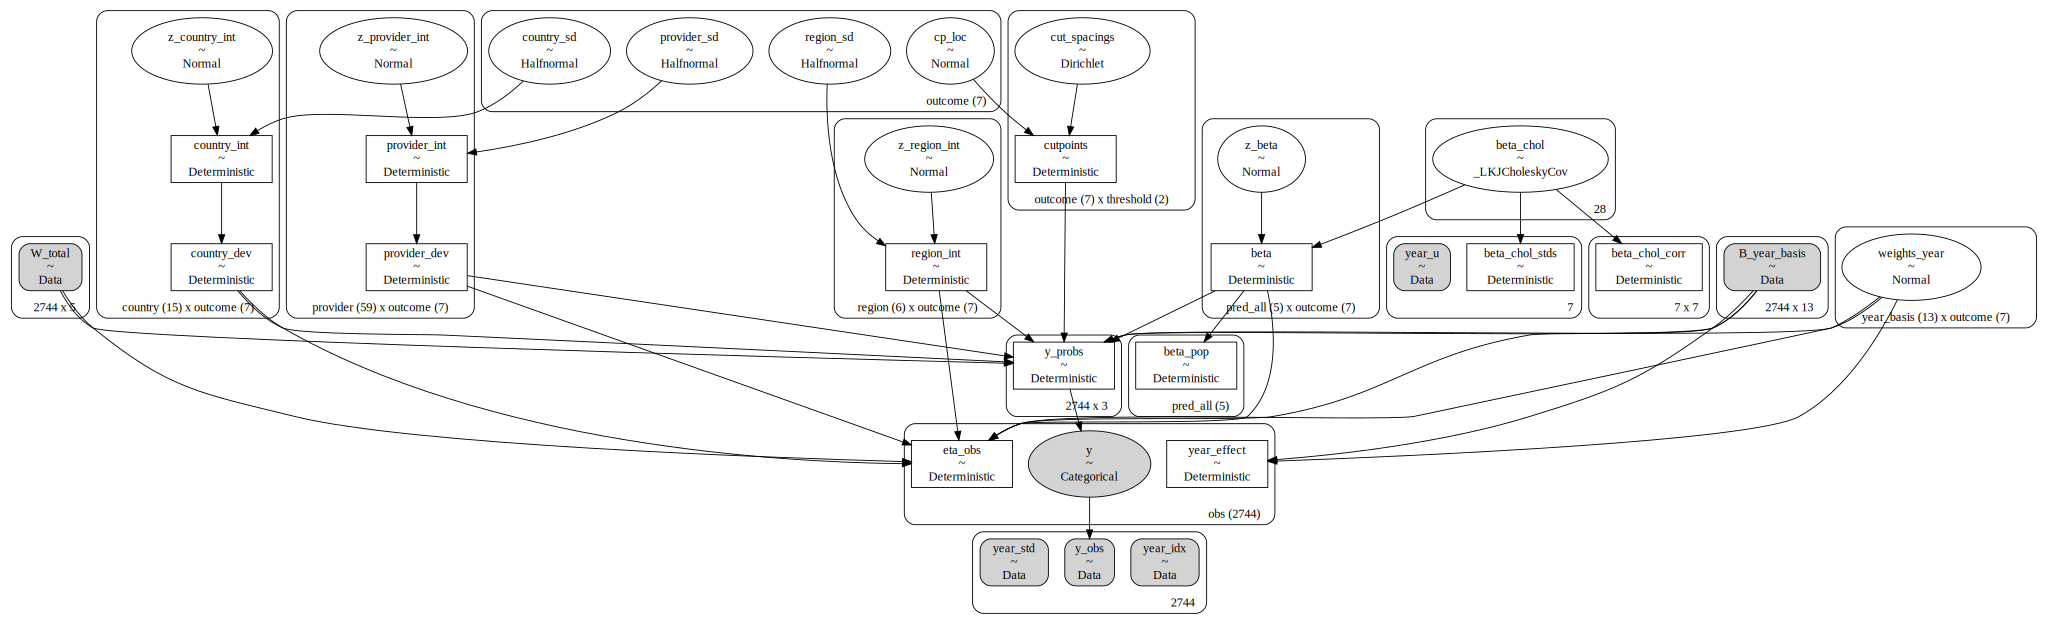

In [272]:
pm.model_to_graphviz(model_4["model"])

In [273]:
with model_4["model"]:
    idata_4 = pm.sample(
        nuts_sampler="nutpie",
        draws=2000,
        tune=1000,
        chains=8,
        cores=8,
        random_seed=2025,
        target_accept=0.99,
        max_treedepth=12,
        mp_ctx="spawn",
    )
    idata_4.extend(pm.sample_posterior_predictive(idata_4, var_names=["y"]))
    idata_4.extend(pm.compute_log_likelihood(idata_4))

/opt/venvs/ml/lib/python3.12/site-packages/nutpie/compile_pymc.py:865: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', True, aligned=True))
  return inner(x, *_shared_tuple)


Sampling: [y]


/opt/venvs/ml/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

#### Posterior analysis

In [274]:
summary_4 = az.summary(
    idata_4,
    var_names=None,
    kind="all",
    stat_focus="median",
    hdi_prob=0.95,
    round_to=4,
    skipna=True,
).reset_index(names=["parameter"])

/opt/venvs/ml/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/venvs/ml/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/venvs/ml/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/venvs/ml/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/venvs/ml/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scal

In [275]:
with pd.option_context("display.min_rows", 100):
    display(summary_4)

parameter  median     mad  eti_2.5%  eti_97.5%  mcse_median  \
0          beta[open_c, 0]  0.1770  0.1463   -0.2480     0.6130       0.0027   
1          beta[open_c, 1] -0.3087  0.1356   -0.7052     0.0833       0.0023   
2          beta[open_c, 2]  0.3490  0.2324   -0.3151     1.0573       0.0042   
3          beta[open_c, 3] -0.3359  0.2652   -1.2178     0.3270       0.0053   
4          beta[open_c, 4]  0.5495  0.2001    0.0185     1.1853       0.0029   
5          beta[open_c, 5]  0.0187  0.1177   -0.4716     0.7283       0.0019   
6          beta[open_c, 6] -0.0105  0.0752   -0.5206     0.3368       0.0012   
7        beta[Academia, 0] -0.1393  0.3124   -1.1188     0.7635       0.0052   
8        beta[Academia, 1]  0.0453  0.3670   -0.9840     1.1540       0.0053   
9        beta[Academia, 2]  0.0835  0.4833   -1.3426     1.5134       0.0070   
10       beta[Academia, 3]  1.2345  0.4446    0.0765     2.5456       0.0094   
11       beta[Academia, 4]  0.0578  0.3245   -0.9264     1.0759       0.0057   
12       beta[Academia, 5] -0.0079  0.1421   -0.8190     0.6637       0.0016   
13       beta[Academia, 6]  0.0021  0.0862   -0.4778     0.5085       0.0008   
14     beta[Government, 0]  0.1974  0.2900   -0.6648     1.1502       0.0041   
15     beta[Government, 1]  0.1096  0.3965   -1.0112     1.3160       0.0083   
16     beta[Government, 2]  0.4235  0.4177   -0.7553     1.7503       0.0061   
17     beta[Government, 3] -0.0244  0.2977   -1.0849     0.9916       0.0037   
18     beta[Government, 4]  0.2062  0.3045   -0.6785     1.2111       0.0055   
19     beta[Government, 5]  0.0108  0.1255   -0.5518     0.7629       0.0015   
20     beta[Government, 6] -0.0011  0.0749   -0.4451     0.4015       0.0005   
21      beta[Nonprofit, 0]  0.4654  0.2645   -0.2737     1.3561       0.0043   
22      beta[Nonprofit, 1]  0.4876  0.2536   -0.2230     1.2436       0.0033   
23      beta[Nonprofit, 2]  0.4278  0.3513   -0.5900     1.4909       0.0045   
24      beta[Nonprofit, 3] -0.5788  0.2878   -1.4496     0.1095       0.0059   
25      beta[Nonprofit, 4]  0.2534  0.2923   -0.6233     1.1886       0.0038   
26      beta[Nonprofit, 5] -0.0270  0.1290   -0.7874     0.5236       0.0027   
27      beta[Nonprofit, 6] -0.0045  0.0763   -0.4839     0.3892       0.0008   
28     beta[firstparty, 0] -1.9003  0.1860   -2.4412    -1.3614       0.0025   
29     beta[firstparty, 1] -3.5908  0.1448   -4.0149    -3.1796       0.0022   
...                    ...     ...     ...       ...        ...          ...   
15690   z_region_int[1, 5]  0.0026  0.6842   -1.9444     1.9694       0.0091   
15691   z_region_int[1, 6] -0.0100  0.6797   -1.9593     1.9761       0.0095   
15692   z_region_int[2, 0] -0.1245  0.6763   -2.0857     1.8521       0.0097   
15693   z_region_int[2, 1] -1.2444  0.5384   -2.8764     0.4543       0.0085   
15694   z_region_int[2, 2]  0.1619  0.6571   -1.7854     2.0835       0.0086   
15695   z_region_int[2, 3] -0.3707  0.5683   -2.0151     1.3480       0.0076   
15696   z_region_int[2, 4] -0.0559  0.6468   -1.9932     1.8413       0.0083   
15697   z_region_int[2, 5]  0.4712  0.6729   -1.5304     2.3650       0.0085   
15698   z_region_int[2, 6] -0.0161  0.6624   -1.9433     1.9525       0.0082   
15699   z_region_int[3, 0]  0.0813  0.5702   -1.6785     1.7843       0.0094   
15700   z_region_int[3, 1]  0.9670  0.3933   -0.1487     2.1468       0.0155   
15701   z_region_int[3, 2]  0.5839  0.5615   -1.1256     2.2374       0.0118   
15702   z_region_int[3, 3]  0.8368  0.4484   -0.4218     2.1541       0.0122   
15703   z_region_int[3, 4]  0.3637  0.5774   -1.3770     2.0556       0.0107   
15704   z_region_int[3, 5] -0.8414  0.6482   -2.6524     1.1440       0.0117   
15705   z_region_int[3, 6]  0.1040  0.6534   -1.7738     2.0329       0.0086   
15706   z_region_int[4, 0] -0.0126  0.6755   -1.9718     1.9524       0.0087   
15707   z_region_int[4, 1]  0.4401  0.6210   -1.3801     2.2613       0.0088   
15708   z_region_

In [276]:
summary_4_rhat = summary_4.query("r_hat > 1.01").sort_values(["r_hat"], ascending=False)

In [277]:
with pd.option_context("display.min_rows", 100, "display.max_rows", 100):
    display(summary_4_rhat)

parameter  median     mad  eti_2.5%  eti_97.5%  \
146                    beta_chol_stds[6]  0.1360  0.0782    0.0101     0.4273   
90   beta_chol_cholesky-cov-packed__[27] -2.2540  0.6076   -4.8739    -1.0629   
62                         beta_chol[27]  0.1050  0.0609    0.0076     0.3455   
59                         beta_chol[24]  0.0007  0.0196   -0.1079     0.1188   
87   beta_chol_cholesky-cov-packed__[24]  0.0007  0.0196   -0.1079     0.1188   

     mcse_median  ess_median   ess_tail   r_hat  
146       0.0046   1029.2671  1051.0258  1.0168  
90        0.0329   1162.0072  1147.7850  1.0151  
62        0.0035   1162.0072  1147.7850  1.0151  
59        0.0003   5245.1347  1805.5190  1.0104  
87        0.0003   5245.1347  1805.5190  1.0104

#### Plots

### Model 5: Model 4 + broader sd priors

In [49]:
model_5 = build_model(
    coords=coords,
    out_idx=out_idx,
    reg_idx=reg_idx,
    cty_idx=cty_idx,
    prov_idx=prov_idx,
    fp_idx=fp_idx,
    W=W,
    y_obs=y_obs,
    K=K,
    link="logit",
    firstparty_role="predictor",
    C2R=C2R,
    P2C=P2C,
    reg_country_counts=reg_country_counts,
    cty_prov_counts=cty_prov_counts,
    intercept_corr={
        "region": False,
        "country": False,
        "provider": False,
        "firstparty": False,
    },
    slopes={"region": False, "country": False, "provider": False, "firstparty": False},
    slope_corr={
        "region": False,
        "country": False,
        "provider": False,
        "firstparty": False,
    },
    lkj_eta=6.0,
    # -------------------------
    # Old values from Model 4
    # sd_reg_int=0.5,
    # sd_cty_dev=0.2,
    # sd_prov_dev=0.1,
    # sd_fp_int=0.2,
    # sd_sigma=0.2,
    # -------------------------
    sd_reg_int=0.4,
    sd_cty_dev=0.4,
    sd_prov_dev=0.4,
    sd_fp_int=0.4,
    sd_sigma=1,
    # sd_slope=0.5,
    cutpoint_prior="dirichlet",
    dirichlet_center=True,
    separate_slope_sd=False,
    pop_slope_corr=True,  # <----- population slopes correlated across outcomes
    # Year inputs
    year_std=year_std,
    year_u=year_u,
    year_idx=year_idx,
    year_mode="spline",  # options: "linear" | "spline" | "gp" | None
    sd_year=0.25,
    spline_df=12,
    spline_degree=5,
    # keep defaults for gp params
    return_components=True,
)

In [50]:
model_5

{'model':      region_sd ~ HalfNormal(0, 0.4)
   z_region_int ~ Normal(0, 1)
     country_sd ~ HalfNormal(0, 0.4)
  z_country_int ~ Normal(0, 1)
    provider_sd ~ HalfNormal(0, 0.4)
 z_provider_int ~ Normal(0, 1)
      beta_chol ~ _lkjcholeskycov(7, 6, HalfNormal(0, 1))
         z_beta ~ Normal(0, 1)
   weights_year ~ Normal(0, 0.25)
   cut_spacings ~ Dirichlet(f())
         cp_loc ~ Normal(0, 5)
     region_int ~ Deterministic(f(z_region_int, region_sd))
    country_int ~ Deterministic(f(z_country_int, country_sd))
    country_dev ~ Deterministic(f(z_country_int, country_sd))
   provider_int ~ Deterministic(f(z_provider_int, provider_sd))
   provider_dev ~ Deterministic(f(z_provider_int, provider_sd))
 beta_chol_corr ~ Deterministic(f(beta_chol))
 beta_chol_stds ~ Deterministic(f(beta_chol))
           beta ~ Deterministic(f(z_beta, beta_chol))
       beta_pop ~ Deterministic(f(z_beta, beta_chol))
    year_effect ~ Deterministic(f(weights_year))
        eta_obs ~ Deterministic(f(weigh

In [ ]:
pm.model_to_graphviz(model_5["model"])

In [ ]:
with model_5["model"]:
    idata_5 = pm.sample(
        nuts_sampler="nutpie",
        draws=3000,
        tune=3000,
        chains=8,
        cores=8,
        random_seed=2025,
        target_accept=0.99,
        max_treedepth=12,
        mp_ctx="spawn",
    )
    idata_5.extend(pm.sample_posterior_predictive(idata_5, var_names=["y"]))
    idata_5.extend(pm.compute_log_likelihood(idata_5))

Sampling: [y]


Output()

#### Posterior analysis

In [ ]:
summary_5 = az.summary(
    idata_5,
    var_names=None,
    kind="all",
    stat_focus="median",
    hdi_prob=0.95,
    round_to=4,
    skipna=True,
).reset_index(names=["parameter"])

In [73]:
with pd.option_context("display.min_rows", 200, "display.max_rows", 200):
    display(summary_5)

parameter  median     mad  eti_2.5%  \
0                          beta[open_c, 0]  0.3163  0.1823   -0.2008   
1                          beta[open_c, 1] -0.2581  0.1395   -0.6731   
2                          beta[open_c, 2] -0.0830  0.2360   -0.7686   
3                          beta[open_c, 3]  0.6278  0.2429   -0.0651   
4                          beta[open_c, 4]  0.1338  0.2493   -0.5722   
5                          beta[open_c, 5]  0.7117  0.1776    0.1936   
6                          beta[open_c, 6] -0.2768  0.2911   -1.5422   
7                        beta[Academia, 0] -0.0828  0.3676   -1.1498   
8                        beta[Academia, 1]  0.1389  0.3850   -0.9846   
9                        beta[Academia, 2]  0.9040  0.5254   -0.6623   
10                       beta[Academia, 3]  1.4698  0.5018    0.0936   
11                       beta[Academia, 4] -0.2413  0.5685   -2.1751   
12                       beta[Academia, 5]  0.5841  0.3868   -0.5043   
13                       beta[Academia, 6]  0.0653  0.2898   -1.0533   
14                     beta[Government, 0]  0.1613  0.3921   -0.9801   
15                     beta[Government, 1]  0.0404  0.3919   -1.0948   
16                     beta[Government, 2]  0.7037  0.5120   -0.7723   
17                     beta[Government, 3] -0.2933  0.4661   -1.7412   
18                     beta[Government, 4]  0.2839  0.4379   -1.0193   
19                     beta[Government, 5] -0.4215  0.3689   -1.6098   
20                     beta[Government, 6] -0.1055  0.2956   -2.0745   
21                      beta[Nonprofit, 0] -0.7538  0.3973   -1.9757   
22                      beta[Nonprofit, 1] -0.3469  0.4001   -1.5348   
23                      beta[Nonprofit, 2] -1.5063  0.6456   -3.6888   
24                      beta[Nonprofit, 3]  1.4161  0.4607    0.1249   
25                      beta[Nonprofit, 4] -0.0100  0.4835   -1.4705   
26                      beta[Nonprofit, 5]  0.6853  0.3738   -0.3382   
27                      beta[Nonprofit, 6]  0.1589  0.3031   -0.7611   
28                     beta[firstparty, 0] -3.7245  0.1796   -4.2609   
29                     beta[firstparty, 1] -4.3861  0.1312   -4.7563   
30                     beta[firstparty, 2] -5.4478  0.3321   -6.5106   
31                     beta[firstparty, 3] -2.9959  0.2220   -3.6536   
32                     beta[firstparty, 4] -4.4441  0.2507   -5.1954   
33                     beta[firstparty, 5] -2.1080  0.1706   -2.6232   
34                     beta[firstparty, 6] -0.0214  0.4916   -2.9308   
35                            beta_chol[0]  1.3197  0.2185    0.8460   
36                            beta_chol[1]  0.3870  0.2022   -0.2702   
37                            beta_chol[2]  1.3756  0.2330    0.8601   
38                            beta_chol[3]  0.5022  0.2545   -0.3004   
39                            beta_chol[4]  0.3885  0.2691   -0.4593   
40                            beta_chol[5]  1.6593  0.2790    0.9903   
41                            beta_chol[6]  0.1835  0.1981   -0.4597   
42                            beta_chol[7]  0.1860  0.2076   -0.4848   
43                            beta_chol[8]  0.1165  0.2147   -0.5811   
44                            beta_chol[9]  1.3002  0.2488    0.7329   
45                           beta_chol[10]  0.3815  0.2043   -0.2804   
46                           beta_chol[11]  0.3149  0.2158   -0.3837   
47                           beta_chol[12]  0.2103  0.2265   -0.5147   
48                           beta_chol[13]  0.1375  0.2185   -0.5660   
49                           beta_chol[14]  1.2468  0.2365    0.7047   
50                           beta_chol[15]  0.1485  0.1432   -0.3419   
51                           beta_chol[16]  0.1256  0.1508   -0.3865   
52                           beta_chol[17]  0.0737  0.1549   -0.4475   
53                           beta_chol[18]  0.1936  0.1508   -0.2923   
54                           beta_chol[19]  0.0757  0.1589   -0.4642   
5

In [ ]:
summary_5_rhat = summary_5.query("r_hat > 1.01").sort_values(["r_hat"], ascending=False)

In [74]:
with pd.option_context("display.min_rows", 100, "display.max_rows", 100):
    display(summary_5_rhat)

Empty DataFrame
Columns: [parameter, median, mad, eti_2.5%, eti_97.5%, mcse_median, ess_median, ess_tail, r_hat]
Index: []

In [75]:
with pd.option_context("display.min_rows", 200, "display.max_rows", 200):
    display(
        az.summary(
            idata_5,
            var_names=r".*chol.*",
            filter_vars="regex",
            kind="all",
            stat_focus="median",
            hdi_prob=0.95,
            round_to=4,
            skipna=True,
        ).reset_index(names=["parameter"])
    )

/opt/venvs/jax/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


parameter  median     mad  eti_2.5%  eti_97.5%  \
0                           beta_chol[0]  1.3197  0.2185    0.8460     2.2163   
1                           beta_chol[1]  0.3870  0.2022   -0.2702     1.0181   
2                           beta_chol[2]  1.3756  0.2330    0.8601     2.2957   
3                           beta_chol[3]  0.5022  0.2545   -0.3004     1.3058   
4                           beta_chol[4]  0.3885  0.2691   -0.4593     1.2095   
5                           beta_chol[5]  1.6593  0.2790    0.9903     2.6476   
6                           beta_chol[6]  0.1835  0.1981   -0.4597     0.8017   
7                           beta_chol[7]  0.1860  0.2076   -0.4848     0.8500   
8                           beta_chol[8]  0.1165  0.2147   -0.5811     0.8085   
9                           beta_chol[9]  1.3002  0.2488    0.7329     2.2315   
10                         beta_chol[10]  0.3815  0.2043   -0.2804     1.0420   
11                         beta_chol[11]  0.3149  0.2158   -0.3837     0.9957   
12                         beta_chol[12]  0.2103  0.2265   -0.5147     0.9103   
13                         beta_chol[13]  0.1375  0.2185   -0.5660     0.8127   
14                         beta_chol[14]  1.2468  0.2365    0.7047     2.1507   
15                         beta_chol[15]  0.1485  0.1432   -0.3419     0.6222   
16                         beta_chol[16]  0.1256  0.1508   -0.3865     0.6280   
17                         beta_chol[17]  0.0737  0.1549   -0.4475     0.5723   
18                         beta_chol[18]  0.1936  0.1508   -0.2923     0.7185   
19                         beta_chol[19]  0.0757  0.1589   -0.4642     0.6211   
20                         beta_chol[20]  0.8446  0.1925    0.4334     1.6410   
21                         beta_chol[21] -0.0035  0.0843   -0.4523     0.4363   
22                         beta_chol[22]  0.0042  0.0817   -0.3946     0.5059   
23                         beta_chol[23] -0.0015  0.0821   -0.4284     0.4305   
24                         beta_chol[24]  0.0096  0.0819   -0.3489     0.4862   
25                         beta_chol[25] -0.0002  0.0812   -0.4189     0.4448   
26                         beta_chol[26] -0.0000  0.0814   -0.4189     0.4325   
27                         beta_chol[27]  0.4892  0.2617    0.0293     1.5240   
28    beta_chol_cholesky-cov-packed__[0]  0.2774  0.1673   -0.1672     0.7959   
29    beta_chol_cholesky-cov-packed__[1]  0.3870  0.2022   -0.2702     1.0181   
30    beta_chol_cholesky-cov-packed__[2]  0.3189  0.1711   -0.1507     0.8310   
31    beta_chol_cholesky-cov-packed__[3]  0.5022  0.2545   -0.3004     1.3058   
32    beta_chol_cholesky-cov-packed__[4]  0.3885  0.2691   -0.4593     1.2095   
33    beta_chol_cholesky-cov-packed__[5]  0.5064  0.1691   -0.0097     0.9736   
34    beta_chol_cholesky-cov-packed__[6]  0.1835  0.1981   -0.4597     0.8017   
35    beta_chol_cholesky-cov-packed__[7]  0.1860  0.2076   -0.4848     0.8500   
36    beta_chol_cholesky-cov-packed__[8]  0.1165  0.2147   -0.5811     0.8085   
37    beta_chol_cholesky-cov-packed__[9]  0.2625  0.1921   -0.3108     0.8027   
38   beta_chol_cholesky-cov-packed__[10]  0.3815  0.2043   -0.2804     1.0420   
39   beta_chol_cholesky-cov-packed__[11]  0.3149  0.2158   -0.3837     0.9957   
40   beta_chol_cholesky-cov-packed__[12]  0.2103  0.2265   -0.5147     0.9103   
41   beta_chol_cholesky-cov-packed__[13]  0.1375  0.2185   -0.5660     0.8127   
42   beta_chol_cholesky-cov-packed__[14]  0.2206  0.1916   -0.3500     0.7658   
43   beta_chol_cholesky-cov-packed__[15]  0.1485  0.1432   -0.3419     0.6222   
44   beta_chol_cholesky-cov-packed__[16]  0.1256  0.1508   -0.3865     0.6280   
45   beta_chol_cholesky-cov-packed__[17]  0.0737  0.1549   -0.4475     0.5723   
46   beta_chol_cholesky-cov-packed__[18]  0.1936  0.1508   -0.2923     0.7185   
47   beta_chol_cholesky-cov-packed__[19]  0.0757  0.1589   -0.4642     0.6211   
48   beta_chol_cholesky-cov-packed__[20] -0.1688  0.2319   -0.

In [76]:
summary_5_beta = (
    az.summary(
        idata_5,
        var_names=r"^beta$",
        filter_vars="regex",
        kind="all",
        stat_focus="median",
        hdi_prob=0.95,
        round_to=4,
        skipna=True,
    )
    .reset_index(names=["parameter"])
    .assign(
        parameter=lambda d: d["parameter"]
        .astype(str)
        .str.replace(r"^beta\[(.*)\]$", r"\1", regex=True)
        .str.replace(r"\s+", " ", regex=True)
        .str.replace(r"\bopen_c\b", "open", regex=True)
    )
    .rename(columns={"parameter": "parameter, outcome index"})
)

In [77]:
summary_5_beta

parameter, outcome index  median     mad  eti_2.5%  eti_97.5%  mcse_median  \
0                   open, 0  0.3163  0.1823   -0.2008     0.8699       0.0027   
1                   open, 1 -0.2581  0.1395   -0.6731     0.1618       0.0018   
2                   open, 2 -0.0830  0.2360   -0.7686     0.6248       0.0030   
3                   open, 3  0.6278  0.2429   -0.0651     1.3449       0.0029   
4                   open, 4  0.1338  0.2493   -0.5722     0.8801       0.0033   
5                   open, 5  0.7117  0.1776    0.1936     1.2433       0.0019   
6                   open, 6 -0.2768  0.2911   -1.5422     0.3776       0.0106   
7               Academia, 0 -0.0828  0.3676   -1.1498     0.9853       0.0051   
8               Academia, 1  0.1389  0.3850   -0.9846     1.2854       0.0062   
9               Academia, 2  0.9040  0.5254   -0.6623     2.5012       0.0068   
10              Academia, 3  1.4698  0.5018    0.0936     3.0157       0.0075   
11              Academia, 4 -0.2413  0.5685   -2.1751     1.3011       0.0067   
12              Academia, 5  0.5841  0.3868   -0.5043     1.7965       0.0039   
13              Academia, 6  0.0653  0.2898   -1.0533     1.5948       0.0045   
14            Government, 0  0.1613  0.3921   -0.9801     1.3127       0.0057   
15            Government, 1  0.0404  0.3919   -1.0948     1.2165       0.0071   
16            Government, 2  0.7037  0.5120   -0.7723     2.2536       0.0068   
17            Government, 3 -0.2933  0.4661   -1.7412     1.0605       0.0043   
18            Government, 4  0.2839  0.4379   -1.0193     1.5845       0.0060   
19            Government, 5 -0.4215  0.3689   -1.6098     0.6047       0.0038   
20            Government, 6 -0.1055  0.2956   -2.0745     0.8821       0.0078   
21             Nonprofit, 0 -0.7538  0.3973   -1.9757     0.3932       0.0059   
22             Nonprofit, 1 -0.3469  0.4001   -1.5348     0.8558       0.0063   
23             Nonprofit, 2 -1.5063  0.6456   -3.6888     0.2106       0.0084   
24             Nonprofit, 3  1.4161  0.4607    0.1249     2.7779       0.0065   
25             Nonprofit, 4 -0.0100  0.4835   -1.4705     1.4189       0.0060   
26             Nonprofit, 5  0.6853  0.3738   -0.3382     1.8418       0.0047   
27             Nonprofit, 6  0.1589  0.3031   -0.7611     1.7496       0.0088   
28            firstparty, 0 -3.7245  0.1796   -4.2609    -3.2211       0.0026   
29            firstparty, 1 -4.3861  0.1312   -4.7563    -4.0045       0.0024   
30            firstparty, 2 -5.4478  0.3321   -6.5106    -4.5540       0.0035   
31            firstparty, 3 -2.9959  0.2220   -3.6536    -2.3494       0.0036   
32            firstparty, 4 -4.4441  0.2507   -5.1954    -3.7406       0.0031   
33            firstparty, 5 -2.1080  0.1706   -2.6232    -1.6292       0.0019   
34            firstparty, 6 -0.0214  0.4916   -2.9308     2.2666       0.0051   

    ess_median    ess_tail   r_hat  
0   15525.1976  17023.1339  1.0004  
1   18661.3984  18482.5728  1.0005  
2   21380.5844  19089.9787  1.0001  
3   20208.3297  18786.1706  1.0003  
4   19918.7217  20015.1306  1.0003  
5   27088.7537  19794.6978  1.0004  
6    3652.9917  12085.7224  1.0020  
7   19269.5461  18962.7105  1.0001  
8   13418.1644  16607.5334  1.0006  
9   21956.4787  19130.1707  1.0002  
10  18461.2847  18150.7389  1.0005  
11  28185.0056  19779.6764  1.0003  
12  28430.7323  20601.0750  1.0002  
13   8891.0263  11509.9727  1.0028  
14  18298.7511  18599.7049  1.0003  
15  11282.3460  13977.1553  1.0008  
16  19724.8328  19654.8469  1.0000  
17  21921.1940  19194.9360  1.0003  
18  21715.4241  19503.9765  1.0000  
19  28576.0560  20174.6889  1.0001  
20   6477.2748   9439.5660  1.0025  
21  18548.0517  16700.3661  1.0000  
22  14356.0817  15807.5266  1.0007  
23  19693.5333  18361.1914  1.0003  
24  13050.4464  14485.9051  1.0004  
25  24383.8910  20323.7304  1.0000  
26  28382.5481  21753.3562  1.0003  
27   4413.6272  10944.4359  1.0011  
28  19600.654

In [78]:
import os
import re

# Identify HDI/ETI columns robustly
hdi_cols = [
    c
    for c in summary_5_beta.columns
    if isinstance(c, str)
    and (c.lower().startswith("eti_") or c.lower().startswith("hdi_"))
]
if len(hdi_cols) < 2:
    hdi_cols = [
        c
        for c in summary_5_beta.columns
        if isinstance(c, str) and ("eti" in c.lower() or "hdi" in c.lower())
    ]

# Compute significance mask: intervals excluding 0
if len(hdi_cols) >= 1:
    low = summary_5_beta[hdi_cols].min(axis=1)
    high = summary_5_beta[hdi_cols].max(axis=1)
    sig_mask = low.notna() & high.notna() & ((low > 0) | (high < 0))
else:
    sig_mask = pd.Series(False, index=summary_5_beta.index)


# Prepare a LaTeX-safe table without Styler (avoids "Missing $ inserted." errors)
def escape_latex(s: str) -> str:
    if not isinstance(s, str) or s.startswith("\\"):  # leave LaTeX macros intact
        return s
    trans = {
        "\\": r"\textbackslash{}",
        "&": r"\&",
        "%": r"\%",
        "$": r"\$",
        "#": r"\#",
        "_": r"\_",
        "{": r"\{",
        "}": r"\}",
        "~": r"\textasciitilde{}",
        "^": r"\textasciicircum{}",
    }
    return "".join(trans.get(ch, ch) for ch in s)


df_out = summary_5_beta.copy()


# Recode outcome indices in "parameter, outcome index" from 0-6 to 1-7
def _recode_idx(val):
    if not isinstance(val, str):
        return val
    m = re.match(r"^(.*?,\s*)(\d+)(\s*)$", val)
    if not m:
        return val
    prefix, num, suffix = m.groups()
    try:
        n = int(num)
    except ValueError:
        return val
    if 0 <= n <= 6:
        return f"{prefix}{n+1}{suffix}"
    return val


col_param = "parameter, outcome index"
if col_param in df_out.columns:
    df_out[col_param] = df_out[col_param].map(_recode_idx)

# Format numeric columns to 3 decimals
num_cols = df_out.select_dtypes(include=[np.number]).columns.tolist()
df_out[num_cols] = df_out[num_cols].applymap(lambda x: "" if pd.isna(x) else f"{x:.3f}")

# Bold numeric cells for significant rows
if sig_mask.any():
    df_out.loc[sig_mask, num_cols] = df_out.loc[sig_mask, num_cols].applymap(
        lambda s: f"\\textbf{{{s}}}" if isinstance(s, str) and s != "" else s
    )

# Escape LaTeX in non-numeric/text columns only
text_cols = [c for c in df_out.columns if c not in num_cols]
for c in text_cols:
    df_out[c] = df_out[c].map(escape_latex)

# Escape column headers
df_out.columns = [escape_latex(str(c)) for c in df_out.columns]

# Build LaTeX table
latex_table = df_out.to_latex(index=False, escape=False)

# Wrap in resizebox
wrapped_table = "\\resizebox{\\textwidth}{!}{%\n" + latex_table + "\n}"

os.makedirs("table", exist_ok=True)
with open("table/beta.tex", "w", encoding="utf-8") as f:
    f.write(wrapped_table)

/tmp/ipykernel_3241/3004972229.py:72: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_out[num_cols] = df_out[num_cols].applymap(lambda x: "" if pd.isna(x) else f"{x:.3f}")
/tmp/ipykernel_3241/3004972229.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_out.loc[sig_mask, num_cols] = df_out.loc[sig_mask, num_cols].applymap(


In [79]:
with pd.option_context("display.min_rows", 200, "display.max_rows", 200):
    display(summary_5_beta)

parameter, outcome index  median     mad  eti_2.5%  eti_97.5%  mcse_median  \
0                   open, 0  0.3163  0.1823   -0.2008     0.8699       0.0027   
1                   open, 1 -0.2581  0.1395   -0.6731     0.1618       0.0018   
2                   open, 2 -0.0830  0.2360   -0.7686     0.6248       0.0030   
3                   open, 3  0.6278  0.2429   -0.0651     1.3449       0.0029   
4                   open, 4  0.1338  0.2493   -0.5722     0.8801       0.0033   
5                   open, 5  0.7117  0.1776    0.1936     1.2433       0.0019   
6                   open, 6 -0.2768  0.2911   -1.5422     0.3776       0.0106   
7               Academia, 0 -0.0828  0.3676   -1.1498     0.9853       0.0051   
8               Academia, 1  0.1389  0.3850   -0.9846     1.2854       0.0062   
9               Academia, 2  0.9040  0.5254   -0.6623     2.5012       0.0068   
10              Academia, 3  1.4698  0.5018    0.0936     3.0157       0.0075   
11              Academia, 4 -0.2413  0.5685   -2.1751     1.3011       0.0067   
12              Academia, 5  0.5841  0.3868   -0.5043     1.7965       0.0039   
13              Academia, 6  0.0653  0.2898   -1.0533     1.5948       0.0045   
14            Government, 0  0.1613  0.3921   -0.9801     1.3127       0.0057   
15            Government, 1  0.0404  0.3919   -1.0948     1.2165       0.0071   
16            Government, 2  0.7037  0.5120   -0.7723     2.2536       0.0068   
17            Government, 3 -0.2933  0.4661   -1.7412     1.0605       0.0043   
18            Government, 4  0.2839  0.4379   -1.0193     1.5845       0.0060   
19            Government, 5 -0.4215  0.3689   -1.6098     0.6047       0.0038   
20            Government, 6 -0.1055  0.2956   -2.0745     0.8821       0.0078   
21             Nonprofit, 0 -0.7538  0.3973   -1.9757     0.3932       0.0059   
22             Nonprofit, 1 -0.3469  0.4001   -1.5348     0.8558       0.0063   
23             Nonprofit, 2 -1.5063  0.6456   -3.6888     0.2106       0.0084   
24             Nonprofit, 3  1.4161  0.4607    0.1249     2.7779       0.0065   
25             Nonprofit, 4 -0.0100  0.4835   -1.4705     1.4189       0.0060   
26             Nonprofit, 5  0.6853  0.3738   -0.3382     1.8418       0.0047   
27             Nonprofit, 6  0.1589  0.3031   -0.7611     1.7496       0.0088   
28            firstparty, 0 -3.7245  0.1796   -4.2609    -3.2211       0.0026   
29            firstparty, 1 -4.3861  0.1312   -4.7563    -4.0045       0.0024   
30            firstparty, 2 -5.4478  0.3321   -6.5106    -4.5540       0.0035   
31            firstparty, 3 -2.9959  0.2220   -3.6536    -2.3494       0.0036   
32            firstparty, 4 -4.4441  0.2507   -5.1954    -3.7406       0.0031   
33            firstparty, 5 -2.1080  0.1706   -2.6232    -1.6292       0.0019   
34            firstparty, 6 -0.0214  0.4916   -2.9308     2.2666       0.0051   

    ess_median    ess_tail   r_hat  
0   15525.1976  17023.1339  1.0004  
1   18661.3984  18482.5728  1.0005  
2   21380.5844  19089.9787  1.0001  
3   20208.3297  18786.1706  1.0003  
4   19918.7217  20015.1306  1.0003  
5   27088.7537  19794.6978  1.0004  
6    3652.9917  12085.7224  1.0020  
7   19269.5461  18962.7105  1.0001  
8   13418.1644  16607.5334  1.0006  
9   21956.4787  19130.1707  1.0002  
10  18461.2847  18150.7389  1.0005  
11  28185.0056  19779.6764  1.0003  
12  28430.7323  20601.0750  1.0002  
13   8891.0263  11509.9727  1.0028  
14  18298.7511  18599.7049  1.0003  
15  11282.3460  13977.1553  1.0008  
16  19724.8328  19654.8469  1.0000  
17  21921.1940  19194.9360  1.0003  
18  21715.4241  19503.9765  1.0000  
19  28576.0560  20174.6889  1.0001  
20   6477.2748   9439.5660  1.0025  
21  18548.0517  16700.3661  1.0000  
22  14356.0817  15807.5266  1.0007  
23  19693.5333  18361.1914  1.0003  
24  13050.4464  14485.9051  1.0004  
25  24383.8910  20323.7304  1.0000  
26  28382.5481  21753.3562  1.0003  
27   4413.6272  10944.4359  1.0011  
28  19600.654

In [80]:
with pd.option_context("display.min_rows", 200, "display.max_rows", 200):
    display(
        az.summary(
            idata_5,
            var_names=r"beta_pop.*",
            filter_vars="regex",
            kind="all",
            stat_focus="median",
            hdi_prob=0.95,
            round_to=4,
            skipna=True,
        ).reset_index(names=["parameter"])
    )

parameter  median     mad  eti_2.5%  eti_97.5%  mcse_median  \
0      beta_pop[open_c]  0.0512  0.0807   -0.1847     0.2937       0.0011   
1    beta_pop[Academia]  0.3361  0.2101   -0.2698     0.9477       0.0028   
2  beta_pop[Government]  0.0840  0.2081   -0.5183     0.7061       0.0029   
3   beta_pop[Nonprofit] -0.2558  0.2200   -0.8993     0.3786       0.0031   
4  beta_pop[firstparty] -3.9077  0.0892   -4.1795    -3.6539       0.0015   

   ess_median    ess_tail   r_hat  
0  21311.8212  20502.1581  1.0001  
1  17090.0008  19408.6049  1.0004  
2  16513.6908  17497.1245  1.0005  
3  17816.3281  19688.3005  1.0004  
4  11460.9358   9249.4784  1.0009

#### Plots

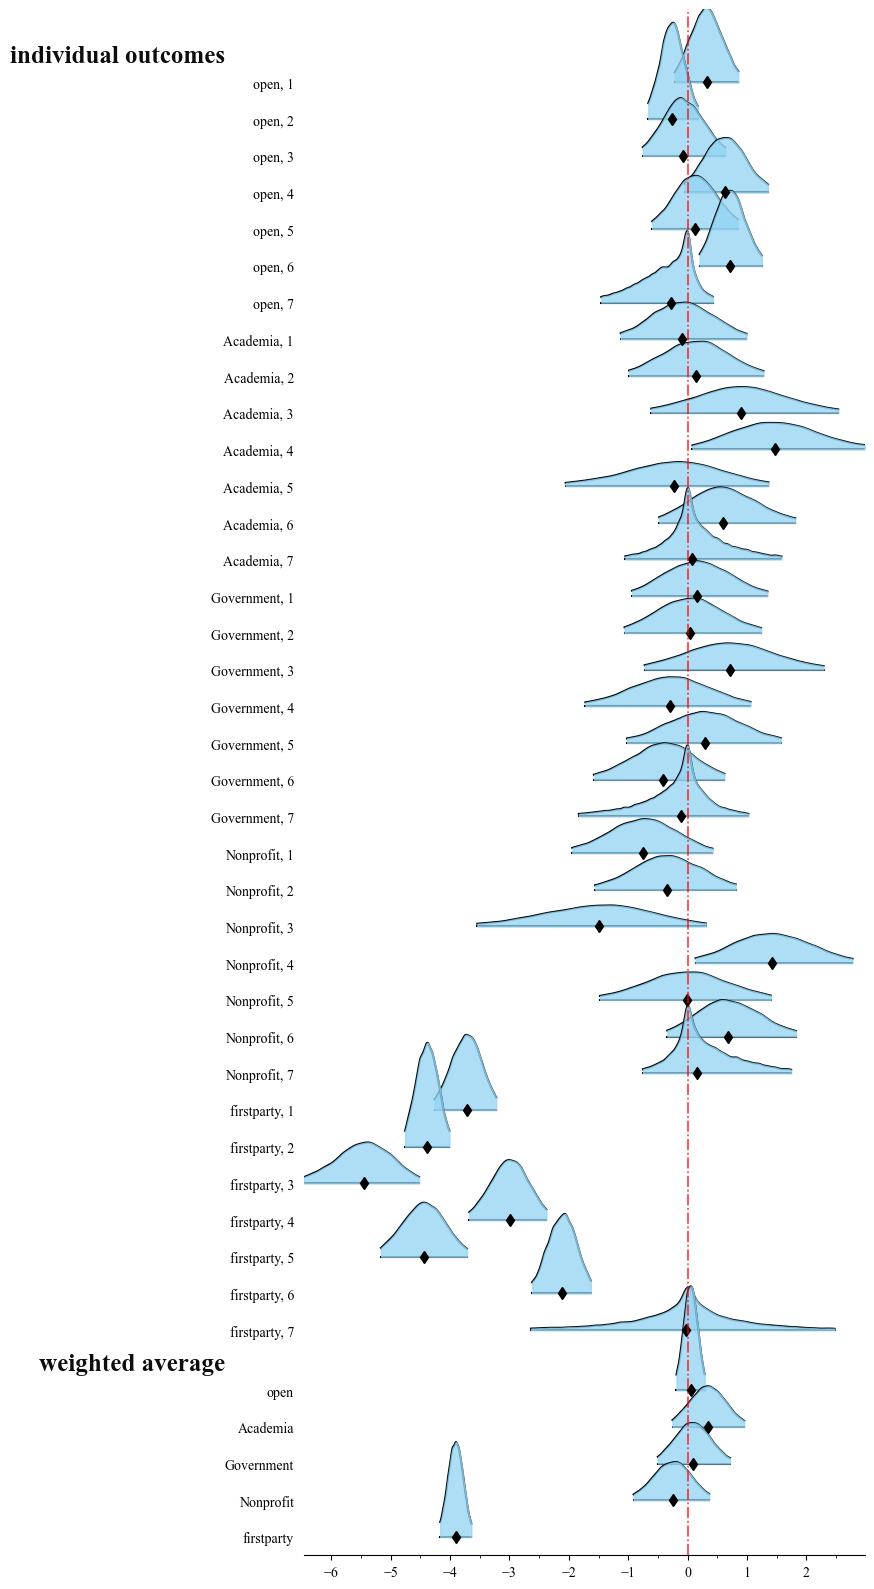

In [89]:
ax = az.plot_forest(
    idata_5,
    kind="ridgeplot",
    var_names=[r"^beta(?!.*_chol)", r"^beta_pop(?!.*_chol)"],
    filter_vars="regex",
    combined=True,
    hdi_prob=0.95,
    ridgeplot_quantiles=[0.5],
    quartiles=False,
    ridgeplot_alpha=0.75,
    ridgeplot_overlap=1,
    ridgeplot_truncate=True,
    colors=["#92D4F3"],
    figsize=(8, 16),
)

ax0 = ax[0] if isinstance(ax, (list, np.ndarray)) else ax
ax0.axvline(0, color="red", alpha=0.75, linestyle="-.", linewidth=1.25)

# Set x-axis ticks: major every 1, minor every 0.5
ax0.xaxis.set_major_locator(MultipleLocator(1.0))
ax0.xaxis.set_minor_locator(MultipleLocator(0.5))

# Remove whitespace between the lowest y-tick and the x-axis
ax0.margins(x=0, y=0)
yt = np.asarray(ax0.get_yticks())
if yt.size >= 2:
    step = float(np.median(np.diff(yt)))
else:
    step = 1.0
ax0.set_ylim(yt[0] - 0.5 * step, yt[-1] + 2 * step)

# Remove the horizontal line (top spine) on top of the figure
if hasattr(ax0, "spines") and "top" in ax0.spines:
    ax0.spines["top"].set_visible(False)

# Ensure tick labels are rendered before we modify them
try:
    ax0.figure.canvas.draw()
except Exception:
    pass

# Original labels for parsing groups
orig_labels = [t.get_text() for t in ax0.get_yticklabels()]


def _get_group(lbl):
    if not isinstance(lbl, str):
        return None
    m = re.match(r"^(beta(?:_pop)?)\[(.*)\]$", lbl)
    if m:
        return m.group(1)
    if lbl.startswith("beta_pop"):
        return "beta_pop"
    if lbl.startswith("beta"):
        return "beta"
    return None


def _clean_label(lbl):
    # Remove prefixes 'beta'/'beta_pop', remove all brackets, and recode 0-6 -> 1-7
    if not isinstance(lbl, str):
        return lbl
    s = lbl
    m = re.match(r"^(beta(?:_pop)?)\[(.*)\]$", s)
    if m:
        s = m.group(2)  # keep inside the brackets
    elif s.startswith("beta_pop"):
        s = re.sub(r"^beta_pop\s*", "", s)
    elif s.startswith("beta"):
        s = re.sub(r"^beta\s*", "", s)
    # Remove any leftover brackets
    s = s.replace("[", "").replace("]", "")
    # Recode standalone digits 0-6 to 1-7
    s = re.sub(r"\b([0-6])\b", lambda m: str(int(m.group(1)) + 1), s)
    # Normalize comma spacing
    s = re.sub(r"\s*,\s*", ", ", s).strip()
    # Change open_c to open
    s = s.replace("open_c", "open")
    return s


groups = [_get_group(s) for s in orig_labels]
clean = [_clean_label(s) for s in orig_labels]

# Apply cleaned labels
if any(isinstance(s, str) and len(s) for s in clean):
    ax0.set_yticklabels(clean)

# Add horizontal subtitles for groups OUTSIDE (left of) the ticks, keeping positions
yticks = ax0.get_yticks()


def _add_horizontal_group_label(group_name, label_text, x_pos=-0.14, fontsize=18):
    idxs = [i for i, g in enumerate(groups) if g == group_name]
    if not idxs:
        return
    pos = [yticks[i] + 0.25 for i in idxs if i < len(yticks)]
    if not pos:
        return
    y_mid = 0.5 * (min(pos) + max(pos))
    ax0.text(
        x_pos,
        y_mid,
        label_text,
        transform=ax0.get_yaxis_transform(),
        rotation=0,
        va="center",
        ha="right",
        fontsize=fontsize,
        fontweight="bold",
        color="black",
        alpha=0.95,
        clip_on=False,
        zorder=10,
    )


_add_horizontal_group_label("beta", "individual outcomes", x_pos=-0.14, fontsize=18)
_add_horizontal_group_label("beta_pop", "weighted average", x_pos=-0.14, fontsize=18)

# Add a bit of padding so outside labels are fully visible
fig = ax0.figure
plt.tight_layout()
fig.subplots_adjust(left=0.28)
plt.show()

# Save to pdf
fig.savefig("fig/model5_forest_slopes.pdf", dpi=600, bbox_inches="tight")

In [90]:
def _get_figure_from_obj(obj):
    if isinstance(obj, np.ndarray):
        try:
            obj = obj.ravel()[0]
        except Exception:
            pass
    for attr in ("figure", "fig"):
        fig = getattr(obj, attr, None)
        if fig is not None:
            return fig
    getf = getattr(obj, "get_figure", None)
    if callable(getf):
        try:
            return getf()
        except Exception:
            pass
    if hasattr(obj, "savefig"):
        return obj
    return plt.gcf()


def save_year_conditional_smooth_pooled(idata, pool, out_path, dpi=600):
    fig = _get_figure_from_obj(plot_year_conditional_smooth(idata, pool=pool))
    try:
        os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)
    except Exception:
        pass
    fig.savefig(out_path, dpi=dpi, bbox_inches="tight", pad_inches=0.0)
    plt.close(fig)
    print(f"Saved pooled ({pool}) year smooth to {out_path}")
    return out_path

In [91]:
pdf_path_year_weighted = save_year_conditional_smooth_pooled(
    idata_5, pool="weighted", out_path="fig/model5_year_pooled_weighted.pdf"
)

Saved pooled (weighted) year smooth to fig/model5_year_pooled_weighted.pdf


In [92]:
pdf_path_year_mean = save_year_conditional_smooth_pooled(
    idata_5, pool="mean", out_path="fig/model5_year_pooled_mean.pdf"
)

Saved pooled (mean) year smooth to fig/model5_year_pooled_mean.pdf


In [83]:
for k in range(J):
    obj = plot_year_conditional_smooth(idata_5, outcome=k)
    fig = None
    if hasattr(obj, "figure"):
        fig = obj.figure
    elif hasattr(obj, "fig"):
        fig = obj.fig
    elif hasattr(obj, "get_figure"):
        try:
            fig = obj.get_figure()
        except Exception:
            pass
    elif hasattr(obj, "savefig"):
        fig = obj
    if fig is None:
        fig = plt.gcf()
    out_path = f"fig/model5_year_outcome_{k}.pdf"
    fig.savefig(out_path, dpi=600, bbox_inches="tight", pad_inches=0.0)
    plt.close(fig)
    print(f"Saved year conditional smooth for outcome {k} to {out_path}")

Saved year conditional smooth for outcome 0 to fig/model5_year_outcome_0.pdf
Saved year conditional smooth for outcome 1 to fig/model5_year_outcome_1.pdf
Saved year conditional smooth for outcome 2 to fig/model5_year_outcome_2.pdf
Saved year conditional smooth for outcome 3 to fig/model5_year_outcome_3.pdf
Saved year conditional smooth for outcome 4 to fig/model5_year_outcome_4.pdf
Saved year conditional smooth for outcome 5 to fig/model5_year_outcome_5.pdf
Saved year conditional smooth for outcome 6 to fig/model5_year_outcome_6.pdf


Saved pair plot to fig/model5_beta_pair.pdf


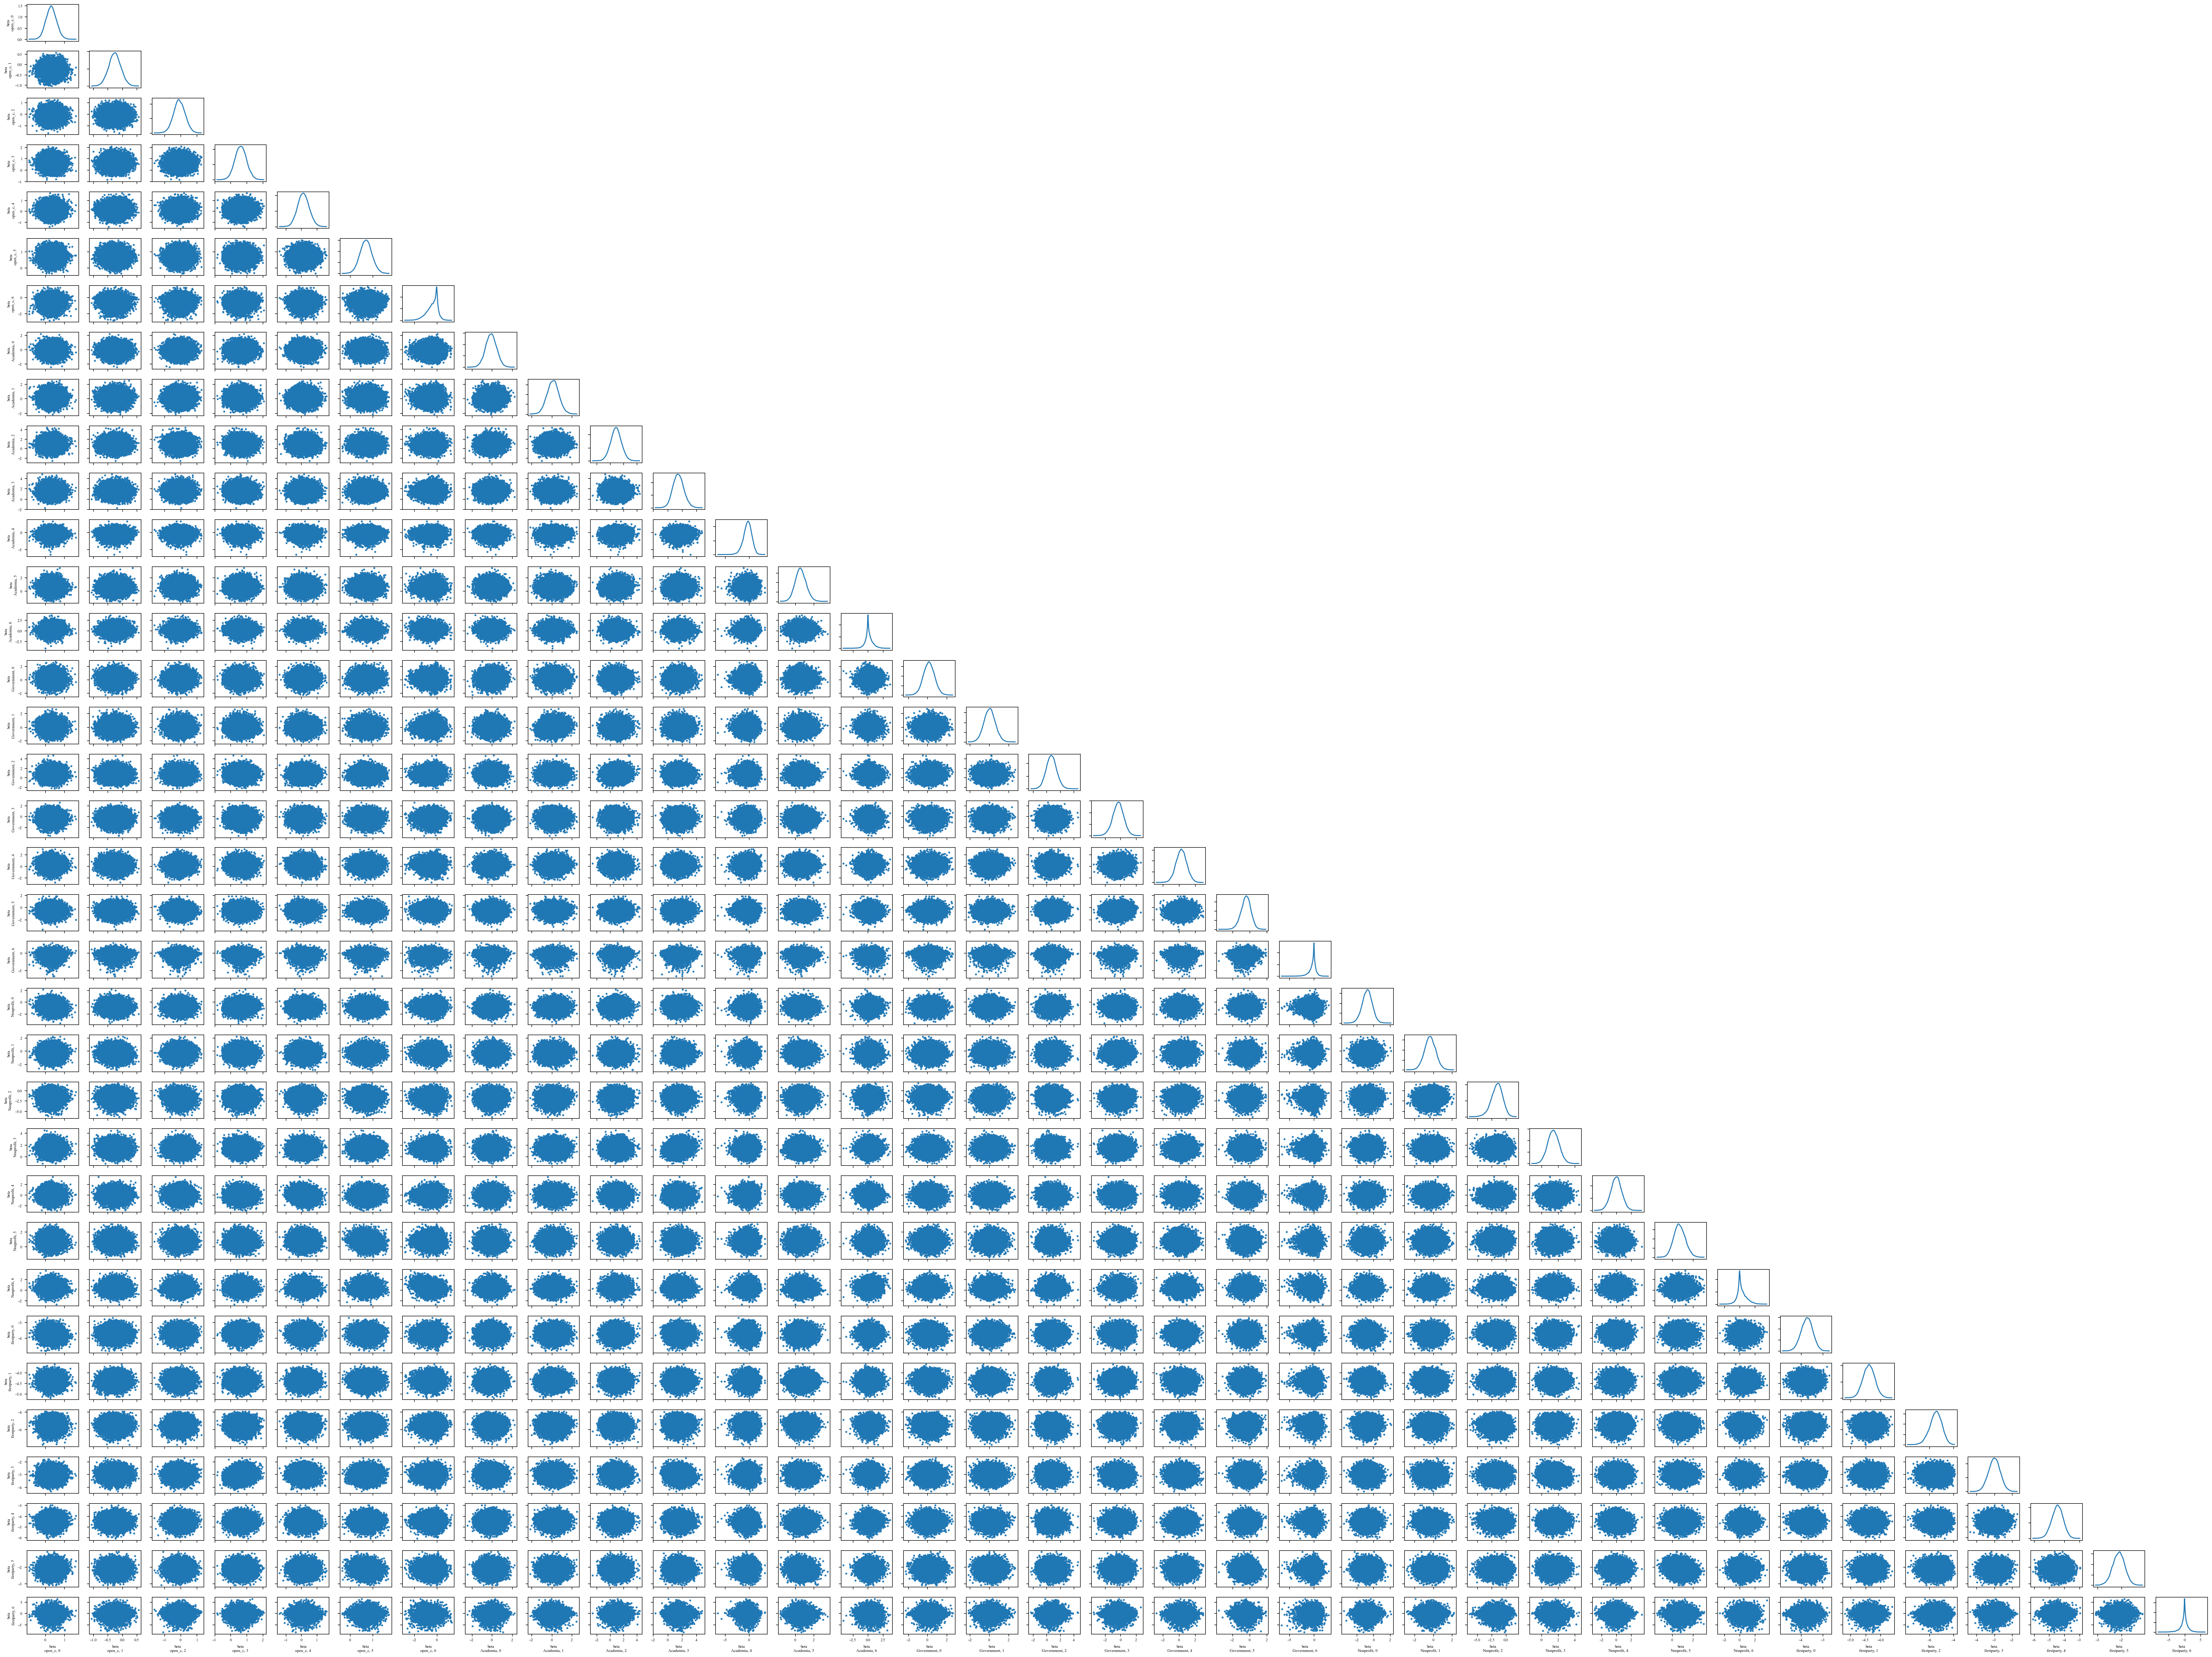

In [84]:
with az.rc_context(rc={"plot.max_subplots": None}):
    axes = az.plot_pair(
        idata_5,
        var_names=["beta"],
        divergences=True,
        marginals=True,
        figsize=(48, 36),  # big figure
        textsize=6,
    )
fig = axes.ravel()[0].figure if isinstance(axes, np.ndarray) else axes.figure
plt.tight_layout()
pdf_path_pair = "fig/model5_beta_pair.pdf"
fig.savefig(pdf_path_pair, dpi=600, bbox_inches="tight")
print(f"Saved pair plot to {pdf_path_pair}")

In [85]:
icc_df_5, icc_overall_5 = compute_icc_vpc(
    idata_5,
    out_idx=out_idx,
    reg_idx=reg_idx,
    cty_idx=cty_idx,
    prov_idx=prov_idx,
    fp_idx=fp_idx,
    link="logit",  # <- change to "probit" if you sampled probit
    include_year=True,
    include_firstparty_group=("firstparty_int" in idata_5.posterior.data_vars),
)

In [86]:
icc_df_5

outcome     component  ICC_mean    ICC_05    ICC_95
0         0       country  0.000689 -0.022177  0.026226
1         0      provider  0.030671 -0.000256  0.083343
2         0        region  0.087814  0.031559  0.155860
3         0  total_random  0.121473  0.058855  0.194632
4         0          year  0.002299 -0.000087  0.007894
5         1       country  0.001749 -0.006989  0.014115
6         1      provider  0.074842  0.039955  0.113705
7         1        region  0.022414  0.000711  0.051564
8         1  total_random  0.126903  0.089771  0.167112
9         1          year  0.027898  0.014139  0.044380
10        2       country  0.002097 -0.036205  0.047375
11        2      provider  0.135715  0.051972  0.229735
12        2        region  0.084523  0.015423  0.169499
13        2  total_random  0.224537  0.128126  0.326647
14        2          year  0.002201 -0.000483  0.006900
15        3       country  0.027970 -0.005749  0.088436
16        3      provider  0.293358  0.199710  0.392802
17        3        region  0.033815 -0.007593  0.093779
18        3  total_random  0.357673  0.262798  0.454990
19        3          year  0.002530 -0.001915  0.010195
20        4       country  0.035717 -0.002915  0.107512
21        4      provider  0.136443  0.047165  0.238564
22        4        region  0.027267 -0.006395  0.093466
23        4  total_random  0.202174  0.105187  0.307250
24        4          year  0.002748 -0.000319  0.008770
25        5       country  0.023353 -0.000610  0.068734
26        5      provider  0.008572 -0.000352  0.032465
27        5        region  0.010475 -0.005649  0.043984
28        5  total_random  0.044713  0.010874  0.091238
29        5          year  0.002313  0.000003  0.006964
30        6       country  0.009355 -0.006811  0.045509
31        6      provider  0.046400  0.000136  0.163747
32        6        region  0.033571 -0.000546  0.136142
33        6  total_random  0.091874  0.011448  0.233013
34        6          year  0.002547 -0.000343  0.008531

In [87]:
icc_overall_5

component
total_random    0.157818
provider        0.094321
region          0.041655
year            0.012504
country         0.009338
dtype: float64

/tmp/ipykernel_3241/4129367833.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", pv_norm.shape[1])


Saved ICC components plot to fig/model5_var_components.pdf


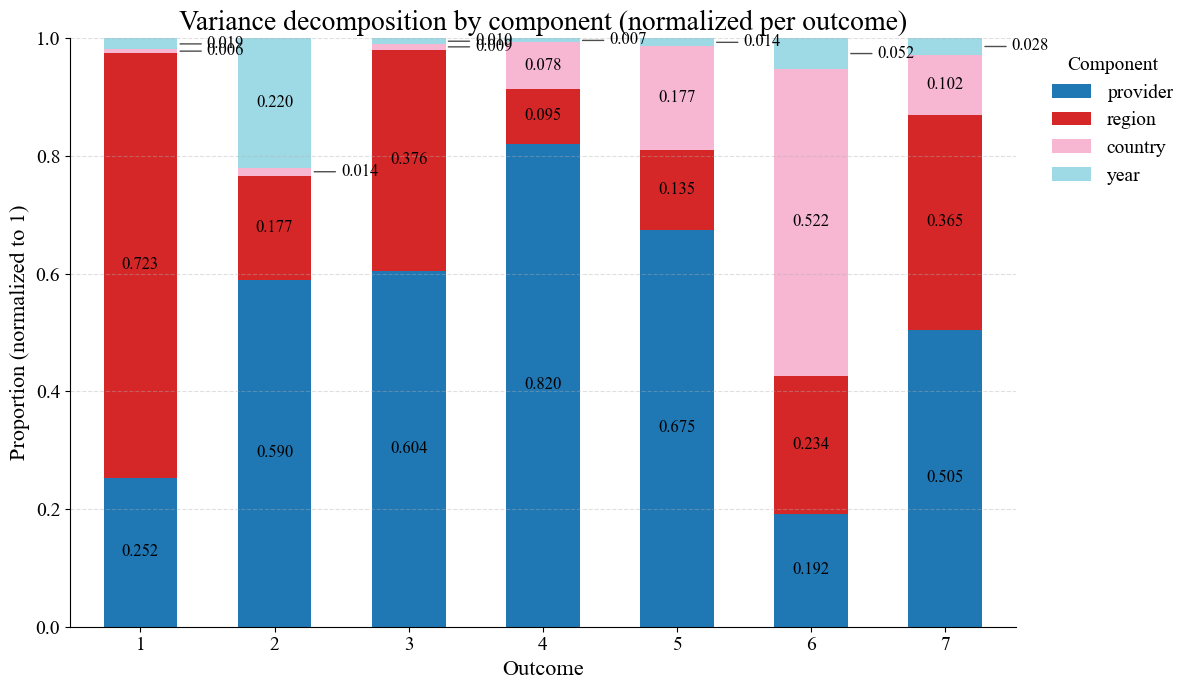

In [88]:
# Stacked bar plot of ICC component contributions per outcome (normalized per outcome)
df_comp = icc_df_5[icc_df_5["component"] != "total_random"].copy()
if not df_comp.empty:
    # Font sizes
    fs_title = 20
    fs_label = 16
    fs_tick = 14
    fs_legend = 14
    fs_annot = 12

    # Order components by overall mean contribution
    comp_order = (
        df_comp.groupby("component")["ICC_mean"]
        .mean()
        .sort_values(ascending=False)
        .index
    )

    pv = (
        df_comp.pivot_table(
            index="outcome", columns="component", values="ICC_mean", aggfunc="mean"
        )
        .reindex(columns=comp_order)
        .sort_index()
        .fillna(0.0)
    )

    # Normalize each outcome's components to sum to 1
    row_sums = pv.sum(axis=1).replace(0, np.nan)
    pv_norm = pv.div(row_sums, axis=0).fillna(0.0)

    cmap = plt.cm.get_cmap("tab20", pv_norm.shape[1])
    colors = [cmap(i) for i in range(pv_norm.shape[1])]

    fig_icc, ax_icc = plt.subplots(figsize=(12, 7))
    bar_width = 0.55  # narrower bars to increase the space between them
    pv_norm.plot(kind="bar", stacked=True, ax=ax_icc, color=colors, width=bar_width)

    # Add some horizontal margin so side labels have room
    ax_icc.margins(x=0.18)

    ax_icc.set_xlabel("Outcome", fontsize=fs_label)
    ax_icc.set_ylabel("Proportion (normalized to 1)", fontsize=fs_label)
    ax_icc.set_title(
        "Variance decomposition by component (normalized per outcome)",
        fontsize=fs_title,
    )

    ax_icc.set_ylim(0, 1.0)
    ax_icc.grid(axis="y", linestyle="--", alpha=0.4)
    ax_icc.legend(
        title="Component",
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        frameon=False,
        prop={"size": fs_legend},
        title_fontsize=fs_legend,
    )

    # Increase tick font sizes
    ax_icc.tick_params(axis="both", labelsize=fs_tick)

    # Remove the horizontal line (top spine)
    if hasattr(ax_icc, "spines"):
        if "top" in ax_icc.spines:
            ax_icc.spines["top"].set_visible(False)
        if "right" in ax_icc.spines:
            ax_icc.spines["right"].set_visible(False)

    # Recode x-tick labels from 0-6 to 1-7
    def _recode_tick(val):
        try:
            n = int(str(val).strip())
            if 0 <= n <= 6:
                return str(n + 1)
        except Exception:
            pass
        return str(val)

    xticks = ax_icc.get_xticks()
    ax_icc.set_xticklabels(
        [_recode_tick(v) for v in pv_norm.index], rotation=0, fontsize=fs_tick
    )

    # Annotate segment values; if not enough space, put number on the side with a line
    inside_thresh = 0.06  # if segment height < this, label on the side
    side_dx = 0.22  # horizontal offset for side labels in data x-units
    for i, outcome in enumerate(pv_norm.index):
        cum = 0.0
        for j, comp in enumerate(pv_norm.columns):
            v = float(pv_norm.iloc[i, j])
            if v <= 0:
                continue
            y_center = cum + v / 2.0
            x_center = xticks[i]
            if v >= inside_thresh:
                ax_icc.text(
                    x_center,
                    y_center,
                    f"{v:.3f}",
                    ha="center",
                    va="center",
                    fontsize=fs_annot,
                    color="black",
                    zorder=5,
                )
            else:
                # Place label to the right with a connector line to the segment
                x_text = x_center + (bar_width / 2.0) + side_dx
                ax_icc.annotate(
                    f"{v:.3f}",
                    xy=(x_center + bar_width / 2.0, y_center),
                    xytext=(x_text, y_center),
                    textcoords="data",
                    ha="left",
                    va="center",
                    fontsize=fs_annot,
                    color="black",
                    arrowprops=dict(arrowstyle="-", color="0.3", lw=1.0),
                    zorder=6,
                    clip_on=False,
                )
            cum += v
else:
    # Fallback to avoid downstream errors if df_comp is empty
    fig_icc, ax_icc = plt.subplots(figsize=(8, 4))
    ax_icc.axis("off")
    ax_icc.set_title("No ICC components available for plotting", fontsize=16)

# Save to pdf
pdf_path_icc_5 = "fig/model5_var_components.pdf"
try:
    os.makedirs(os.path.dirname(pdf_path_icc_5) or ".", exist_ok=True)
except Exception:
    pass
fig_icc.tight_layout()
fig_icc.savefig(pdf_path_icc_5, dpi=600, bbox_inches="tight")
print(f"Saved ICC components plot to {pdf_path_icc_5}")

### Model 6: Model 5 Splines -> GP

In [93]:
model_6 = build_model(
    coords=coords,
    out_idx=out_idx,
    reg_idx=reg_idx,
    cty_idx=cty_idx,
    prov_idx=prov_idx,
    fp_idx=fp_idx,
    W=W,
    y_obs=y_obs,
    K=K,
    link="logit",
    firstparty_role="predictor",
    C2R=C2R,
    P2C=P2C,
    reg_country_counts=reg_country_counts,
    cty_prov_counts=cty_prov_counts,
    intercept_corr={
        "region": False,
        "country": False,
        "provider": False,
        "firstparty": False,
    },
    slopes={"region": False, "country": False, "provider": False, "firstparty": False},
    slope_corr={
        "region": False,
        "country": False,
        "provider": False,
        "firstparty": False,
    },
    lkj_eta=6.0,
    sd_reg_int=0.4,
    sd_cty_dev=0.4,
    sd_prov_dev=0.4,
    sd_fp_int=0.4,
    sd_sigma=1,
    # sd_slope=0.5,
    cutpoint_prior="dirichlet",
    dirichlet_center=True,
    separate_slope_sd=False,
    pop_slope_corr=True,  # <----- population slopes correlated across outcomes
    # Year inputs
    year_std=year_std,
    year_u=year_u,
    year_idx=year_idx,
    year_mode="gp",  # options: "linear" | "spline" | "gp" | None
    sd_year=0.25,
    gp_jitter=1e-6,
    gp_shared_hypers=True,
    return_components=True,
)

ValueError: Dimension year_unique is not specified in `coords`.

## Model comparison

In [353]:
model_comparison = az.compare(
    {
        "model 1": idata_1,
        "model 2": idata_2,
        "model 3": idata_3,
        "model 4": idata_4,
        "model 5": idata_5,
    },
    method="stacking",
    ic="loo",
)

In [354]:
model_comparison

rank     elpd_loo      p_loo  elpd_diff        weight         se  \
model 5     0 -1523.454539  67.203629   0.000000  9.535459e-01  38.215055   
model 4     1 -1547.924770  45.495780  24.470231  1.108737e-12  37.899895   
model 1     2 -1551.265671  48.630306  27.811131  4.645411e-02  37.921405   
model 2     3 -1551.514130  48.652534  28.059591  0.000000e+00  37.918110   
model 3     4 -1551.919652  44.954685  28.465113  1.737055e-11  37.649096   

              dse  warning scale  
model 5  0.000000    False   log  
model 4  4.748011    False   log  
model 1  7.736258    False   log  
model 2  7.742614    False   log  
model 3  5.147779    False   log